### Step 0 - import libraries

In [1]:
# data wrangling & visualization
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns
%matplotlib inline
from subprocess              import check_output
from matplotlib.ticker       import StrMethodFormatter
from numpy                   import mean

# models
import xgboost             as xgb

from xgboost                 import XGBClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import Ridge
from sklearn.linear_model    import Lasso
from sklearn.ensemble        import GradientBoostingClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.linear_model    import SGDClassifier
from sklearn.kernel_ridge    import KernelRidge
from sklearn.linear_model    import ElasticNet
from sklearn.base            import BaseEstimator
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm
from sklearn.linear_model    import LogisticRegression

# preprocessing & feature engineering
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import FunctionTransformer
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import OneHotEncoder
from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import StandardScaler
from scipy                     import stats
from sklearn.preprocessing     import KBinsDiscretizer
from sklearn.model_selection   import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing     import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
# conda install -c conda-forge imbalanced-learn 
from imblearn.over_sampling    import SMOTE
from imblearn.pipeline         import Pipeline as imbpipeline
from sklearn.pipeline          import Pipeline

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics         import accuracy_score
from sklearn                 import metrics
from sklearn.metrics         import matthews_corrcoef
from sklearn.metrics         import precision_recall_curve
from sklearn.metrics         import plot_precision_recall_curve
from sklearn.metrics         import average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import make_scorer
from sklearn.metrics         import precision_score, accuracy_score, recall_score, f1_score

# warning, errors...
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import time
%load_ext memory_profiler

### Step 1 - read data

  - List the data you need and how much you need.

  - Find and document where you can get the data.

  - Check how much space it will take.

  - Check legal obligations, and get authorizations if necessary.

  - Get access authorizations.

  - Create a workspace (with enough storage space).

  - Get the data.

  - Convert the data to a format you can easily manipulate (without changing the data itself).

  - Ensure sensitive information is deleted or protected (e.g. anonymized).

  - Check the size and type of data (time series, sample, geographical, etc.).

  - Sample a test set, put it aside, and never look at it (no data snooping!).

In [2]:
%time %memit
PATH = '/home/florianriemann/data_science_portfolio/boot_camp/data/titanic/'

df_titanic, df_titanic.name = pd.read_csv(PATH + 'train.csv'), 'df_titanic'
df_titanic.set_index(['PassengerId'], inplace=True)
df_titanic.head(2)

peak memory: 240.68 MiB, increment: 0.28 MiB
CPU times: user 82.6 ms, sys: 19.9 ms, total: 102 ms
Wall time: 238 ms


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Step 2 - train-test-split

<hr style="border:2px solid black">

*Don't get biased by any stretch of the imagination. Do the train-test-split as early as possible!*

<hr style="border:2px solid black">

In [3]:
%time %memit
X = df_titanic.loc[:, ~df_titanic.columns.isin(['Survived'])]
y = df_titanic.loc[:,  df_titanic.columns.isin(['Survived'])]

peak memory: 243.10 MiB, increment: 0.21 MiB
CPU times: user 62.1 ms, sys: 59.5 ms, total: 122 ms
Wall time: 261 ms


In [4]:
%time %memit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

peak memory: 243.45 MiB, increment: 0.01 MiB
CPU times: user 72.7 ms, sys: 44.6 ms, total: 117 ms
Wall time: 257 ms


### Step 3 - exploratory data analysis

#### Step 3.0 - workflow

  - Create a copy of the data exploration (sampling it down to a manageble size if necessary).

  - Create a notebook to keep a record of your data exploration.

  - Study each attribute and its characteristics:

    - Name
    - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
    - % of missing values
    - Noisiness and type of noise (stoxastoc, outliers, rounding errors, etc.)
    - Possibly useful for the task?
    - Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - For supervised learning tasks, identify target attribute(s).

  - Visualize the data.

  - Study the correlation between attributes.

  - Study how you would solve the problem manually.

  - Identify the promising transformations you may want to apply.

  - Identify extra data that would be useful.

  - Document what you have learned.

#### Step 3.1 - general overview

##### **Categorical:**

- `Nominal`

>- <u>Cabin</u> - Cabin number   
>- <u>Embarked</u> - Port of Embarkation ( C = Cherbourg | Q = Queenstown | S = Southampton )

- `Dichotomous`

>- <u>Sex</u> - ( Female | Male )

- `Ordinal`
    
>- <u>Pclass</u> - Ticket class ( 1 = 1st | 2 = 2nd | 3 = 3rd )
    * A proxy for socio-economic status (SES)
        - 1st = Upper
        - 2nd = Middle
        - 3rd = Lower

##### **Numeric:**

- `Discrete`

>- <u>Passenger ID</u>
>- <u>SibSp</u> - # of siblings / spouses aboard the Titanic	
    * sibsp: The dataset defines family relations in this way...
        - Sibling = brother, sister, stepbrother, stepsister
        - Spouse  = husband, wife (mistresses and fiancés were ignored)
>- <u>Parch</u> - # of parents / children aboard the Titanic
    * parch: The dataset defines family relations in this way...
        - Parent = mother, father
        - Child  = daughter, son, stepdaughter, stepson
        - Some children travelled only with a nanny, therefore parch = 0 for them.
>- <u>Survived</u> - ( 0 = Not Survived | 1 = Surived ) 

- `Continous`

>- <u>Age</u> - Age in years
    * Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

>- <u>Fare</u> - Passenger fare

##### **Text:**

- <u>Ticket</u> - Ticket number
- <u>Name</u> - Name of passenger

In [5]:
%time %memit
# for the EDA we will only use the training data, that includes the input vector as well as the labels
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

peak memory: 243.61 MiB, increment: 0.02 MiB
CPU times: user 91.6 ms, sys: 29.2 ms, total: 121 ms
Wall time: 259 ms


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1
151,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,0
222,2,"Bracken, Mr. James H",male,27.0,0,0,220367,13.0000,NaN,S,0
366,3,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.2500,NaN,S,0
325,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S,0


In [6]:
df_train.shape

(712, 11)

In [7]:
# we get a first impression of missing data in Age, Cabin and Embarked. 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 9 to 844
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       570 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     151 non-null    object 
 9   Embarked  711 non-null    object 
 10  Survived  712 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [8]:
list(df_train.columns)

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Survived']

In [9]:
# in further analysis I will mainly distinguish between numerical and categorical features
cat_features = []
num_features = ['Survived']
for col in df_train.columns:
    if str(df_train[col].dtype) == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

In [10]:
cat_features

['Pclass',
 'Name',
 'Sex',
 'SibSp',
 'Parch',
 'Ticket',
 'Cabin',
 'Embarked',
 'Survived']

In [11]:
num_features

['Survived', 'Age', 'Fare']

#### Step 3.2 - descriptive statistics

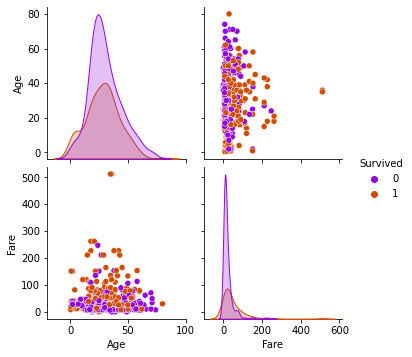

In [12]:
# It looks like there is a correlation between age and survival rate 
# as well as between fare and survival rate, meaning the higher there fare / age 
# the higher the chances to survive.
# The distribution of the age looks gaussian'ish and the distribution of fare is highly skewed.
sns.pairplot(  df_train[num_features]
             , hue       = "Survived"
             , palette   = "gnuplot"
             , diag_kind = "kde"
             , height    = 2.5
            );

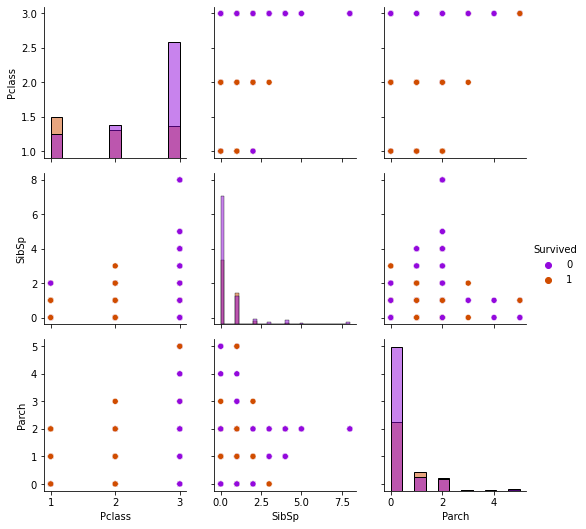

In [13]:
# As it is to be expected there might be a correlation between the PClass and the survival rate,
# so the chances to survive are the highest for class 1 and lowest for class 3.
# Furthermore there is a strong impact on the survival rate based on the number of relatives 
# someone is travelling with. Those who travelled in the 1st or 2nd class with relatives most likely survived.

g = sns.PairGrid(df_train[cat_features], hue = "Survived",  palette = "gnuplot")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

In [14]:
# get a glance through the descriptive statistics
df_train.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,712.000000,570.000000,712.000000,712.000000,712.000000,712.000000
mean,2.303371,29.495193,0.491573,0.356742,32.133941,0.369382
std,0.828867,14.169135,1.093356,0.782534,50.508682,0.482977
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.895800,0.000000
50%,3.000000,28.000000,0.000000,0.000000,13.500000,0.000000
75%,3.000000,38.000000,1.000000,0.000000,31.068750,1.000000
max,3.000000,80.000000,8.000000,5.000000,512.329200,1.000000


In [15]:
# are there any duplicated rows?
df_train.duplicated().sum()

0

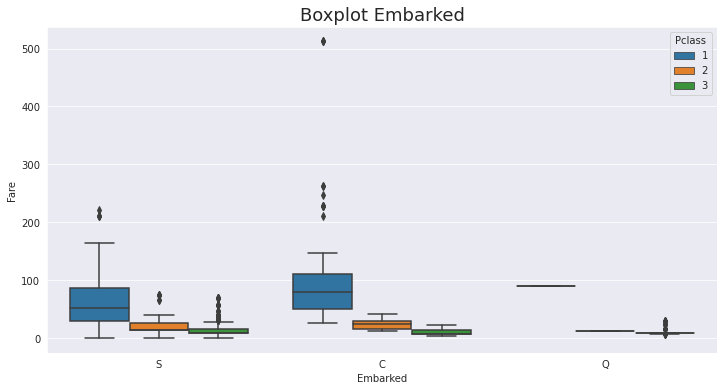

In [16]:
# Regarding the embarkation some of the most expensive tickets were sold to passengers who embarked in 
# Cherbourg. The price for tickets who embarked in Queenstown is very little which might be 
# associated with the number of passengers.
# C = Cherbourg | Q = Queenstown | S = Southampton
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (12,6), ncols = 1)
ax      = sns.boxplot(  x    = "Embarked"
                      , y    = "Fare"
                      , hue  = "Pclass"
                      , data = df_train)
ax.set_title("Boxplot Embarked", fontsize = 18);

In [17]:
# lets look for missing data
data_missing_values = df_train.isna().mean().round(4) * 100
data_missing_values = data_missing_values.to_frame()
data_missing_values = data_missing_values.rename(columns = {0:'percentage of nan'})
data_missing_values

,percentage of nan
Pclass,0.00
Name,0.00
Sex,0.00
Age,19.94
SibSp,0.00
Parch,0.00
Ticket,0.00
Fare,0.00
Cabin,78.79
Embarked,0.14


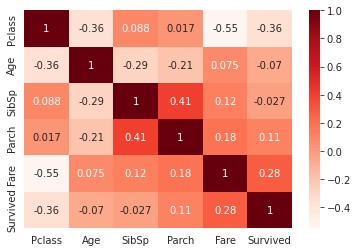

In [18]:
# Correlation:
#    - Fare & PClass | -0.36
#    - Parch & SibSp |  0.41
# Most interestingly we see a correlation between survived and fare of 0.28 and pclass and survived of -0.36.
sns.heatmap(df_train.corr(),cmap="Reds",annot=True);

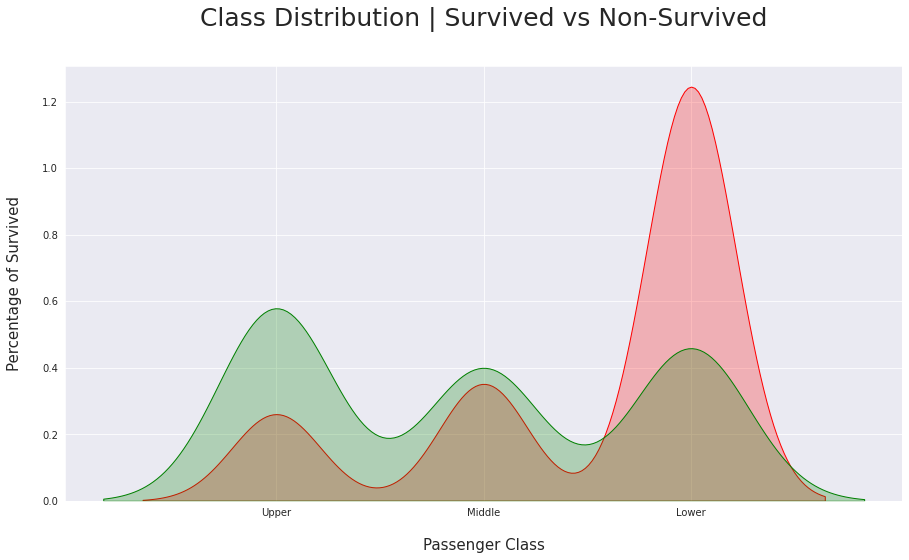

In [19]:
# Kernel Density Plot for Pclass
# As expected and concluded from above being a passenger in the third class reduced the chance to survive drastically.
fig = plt.figure(figsize=(15,8),)

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 0),'Pclass']
                 , color = 'red'
                 , shade = True
                 , label = 'Not Survived'
                )

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 1),'Pclass']
                 , color = 'green'
                 , shade = True
                 , label = 'Survived'
              )

plt.title('Class Distribution | Survived vs Non-Survived' , fontsize = 25, pad      = 40)
plt.ylabel("Percentage of Survived"                       , fontsize = 15, labelpad = 20)
plt.xlabel("Passenger Class"                              , fontsize = 15, labelpad = 20)
labels = ['Upper', 'Middle', 'Lower']
plt.xticks(sorted(df_train.Pclass.unique()), labels);

''

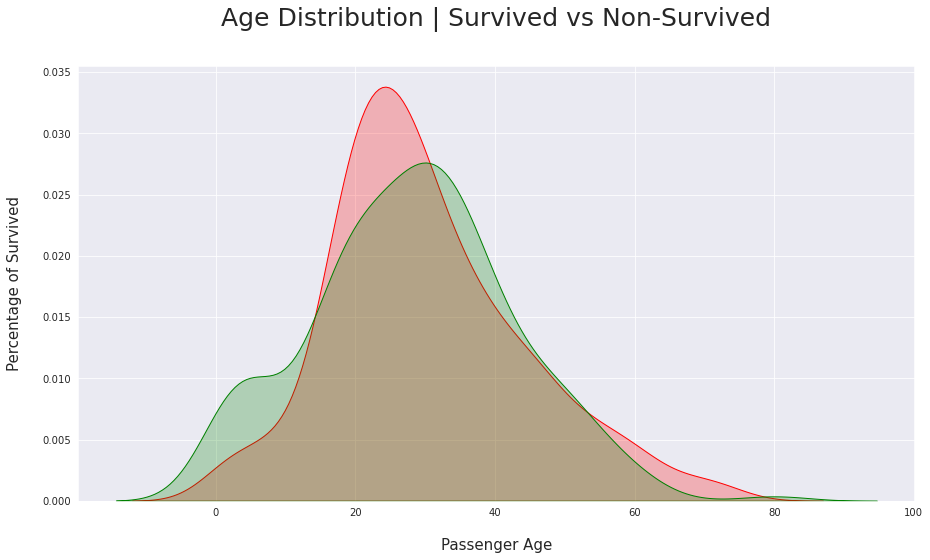

In [20]:
# Kernel Density Plot for Age
# Being in the age between approximately 17 and 35 as well as 55+ increased the probability not to survive.
fig = plt.figure(figsize=(15,8),)

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 0),'Age']
                 , color = 'red'
                 , shade = True
                 , label = 'Not Survived'
                )

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 1),'Age']
                 , color = 'green'
                 , shade = True
                 , label = 'Survived'
              )

plt.title('Age Distribution | Survived vs Non-Survived'   , fontsize = 25, pad      = 40)
plt.ylabel("Percentage of Survived"                       , fontsize = 15, labelpad = 20)
plt.xlabel("Passenger Age"                                , fontsize = 15, labelpad = 20)
;

#### Step 3.3 - observe some features in more detail

##### Step 3.2.1 - PassengerId

In [21]:
# no valuable information

##### Step 3.2.2 - Pclass

In [22]:
# The chances of survival are in class 2 almost equal.
df_train.groupby(['Pclass','Survived']).size().unstack('Survived')

Survived,0,1
Pclass,,
1,63,106
2,85,73
3,301,84


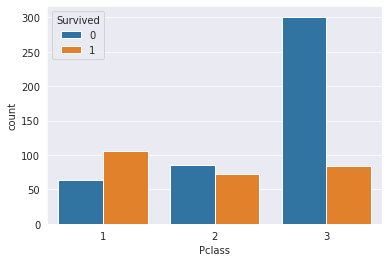

In [23]:
# the higher the class the higher the survival rate.  
# there is a higher probality to not survive in the 3rd class
sns.countplot(data=df_train,x=df_train['Pclass'],hue='Survived'); 

##### Step 3.2.3 - Name

In [24]:
df_train[['Name']].head(3)

,Name
PassengerId,
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
151,"Bateman, Rev. Robert James"
222,"Bracken, Mr. James H"


In [25]:
# As seen there is some more information in this feature contained than just a name.
# I split the feature along the commas into two columns, so that I get the lstname and a combination 
# of the firstname and the titke that needs to be split afterwards once again.
df_train_names = df_train["Name"].str.split(',', expand=True)
df_train_names.rename(columns={0:'Lastname', 1:'title_and_firstname'}, inplace=True)
df_train_names.head(3)

,Lastname,title_and_firstname
PassengerId,,
9,Johnson,Mrs. Oscar W (Elisabeth Vilhelmina Berg)
151,Bateman,Rev. Robert James
222,Bracken,Mr. James H


In [26]:
# get the title from title_and_firstname
df_train_titles = df_train_names["title_and_firstname"].str.split(' ', expand=True)
df_train_titles.rename(columns={1:'Title'}, inplace=True)
df_train_titles = df_train_titles[["Title"]]
df_train_titles.head(3)

,Title
PassengerId,
9,Mrs.
151,Rev.
222,Mr.


In [27]:
# Check the titles. 
df_train_titles["Title"].unique()

array(['Mrs.', 'Rev.', 'Mr.', 'Major.', 'Master.', 'Miss.', 'Lady.',
       'Jonkheer.', 'Dr.', 'Col.', 'Mlle.', 'Ms.', 'Sir.', 'Capt.',
       'Don.', 'the'], dtype=object)

In [28]:
# Concat df_train, df_train_names, df_train_titles
df_train = pd.concat([df_train, df_train_titles, df_train_names], axis=1)
df_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Lastname,title_and_firstname
PassengerId,,,,,,,,,,,,,,
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,Mrs.,Johnson,Mrs. Oscar W (Elisabeth Vilhelmina Berg)
151,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,0,Rev.,Bateman,Rev. Robert James
222,2,"Bracken, Mr. James H",male,27.0,0,0,220367,13.0000,NaN,S,0,Mr.,Bracken,Mr. James H
366,3,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.2500,NaN,S,0,Mr.,Adahl,Mr. Mauritz Nils Martin
325,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S,0,Mr.,Sage,Mr. George John Jr


In [29]:
# The chances of survival are in class 2 almost equal.
# Female titles like Miss and Mrs indicate a higher chance to survive as well as beeing Master.
# In contrast the titles Mr indicates a high chance to not survive.
# Interestingly all 5 Rev. in this sample died that might be worth to consider later on.
df_train.groupby(['Title','Survived']).size().unstack('Survived')

Survived,0,1
Title,,
Capt.,1.0,NaN
Col.,1.0,1.0
Don.,1.0,NaN
Dr.,4.0,3.0
Jonkheer.,1.0,NaN
Lady.,NaN,1.0
Major.,1.0,1.0
Master.,12.0,17.0
Miss.,43.0,100.0


##### Step 3.2.4 - Sex

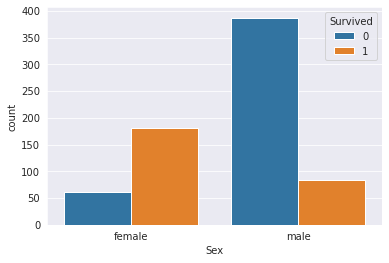

In [30]:
# check survival rate by sex
sns.countplot(data=df_train,x=df_train['Sex'],hue='Survived');
# sex tends to have an effect on the survival rate

In [31]:
# For women in the first and second class the probability to survive is very high.
# However, the social-economic status has a stronger influence than the sex.
df_train.groupby(['Sex','Pclass','Survived']).size().unstack('Survived')

Survived         0   1
Sex    Pclass         
female 1         2  71
       2         6  61
       3        54  48
male   1        61  35
       2        79  12
       3       247  36

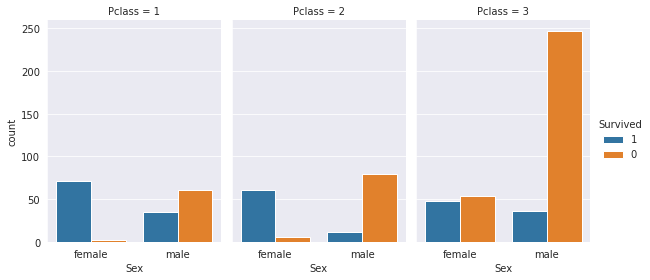

In [32]:
sns.catplot(data=df_train,x="Sex",hue="Survived",col="Pclass", kind="count", height=4, aspect=.7, hue_order=[1,0])

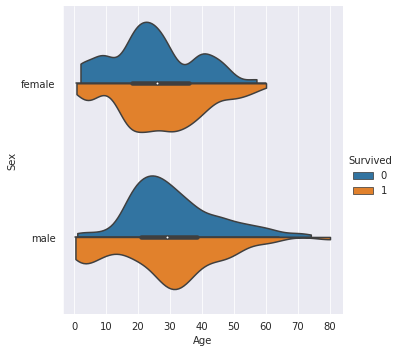

In [33]:
sns.catplot(data=df_train, x="Age", y="Sex", hue="Survived", kind="violin", bw=.25, cut=0, split=True)

##### Step 3.2.5 - Age

In [34]:
# min age and max age
max_age = df_train["Age"].max()
min_age = df_train["Age"].min()

print(
        'max Age: ', max_age,  '\n'
      , 'min Age: ', min_age
)

max Age:  80.0 
 min Age:  0.42


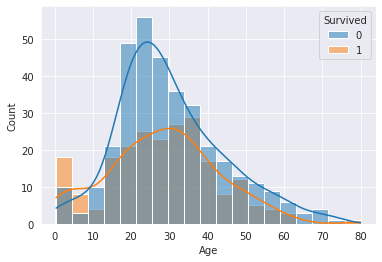

In [35]:
# The distribution of the age shows that certain age groups, especially in the range from approx. 17 to 30 
# have a relativly low probalitiy to survive as well es the elder passengers (50+)
sns.histplot(data=df_train,x=df_train['Age'],hue='Survived', stat='count', kde=True);

##### Step 3.2.6 - SibSp

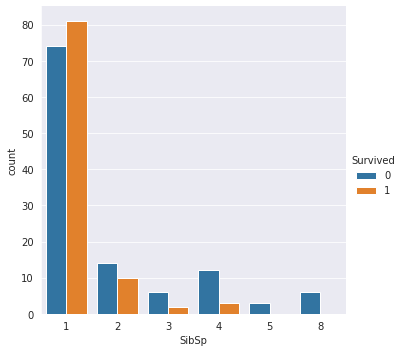

In [36]:
# Passengers with one or maximum two SibSp on board survived far mor often than those with 2+ SibSp on board 
sns.catplot(data=df_train[df_train['SibSp'] > 0], kind='count', x='SibSp', hue='Survived');

In [37]:
df_train.groupby(['SibSp','Survived']).size().unstack('Survived')

Survived,0,1
SibSp,,
0,334.0,167.0
1,74.0,81.0
2,14.0,10.0
3,6.0,2.0
4,12.0,3.0
5,3.0,NaN
8,6.0,NaN


##### Step 3.2.7 - Parch

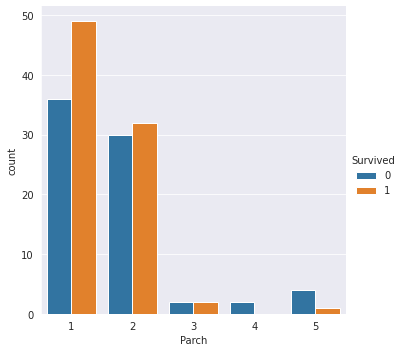

In [38]:
# the parent-child relation on board also of a strong influence on the survival rate
sns.catplot(data=df_train[df_train['Parch'] > 0], kind='count', x='Parch', hue='Survived');

In [39]:
# Parch: # of parents / children aboard the Titanic
df_train["Parch"].unique()

array([2, 0, 1, 3, 4, 5])

##### Step 3.2.8 - Ticket

In [40]:
# Do ticket numbers occur more than once? 
# Probalbly some passengers travel on one ticket (eg family tickets)
df_train.groupby(['Ticket'])[['Ticket']].count()

,Ticket
Ticket,
110152,3
110413,3
110465,2
110564,1
110813,1
...,...
W./C. 14263,1
W./C. 6608,4
W.E.P. 5734,1


In [41]:
df_train['occ_of_ticket'] = df_train.groupby(['Ticket'])['Ticket'].transform('count')
df_train.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Lastname,title_and_firstname,occ_of_ticket
PassengerId,,,,,,,,,,,,,,,
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,Mrs.,Johnson,Mrs. Oscar W (Elisabeth Vilhelmina Berg),2
151,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,0,Rev.,Bateman,Rev. Robert James,1
222,2,"Bracken, Mr. James H",male,27.0,0,0,220367,13.0000,NaN,S,0,Mr.,Bracken,Mr. James H,1


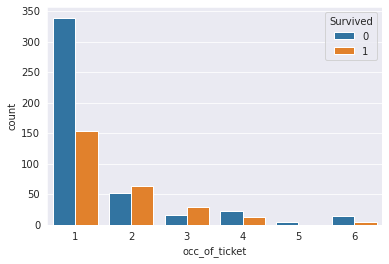

In [42]:
# Tickets that are connected to two or three persons seem to increase the probabilty to survive.
sns.countplot(data=df_train,x=df_train['occ_of_ticket'],hue='Survived');

##### Step 3.2.9 - Fare

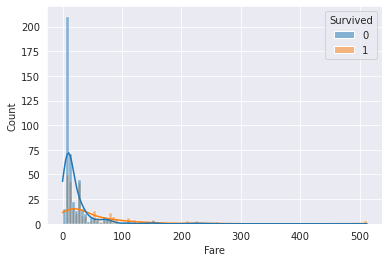

In [43]:
# Distribution of the fare and plotting survived and not survived.
# The more expensive the fare the higher the chances to survive
sns.histplot(data=df_train,x=df_train['Fare'],hue='Survived', stat='count', kde=True);

##### Step 3.2.10 - Cabin

In [44]:
df_train[df_train["Cabin"].notnull()][["Cabin"]]

,Cabin
PassengerId,
450,C104
340,T
171,B19
497,D20
557,A16
...,...
292,B49
270,C99
631,A23


In [45]:
# It could be an approach to use the letter code, 
# which could possibly indicate the deck or any other location on the titanic
df_train["Cabin"] = df_train["Cabin"].str.replace('\d+', '')
df_train["Cabin"] = df_train["Cabin"].str.replace(' ', '')
df_train.rename(columns={'Cabin':'Cabin_Category'}, inplace=True)

df_train[df_train["Cabin_Category"].notnull()][["Cabin_Category"]]

,Cabin_Category
PassengerId,
450,C
340,T
171,B
497,D
557,A
...,...
292,B
270,C
631,A


In [46]:
df_train["Cabin_Category"].unique()

array([nan, 'C', 'T', 'B', 'D', 'A', 'E', 'BBBB', 'BB', 'BBB', 'G', 'F',
       'CC', 'FE', 'FG'], dtype=object)

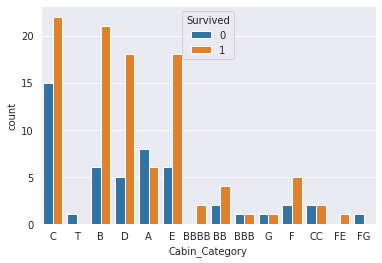

In [47]:
# Having a cabin leads mostly to a higher probabilty to survive, especially for the cabin categories B, D, E and F
sns.countplot(  data  = df_train
              , x     = df_train['Cabin_Category']
              , hue   = 'Survived'
             ); 

##### Step 3.2.11 - Embarked

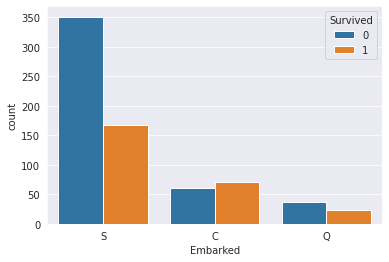

In [48]:
# Who embarked in S, C and Q? Did in C embark mainly blue collar?
sns.countplot(  data  = df_train
              , x     = df_train['Embarked']
              , hue   = 'Survived'
             ); 

##### Step 3.2.12 - Survived

<AxesSubplot:xlabel='Survived', ylabel='count'>

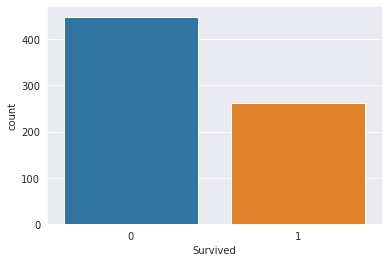

In [49]:
# Are we dealing with imbalanced data?
sns.countplot(x=df_train["Survived"]) 
# data is only slightly imbalanced

### **Conclusion from the EDA**

<hr style="border:2px solid black">

	- Embarked: impute missing vaalues with mode, encoding

    - Age: impute missing values by mean grouped by Pclass and Sex, remove outliers, standardize, dicretize (5 years)

    - Fare: impute missing values with mean grouped by Pclass and Embarked, standardize

	- Cabin: impute missing values with "-", extract the cabon category, encoding

	- Name: extract the title, encoding 

	- Tickets: count no of ticket occurences, encoding

	- Pclass: encoding 

	- SibSp: encoding

	- Sex: encoding

	- Parch: encoding

	- Survived: balance the response variable with SMOTE (not for the baseline model)

	- use a random forest as a baseline model and get the feature importance

<hr style="border:2px solid black">

### Step 4 - cleaning & scaling

   - *Fix or remove outliers (otional).*
   - *Fill in missing values (e.g. with zero, mean, median ...) or drop their rows (or columns).*
   - *Standadize or nomalize features*

#### Step 4.1 - impute missing values

**Embarked**

In [50]:
# Embarked: impute missing values with mode 
def embarked_imp(dataframe):
    dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0], inplace=True)
    return dataframe

**Age**

In [51]:
# Age: impute missing values with mean grouped by Pclass and Sex
def age_imp(dataframe):
    groupmeans = dataframe.groupby(['Sex','Pclass'])['Age'].transform('mean')
    dataframe['Age'].fillna(groupmeans, inplace=True)
    return dataframe

**Fare**

In [52]:
# Fare: impute missing values with mean grouped by Pclass and Embarked
def fare_imp(dataframe):
    groupmeans = dataframe.groupby(['Embarked','Pclass'])['Age'].transform('mean')
    dataframe['Fare'].fillna(groupmeans, inplace=True)
    return dataframe

**Cabin**

In [53]:
# Cabin: impute missing values with '-'
def cabin_imp(dataframe):
    dataframe['Cabin'].fillna('-', inplace=True)
    return dataframe

#### Step 4.2 - scaling

In [54]:
################################################################################
### list of numeric features that will be needed for the numeric transformer ###
################################################################################
def num_feat(dataframe):
    cols_to_remove = ['PassengerId','Survived','Name','Ticket','title_and_firstname','Lastname']

    numerical_features = list(dataframe.select_dtypes(include=['float64']).columns)
    numerical_features = [col for col in numerical_features if col not in cols_to_remove]
    return numerical_features 

In [55]:
numerical_features = ['Age', 'Fare', 'Fare_log']

In [56]:
# standard scaler and simple imputer for floats (in case the test or production data contain missing data that couldn't be spotted during the training)
numeric_steps =     [('imputer' , SimpleImputer(strategy = 'mean')), 
                     ('scaler'  , StandardScaler()                )     
                    ]

numeric_transformer = Pipeline(numeric_steps)

#### Step 4.3 - interpolation

In [57]:
# not needed, because no time series

#### Step 4.4 - remove duplicates and outliers

In [58]:
def drop_dupl(dataframe):
    dataframe.drop_duplicates(inplace=True)
    return dataframe

**Age**

In [59]:
# remove data points that are 3sd+ from Age with z-score
def age_zscore(dataframe):
    z = np.abs(stats.zscore(dataframe['Age']))
    outlier = list(np.where(z > 3)[0])
    dataframe.drop(dataframe.index[outlier], inplace=True)
    return dataframe

### Step 5 - feature engineering

   - *Discretize continious features.*
   - *Decompose features (e.g. categorical, date/time, etc.).*
   - *Add promising transformations of features (e.g. log(x), sqrt(x), x^2, etc.).*
   - *Aggregate features into promising new features.*

#### Step 5.1 - feature extraction, decomposition and transformation

In [60]:
def name_extract(dataframe):
    df_names = dataframe["Name"].str.split(',', expand=True)
    df_names.rename(columns={0:'Lastname', 1:'title_and_firstname'}, inplace=True)
    
    df_titles = df_names["title_and_firstname"].str.split(' ', expand=True)
    df_titles.rename(columns={1:'Title'}, inplace=True)
    df_titles = df_titles[["Title"]]

    dataframe = pd.concat([dataframe, df_names, df_titles], axis=1)
    return dataframe

In [61]:
def fare_log(dataframe):
    dataframe['Fare_log'] = np.log(dataframe['Fare'], where = dataframe['Fare'] > 0)
    return dataframe

In [62]:
def cabin_extract(dataframe):
    dataframe["Cabin"] = dataframe["Cabin"].str.replace('\d+', '')
    dataframe["Cabin"] = dataframe["Cabin"].str.replace(' ', '')
    dataframe.rename(columns={'Cabin':'Cabin_Category'}, inplace=True)
    return dataframe

In [63]:
def ticket_occ(dataframe):
    dataframe['occ_of_ticket'] = dataframe.groupby(['Ticket'])['Ticket'].transform('count')
    return dataframe

#### Step 5.2 - encoding of categorical features

In [64]:
####################################################################################
### list of categorical features that will be needed for the numeric transformer ###
####################################################################################
def cat_feat(dataframe):
    cols_to_remove = ['PassengerId','Survived','Name','Ticket','title_and_firstname','Lastname']

    categorical_features = list(dataframe.select_dtypes(include=['int64','object']).columns)
    categorical_features = [col for col in categorical_features if col not in cols_to_remove]
    return categorical_features 

In [65]:
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin_Category', 'Embarked', 'Title', 'occ_of_ticket']

In [66]:
# standard scaler and simple imputer for floats (in case the test or production data contain missing data that couldn't be spotted during the training)
categorical_steps = [('imputer' , SimpleImputer(strategy       = 'most_frequent' )),
                     ('onehot'  , OneHotEncoder(handle_unknown = 'ignore'        ))
                    ]

categorical_transformer = Pipeline(categorical_steps)

#### Step 5.3 - discretizing of continious features

In [67]:
# dicetize the age into bins of five years
discretizer_step        = [('discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='quantile', dtype=None, subsample='warn', random_state=None))]

discretizer_transformer = Pipeline(discretizer_step)

#### Step 5.4 - drop features

In [68]:
def drop_feat(dataframe):
    cols_to_remove = ['PassengerId','Survived','Name','Ticket','title_and_firstname','Lastname']
    dataframe.drop([x for x in cols_to_remove if x in dataframe.columns], axis=1, inplace=True)
    return dataframe

#### Step 5.5 - sampling strategy in case of imbalanced data

In [69]:
sample_step = [('smote', SMOTE(random_state=11))]

sample_transformer = Pipeline(sample_step)

#### Step 5.6 - implement polynomials

In [70]:
# not needed

### Step 6 - baseline model

#### Step 6.1 - create pipeline for the baseline model 

##### Step 6.1.1 - function and column transformer

In [71]:
# imputing 
embarked_transformer      = FunctionTransformer(embarked_imp)
age_transformer           = FunctionTransformer(age_imp)
fare_transformer          = FunctionTransformer(fare_imp)
cabin_transformer         = FunctionTransformer(cabin_imp)

# cleaning and preprocessing
num_feat_transformer      = FunctionTransformer(num_feat)
cat_feat_transformer      = FunctionTransformer(cat_feat)
drop_dupl_transformer     = FunctionTransformer(drop_dupl)

# extractions and transformations
name_extract_transformer  = FunctionTransformer(name_extract)
fare_log_transformer      = FunctionTransformer(fare_log)
cabin_extract_transformer = FunctionTransformer(cabin_extract)
ticket_occ_transformer    = FunctionTransformer(ticket_occ)

# drop features
drop_feat_transformer     = FunctionTransformer(drop_feat)

# column transformer
col_transformer = ColumnTransformer(transformers = [
                                                      ('numeric'     ,     numeric_transformer , numerical_features   )
                                                    , ('categorical' , categorical_transformer , categorical_features )
                                                    , ('discretizer' , discretizer_transformer , numerical_features   )
                                                   ] 
                                   )

##### Step 6.1.2 - set up pipeline with estimators

In [72]:
class DummyEstimator(BaseEstimator):
    def fit(self):   pass
    def score(self): pass

In [73]:
pipeline = imbpipeline([
						# imputing 
						  ( 'embarked_transformer'				, embarked_transformer			)
						, ( 'age_transformer'					, age_transformer				)
						, ( 'fare_transformer'					, fare_transformer				)
						, ( 'cabin_transformer'					, cabin_transformer				)

						# cleaning
						, ( 'drop_dupl_transformer'				, drop_dupl_transformer			)

						# extractions and transformations
						, ( 'name_extract_transformer'			, name_extract_transformer		)
						, ( 'fare_log_transformer'				, fare_log_transformer			)
						, ( 'cabin_extract_transformer'			, cabin_extract_transformer		)
						, ( 'ticket_occ_transformer'			, ticket_occ_transformer		)
    
						# drop features
						, ( 'drop_feat_transformer'				, drop_feat_transformer			)

						# column transformer
						, ( 'col_transformer'					, col_transformer				)

						# sampling
						, ( 'smote'								, SMOTE()						)

						# 
						, ('selector'							, SelectKBest(f_classif)		)
    
						# my estimator ...
						, ( 'classifier'						, DummyEstimator()				)

					])

In [74]:
pipeline.named_steps;

In [75]:
pipeline.get_params().keys();

##### Step 6.1.3 - define the hyperparameter grid

In [76]:
hyperparam_grid = [
                  {
                      'smote__sampling_strategy'    : [0.9]
                      
                    , 'classifier'                  : [RandomForestClassifier()]
                    , 'classifier__n_estimators'    : [5,20,30]
                    , 'classifier__min_samples_leaf': [5,10,15]
                      
                    , 'selector__k'                 : [10,15,20]
                  }
]

##### Step 6.1.4 - set up the grid search CV

In [77]:
scoring = {
                  "AUC"       : "roc_auc"
                , "Accuracy"  : make_scorer(accuracy_score)
                , "Precision" : make_scorer(precision_score)
                , "Recall"    : make_scorer(recall_score)
                , "F1-Score"  : make_scorer(f1_score)
}

In [78]:
stratified_kfold = StratifiedKFold(
                                    n_splits     = 5
                                  , shuffle      = True
                                  , random_state = 11
)

In [79]:
gs = GridSearchCV(
                      estimator          = pipeline 
                    , param_grid         = hyperparam_grid                    
                    , cv                 = stratified_kfold
                    , scoring            = scoring
                    , refit              = "AUC"
                    , return_train_score = True
                 )

#### Step 6.2 - run the baseline model

Explanation:

- **values** will give the values in a numpy array (shape: (n,1))

- **ravel** will convert that array shape to (n, ) (i.e. flatten it)

In [80]:
grid_search = gs.fit(X_train, y_train.values.ravel());

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

#### Step 6.3 - evaluate the model

In [81]:
pd.set_option('display.max_rows'   , 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width'      , 1000)

pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_Accuracy').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__min_samples_leaf,param_classifier__n_estimators,param_selector__k,param_smote__sampling_strategy,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,mean_train_AUC,std_train_AUC,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy,split0_test_Precision,split1_test_Precision,split2_test_Precision,split3_test_Precision,split4_test_Precision,mean_test_Precision,std_test_Precision,rank_test_Precision,split0_train_Precision,split1_train_Precision,split2_train_Precision,split3_train_Precision,split4_train_Precision,mean_train_Precision,std_train_Precision,split0_test_Recall,split1_test_Recall,split2_test_Recall,split3_test_Recall,split4_test_Recall,mean_test_Recall,std_test_Recall,rank_test_Recall,split0_train_Recall,split1_train_Recall,split2_train_Recall,split3_train_Recall,split4_train_Recall,mean_train_Recall,std_train_Recall,split0_test_F1-Score,split1_test_F1-Score,split2_test_F1-Score,split3_test_F1-Score,split4_test_F1-Score,mean_test_F1-Score,std_test_F1-Score,rank_test_F1-Score,split0_train_F1-Score,split1_train_F1-Score,split2_train_F1-Score,split3_train_F1-Score,split4_train_F1-Score,mean_train_F1-Score,std_train_F1-Score
6,0.068869,0.001451,0.059487,0.002410,"RandomForestClassifier(min_samples_leaf=5, n_e...",5,30,10,0.9,{'classifier': RandomForestClassifier(min_samp...,0.853040,0.854507,0.872377,0.881731,0.814957,0.855322,0.022906,6,0.920805,0.925202,0.911237,0.921194,0.916877,0.919063,0.004718,0.818182,0.825175,0.830986,0.809859,0.795775,0.815995,0.012331,1,0.857645,0.875220,0.849123,0.852632,0.852632,0.857450,0.009291,0.754717,0.780000,0.773585,0.727273,0.716981,0.750511,0.024835,4,0.811594,0.852792,0.819588,0.819095,0.784753,0.817565,0.021724,0.754717,0.735849,0.773585,0.769231,0.730769,0.752830,0.017195,1,0.800000,0.800000,0.757143,0.772512,0.829384,0.791808,0.024981,0.754717,0.757282,0.773585,0.747664,0.723810,0.751411,0.016205,1,0.805755,0.825553,0.787129,0.795122,0.806452,0.804002,0.012939
0,0.049820,0.012883,0.055878,0.001350,"RandomForestClassifier(min_samples_leaf=5, n_e...",5,5,10,0.9,{'classifier': RandomForestClassifier(min_samp...,0.841300,0.860273,0.863155,0.864637,0.814637,0.848800,0.019036,16,0.902872,0.913430,0.917282,0.917207,0.903312,0.910821,0.006464,0.797203,0.825175,0.830986,0.830986,0.774648,0.811799,0.022398,2,0.836555,0.855888,0.854386,0.850877,0.833333,0.846208,0.009395,0.740000,0.804348,0.795918,0.780000,0.717391,0.767531,0.033433,1,0.785366,0.826531,0.867052,0.808824,0.790000,0.815554,0.029605,0.698113,0.698113,0.735849,0.750000,0.634615,0.703338,0.040029,20,0.766667,0.771429,0.714286,0.781991,0.748815,0.756637,0.023736,0.718447,0.747475,0.764706,0.764706,0.673469,0.733761,0.034563,5,0.775904,0.798030,0.783290,0.795181,0.768856,0.784252,0.011108
5,0.059449,0.000788,0.057263,0.000387,"RandomForestClassifier(min_samples_leaf=5, n_e...",5,20,20,0.9,{'classifier': RandomForestClassifier(min_samp...,0.846751,0.865304,0.885732,0.879060,0.830876,0.861545,0.020324,2,0.925859,0.930409,0.924253,0.922963,0.921530,0.925003,0.003057,0.804196,0.818182,0.859155,0.781690,0.795775,0.811799,0.026474,3,0.854130,0.882250,0.877193,0.850877,0.863158,0.865522,0.012376,0.804878,0.764706,0.836735,0.684211,0.725490,0.763204,0.054421,2,0.839572,0.862944,0.880435,0.828125,0.806452,0.843506,0.025949,0.622642,0.735849,0.773585,0.750000,0.711538,0.718723,0.052086,13,0.747619,0.809524,0.771429,0.753555,0.829384,0.782302,0.031954,0.702128,0.750000,0.803922,0.715596,0.718447,0.738018,0.036499,2,0.790932,0.835381,0.822335,

In [82]:
best_pipe = gs.best_estimator_

In [83]:
best_pipe

Pipeline(steps=[('embarked_transformer',
                 FunctionTransformer(func=<function embarked_imp at 0x7f7ad2b20310>)),
                ('age_transformer',
                 FunctionTransformer(func=<function age_imp at 0x7f7ad2b201f0>)),
                ('fare_transformer',
                 FunctionTransformer(func=<function fare_imp at 0x7f7ad2b2b280>)),
                ('cabin_transformer',
                 FunctionTransformer(func=<function cabin_imp at 0x7f7ad2b2b700>)...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Cabin_Category',
                                                   'Embarked', 'Title',
                                                   'occ_of_ticket']),
                                                 ('discretizer',
                                                  Pipeline(steps=[('discretizer',
                                                                   KBinsDiscretizer())]),
                                                  ['Age', 'Fare',
                                                   'Fare_log'])])),
                ('smote', SMOTE(sampling_strategy=0.9)),
                ('selector', SelectKBest(k=15)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=5, n_estimators=30))])

#### Step 6.4 - evaluate the feature importance

In [84]:
best_pipe.steps[-1][1].feature_importances_

array([0.1324013 , 0.07673515, 0.02091007, 0.07750006, 0.21295295,
       0.1514498 , 0.0238555 , 0.04065048, 0.02085821, 0.1881048 ,
       0.03359827, 0.00549854, 0.00553204, 0.00464605, 0.00530678])

In [85]:
# in order to evaluate the features I need the feature importance and the transformed feature names
# this will be possible with future versions
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html
# .set_output( transform = "pandas"))

#### Step 6.5 - feature selection

- *Drop the attributes that provide no useful information for the task.*

### Step 7 - model tuning

#### Step 7.1 - create a pipeline for model tuning

##### Step 7.1.1 - function transformer

In [86]:
# used from above

##### Step 7.1.2 - column transformer

In [87]:
# used from above

##### Step 7.1.3 - set up pipeline with estimators

In [88]:
tuning_pipeline = pipeline

##### Step 7.1.4 - define the hyperparameter grid

In [89]:
hyperparam_grid_tuner = [
                {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # RandomForestClassifier
                    , 'classifier'                  : [RandomForestClassifier()]
                    , 'classifier__n_estimators'    : [4,5,6]
                    , 'classifier__min_samples_leaf': [4,5,6]                  
                      
                    , 'selector__k'                 : [10,15,20]
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # LogisticRegression
                    , 'classifier'                  : [LogisticRegression()]
                    , 'classifier__penalty'         : ['l1', 'l2', 'elasticnet', None]                   
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # GradientBoostingClassifier
                    , 'classifier'                  : [GradientBoostingClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # CatBoostClassifier
                    , 'classifier'                  : [CatBoostClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # LGBMClassifier
                    , 'classifier'                  : [LGBMClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # SGDClassifier
                    , 'classifier'                  : [SGDClassifier()]
                    , 'classifier__learning_rate'   : ['optimal'] 
                    , 'classifier__penalty'         : ['l1', 'l2']
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # SGDClassifier
                    , 'classifier'                  : [XGBClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  }
]

##### Step 7.1.5 - set up the grid search CV

In [90]:
scoring_tuner = {
                  "Accuracy"  : "accuracy"
                , "AUC"       : make_scorer(roc_auc_score)
                , "Precision" : make_scorer(precision_score)
                , "Recall"    : make_scorer(recall_score)
                , "F1-Score"  : make_scorer(f1_score)
}

In [91]:
gs_tuner = GridSearchCV(
                          estimator          = tuning_pipeline 
                        , param_grid         = hyperparam_grid_tuner                    
                        , cv                 = stratified_kfold
                        , scoring            = scoring_tuner          # if multiple evaluation metrics are use, the best estimator will be something unexpected.
                        , refit              = "Accuracy"
                        , return_train_score = True
                 )

#### Step 7.2 - run the tuner model

In [92]:
grid_search_tuner = gs_tuner.fit(X_train, y_train.values.ravel());

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

0:	learn: 0.6890505	total: 48.1ms	remaining: 915ms
1:	learn: 0.6849651	total: 48.6ms	remaining: 437ms
2:	learn: 0.6813244	total: 48.9ms	remaining: 277ms
3:	learn: 0.6779974	total: 49.2ms	remaining: 197ms
4:	learn: 0.6743362	total: 49.4ms	remaining: 148ms
5:	learn: 0.6702740	total: 49.6ms	remaining: 116ms
6:	learn: 0.6670611	total: 49.8ms	remaining: 92.5ms
7:	learn: 0.6638643	total: 50ms	remaining: 75ms
8:	learn: 0.6606627	total: 50.2ms	remaining: 61.3ms
9:	learn: 0.6572254	total: 50.4ms	remaining: 50.4ms
10:	learn: 0.6542803	total: 50.6ms	remaining: 41.4ms
11:	learn: 0.6511258	total: 50.8ms	remaining: 33.9ms
12:	learn: 0.6478990	total: 51ms	remaining: 27.4ms
13:	learn: 0.6445907	total: 51.2ms	remaining: 21.9ms
14:	learn: 0.6416540	total: 51.5ms	remaining: 17.2ms
15:	learn: 0.6387832	total: 51.7ms	remaining: 12.9ms
16:	learn: 0.6357479	total: 52ms	remaining: 9.17ms
17:	learn: 0.6327664	total: 52.2ms	remaining: 5.8ms
18:	learn: 0.6298035	total: 52.5ms	remaining: 2.76ms
19:	learn: 0.62643

0:	learn: 0.6892601	total: 493us	remaining: 9.38ms
1:	learn: 0.6854544	total: 1.08ms	remaining: 9.72ms
2:	learn: 0.6815421	total: 2.2ms	remaining: 12.4ms
3:	learn: 0.6778802	total: 2.61ms	remaining: 10.4ms
4:	learn: 0.6742592	total: 3.05ms	remaining: 9.16ms
5:	learn: 0.6709462	total: 3.41ms	remaining: 7.95ms
6:	learn: 0.6676225	total: 3.79ms	remaining: 7.04ms
7:	learn: 0.6642238	total: 4.17ms	remaining: 6.26ms
8:	learn: 0.6609231	total: 4.51ms	remaining: 5.51ms
9:	learn: 0.6578250	total: 4.86ms	remaining: 4.86ms
10:	learn: 0.6548412	total: 5.19ms	remaining: 4.25ms
11:	learn: 0.6516146	total: 5.56ms	remaining: 3.71ms
12:	learn: 0.6485277	total: 5.85ms	remaining: 3.15ms
13:	learn: 0.6452105	total: 6.2ms	remaining: 2.65ms
14:	learn: 0.6421927	total: 6.52ms	remaining: 2.17ms
15:	learn: 0.6394969	total: 6.86ms	remaining: 1.71ms
16:	learn: 0.6367826	total: 7.21ms	remaining: 1.27ms
17:	learn: 0.6336964	total: 7.57ms	remaining: 840us
18:	learn: 0.6307749	total: 7.95ms	remaining: 418us
19:	lear

0:	learn: 0.6893546	total: 293us	remaining: 14.4ms
1:	learn: 0.6856009	total: 527us	remaining: 12.7ms
2:	learn: 0.6818984	total: 1.03ms	remaining: 16.1ms
3:	learn: 0.6786947	total: 1.49ms	remaining: 17.1ms
4:	learn: 0.6752191	total: 1.78ms	remaining: 16ms
5:	learn: 0.6723185	total: 2.09ms	remaining: 15.3ms
6:	learn: 0.6693054	total: 2.4ms	remaining: 14.8ms
7:	learn: 0.6658156	total: 2.68ms	remaining: 14.1ms
8:	learn: 0.6623706	total: 2.96ms	remaining: 13.5ms
9:	learn: 0.6591769	total: 3.24ms	remaining: 13ms
10:	learn: 0.6561773	total: 3.52ms	remaining: 12.5ms
11:	learn: 0.6531826	total: 3.79ms	remaining: 12ms
12:	learn: 0.6502844	total: 4.06ms	remaining: 11.6ms
13:	learn: 0.6472088	total: 4.32ms	remaining: 11.1ms
14:	learn: 0.6442688	total: 4.6ms	remaining: 10.7ms
15:	learn: 0.6417874	total: 4.84ms	remaining: 10.3ms
16:	learn: 0.6386725	total: 5.14ms	remaining: 9.97ms
17:	learn: 0.6360936	total: 5.39ms	remaining: 9.58ms
18:	learn: 0.6334807	total: 5.67ms	remaining: 9.24ms
19:	learn: 0.

0:	learn: 0.6893541	total: 381us	remaining: 18.7ms
1:	learn: 0.6858381	total: 872us	remaining: 20.9ms
2:	learn: 0.6818891	total: 1.24ms	remaining: 19.4ms
3:	learn: 0.6781729	total: 1.56ms	remaining: 18ms
4:	learn: 0.6746896	total: 1.83ms	remaining: 16.5ms
5:	learn: 0.6713555	total: 2.14ms	remaining: 15.7ms
6:	learn: 0.6682018	total: 2.45ms	remaining: 15ms
7:	learn: 0.6646888	total: 2.72ms	remaining: 14.3ms
8:	learn: 0.6613088	total: 3.02ms	remaining: 13.8ms
9:	learn: 0.6583637	total: 3.31ms	remaining: 13.2ms
10:	learn: 0.6547079	total: 3.59ms	remaining: 12.7ms
11:	learn: 0.6519921	total: 3.84ms	remaining: 12.2ms
12:	learn: 0.6489703	total: 4.1ms	remaining: 11.7ms
13:	learn: 0.6459496	total: 4.37ms	remaining: 11.2ms
14:	learn: 0.6426957	total: 4.64ms	remaining: 10.8ms
15:	learn: 0.6396364	total: 4.89ms	remaining: 10.4ms
16:	learn: 0.6370120	total: 5.19ms	remaining: 10.1ms
17:	learn: 0.6342347	total: 5.46ms	remaining: 9.71ms
18:	learn: 0.6313229	total: 5.74ms	remaining: 9.36ms
19:	learn:

0:	learn: 0.6890794	total: 428us	remaining: 21ms
1:	learn: 0.6850675	total: 846us	remaining: 20.3ms
2:	learn: 0.6810172	total: 1.13ms	remaining: 17.7ms
3:	learn: 0.6771320	total: 1.41ms	remaining: 16.2ms
4:	learn: 0.6732865	total: 1.68ms	remaining: 15.1ms
5:	learn: 0.6696618	total: 1.9ms	remaining: 13.9ms
6:	learn: 0.6662169	total: 2.19ms	remaining: 13.4ms
7:	learn: 0.6626804	total: 2.45ms	remaining: 12.9ms
8:	learn: 0.6590563	total: 2.69ms	remaining: 12.3ms
9:	learn: 0.6556265	total: 2.96ms	remaining: 11.8ms
10:	learn: 0.6521857	total: 3.25ms	remaining: 11.5ms
11:	learn: 0.6488429	total: 3.53ms	remaining: 11.2ms
12:	learn: 0.6455399	total: 3.79ms	remaining: 10.8ms
13:	learn: 0.6421232	total: 4.07ms	remaining: 10.5ms
14:	learn: 0.6391199	total: 4.33ms	remaining: 10.1ms
15:	learn: 0.6359430	total: 4.59ms	remaining: 9.75ms
16:	learn: 0.6332214	total: 4.88ms	remaining: 9.47ms
17:	learn: 0.6304736	total: 5.13ms	remaining: 9.13ms
18:	learn: 0.6273075	total: 5.42ms	remaining: 8.84ms
19:	lear

0:	learn: 0.6894639	total: 344us	remaining: 16.9ms
1:	learn: 0.6861177	total: 937us	remaining: 22.5ms
2:	learn: 0.6823387	total: 1.34ms	remaining: 21ms
3:	learn: 0.6786175	total: 1.74ms	remaining: 20ms
4:	learn: 0.6750387	total: 2.2ms	remaining: 19.8ms
5:	learn: 0.6718423	total: 2.52ms	remaining: 18.5ms
6:	learn: 0.6687065	total: 2.84ms	remaining: 17.4ms
7:	learn: 0.6653795	total: 3.2ms	remaining: 16.8ms
8:	learn: 0.6622099	total: 3.53ms	remaining: 16.1ms
9:	learn: 0.6590753	total: 3.86ms	remaining: 15.4ms
10:	learn: 0.6560585	total: 4.23ms	remaining: 15ms
11:	learn: 0.6529610	total: 4.56ms	remaining: 14.4ms
12:	learn: 0.6499232	total: 4.89ms	remaining: 13.9ms
13:	learn: 0.6469147	total: 5.24ms	remaining: 13.5ms
14:	learn: 0.6439437	total: 5.5ms	remaining: 12.8ms
15:	learn: 0.6412236	total: 5.84ms	remaining: 12.4ms
16:	learn: 0.6384110	total: 6.18ms	remaining: 12ms
17:	learn: 0.6354344	total: 6.54ms	remaining: 11.6ms
18:	learn: 0.6325169	total: 6.85ms	remaining: 11.2ms
19:	learn: 0.629

72:	learn: 0.5285761	total: 19.6ms	remaining: 7.23ms
73:	learn: 0.5271193	total: 19.9ms	remaining: 6.98ms
74:	learn: 0.5254884	total: 20.1ms	remaining: 6.72ms
75:	learn: 0.5242210	total: 20.4ms	remaining: 6.44ms
76:	learn: 0.5228092	total: 20.6ms	remaining: 6.17ms
77:	learn: 0.5214577	total: 20.9ms	remaining: 5.9ms
78:	learn: 0.5200952	total: 21.2ms	remaining: 5.62ms
79:	learn: 0.5192000	total: 21.4ms	remaining: 5.35ms
80:	learn: 0.5181147	total: 21.7ms	remaining: 5.08ms
81:	learn: 0.5169566	total: 21.9ms	remaining: 4.8ms
82:	learn: 0.5159440	total: 22.4ms	remaining: 4.59ms
83:	learn: 0.5148143	total: 22.7ms	remaining: 4.32ms
84:	learn: 0.5134384	total: 22.9ms	remaining: 4.05ms
85:	learn: 0.5125863	total: 23.2ms	remaining: 3.77ms
86:	learn: 0.5113659	total: 23.4ms	remaining: 3.5ms
87:	learn: 0.5101785	total: 23.6ms	remaining: 3.22ms
88:	learn: 0.5090390	total: 23.8ms	remaining: 2.95ms
89:	learn: 0.5080624	total: 24.1ms	remaining: 2.67ms
90:	learn: 0.5067925	total: 24.3ms	remaining: 2.4

76:	learn: 0.5214883	total: 20.8ms	remaining: 6.22ms
77:	learn: 0.5201984	total: 21.1ms	remaining: 5.96ms
78:	learn: 0.5188802	total: 21.4ms	remaining: 5.68ms
79:	learn: 0.5175981	total: 21.6ms	remaining: 5.4ms
80:	learn: 0.5164603	total: 21.9ms	remaining: 5.13ms
81:	learn: 0.5153014	total: 22.1ms	remaining: 4.85ms
82:	learn: 0.5140349	total: 22.4ms	remaining: 4.58ms
83:	learn: 0.5128100	total: 22.6ms	remaining: 4.31ms
84:	learn: 0.5116276	total: 22.9ms	remaining: 4.04ms
85:	learn: 0.5103007	total: 23.2ms	remaining: 3.77ms
86:	learn: 0.5090080	total: 23.4ms	remaining: 3.5ms
87:	learn: 0.5078582	total: 23.6ms	remaining: 3.22ms
88:	learn: 0.5067576	total: 23.9ms	remaining: 2.95ms
89:	learn: 0.5059118	total: 24.1ms	remaining: 2.68ms
90:	learn: 0.5047947	total: 24.4ms	remaining: 2.41ms
91:	learn: 0.5037609	total: 24.6ms	remaining: 2.14ms
92:	learn: 0.5027997	total: 24.9ms	remaining: 1.87ms
93:	learn: 0.5017610	total: 25.1ms	remaining: 1.6ms
94:	learn: 0.5007754	total: 25.3ms	remaining: 1.3

0:	learn: 0.6892708	total: 384us	remaining: 38.1ms
1:	learn: 0.6854093	total: 657us	remaining: 32.2ms
2:	learn: 0.6816499	total: 946us	remaining: 30.6ms
3:	learn: 0.6781746	total: 1.23ms	remaining: 29.4ms
4:	learn: 0.6745710	total: 1.48ms	remaining: 28.2ms
5:	learn: 0.6713075	total: 1.75ms	remaining: 27.4ms
6:	learn: 0.6678493	total: 2.03ms	remaining: 27ms
7:	learn: 0.6642886	total: 2.28ms	remaining: 26.2ms
8:	learn: 0.6610524	total: 2.56ms	remaining: 25.9ms
9:	learn: 0.6577302	total: 2.84ms	remaining: 25.6ms
10:	learn: 0.6541720	total: 3.13ms	remaining: 25.3ms
11:	learn: 0.6508048	total: 3.39ms	remaining: 24.9ms
12:	learn: 0.6475827	total: 3.67ms	remaining: 24.5ms
13:	learn: 0.6444779	total: 3.92ms	remaining: 24.1ms
14:	learn: 0.6415763	total: 4.18ms	remaining: 23.7ms
15:	learn: 0.6389935	total: 4.45ms	remaining: 23.3ms
16:	learn: 0.6358876	total: 4.7ms	remaining: 23ms
17:	learn: 0.6329074	total: 4.92ms	remaining: 22.4ms
18:	learn: 0.6299858	total: 5.21ms	remaining: 22.2ms
19:	learn: 

0:	learn: 0.6893320	total: 415us	remaining: 41.2ms
1:	learn: 0.6854830	total: 1.01ms	remaining: 49.4ms
2:	learn: 0.6818489	total: 1.45ms	remaining: 46.8ms
3:	learn: 0.6778305	total: 1.8ms	remaining: 43.2ms
4:	learn: 0.6742173	total: 2.12ms	remaining: 40.3ms
5:	learn: 0.6708568	total: 2.47ms	remaining: 38.7ms
6:	learn: 0.6677350	total: 2.8ms	remaining: 37.3ms
7:	learn: 0.6641460	total: 3.12ms	remaining: 35.9ms
8:	learn: 0.6608126	total: 3.48ms	remaining: 35.1ms
9:	learn: 0.6575134	total: 3.78ms	remaining: 34ms
10:	learn: 0.6536689	total: 4.1ms	remaining: 33.2ms
11:	learn: 0.6509441	total: 4.41ms	remaining: 32.3ms
12:	learn: 0.6482331	total: 4.71ms	remaining: 31.5ms
13:	learn: 0.6450060	total: 5.03ms	remaining: 30.9ms
14:	learn: 0.6418406	total: 5.35ms	remaining: 30.3ms
15:	learn: 0.6388188	total: 5.65ms	remaining: 29.7ms
16:	learn: 0.6359350	total: 5.95ms	remaining: 29ms
17:	learn: 0.6330901	total: 6.26ms	remaining: 28.5ms
18:	learn: 0.6301555	total: 6.5ms	remaining: 27.7ms
19:	learn: 0

98:	learn: 0.5160379	total: 26.7ms	remaining: 269us
99:	learn: 0.5149397	total: 27ms	remaining: 0us
0:	learn: 0.6895039	total: 480us	remaining: 47.6ms
1:	learn: 0.6858071	total: 927us	remaining: 45.4ms
2:	learn: 0.6824041	total: 1.29ms	remaining: 41.7ms
3:	learn: 0.6788758	total: 1.64ms	remaining: 39.5ms
4:	learn: 0.6755124	total: 1.98ms	remaining: 37.6ms
5:	learn: 0.6725723	total: 2.26ms	remaining: 35.3ms
6:	learn: 0.6696318	total: 2.58ms	remaining: 34.3ms
7:	learn: 0.6662835	total: 2.86ms	remaining: 32.9ms
8:	learn: 0.6631092	total: 3.17ms	remaining: 32ms
9:	learn: 0.6604398	total: 3.47ms	remaining: 31.2ms
10:	learn: 0.6578026	total: 3.79ms	remaining: 30.6ms
11:	learn: 0.6548863	total: 4.06ms	remaining: 29.8ms
12:	learn: 0.6519752	total: 4.34ms	remaining: 29.1ms
13:	learn: 0.6491123	total: 4.66ms	remaining: 28.6ms
14:	learn: 0.6461352	total: 4.97ms	remaining: 28.2ms
15:	learn: 0.6435503	total: 5.28ms	remaining: 27.7ms
16:	learn: 0.6411011	total: 5.51ms	remaining: 26.9ms
17:	learn: 0.

80:	learn: 0.5132719	total: 22.1ms	remaining: 5.18ms
81:	learn: 0.5120416	total: 22.7ms	remaining: 4.98ms
82:	learn: 0.5107332	total: 23.1ms	remaining: 4.73ms
83:	learn: 0.5095743	total: 23.6ms	remaining: 4.49ms
84:	learn: 0.5085440	total: 23.9ms	remaining: 4.22ms
85:	learn: 0.5072368	total: 24.3ms	remaining: 3.95ms
86:	learn: 0.5059603	total: 24.5ms	remaining: 3.67ms
87:	learn: 0.5048778	total: 24.8ms	remaining: 3.38ms
88:	learn: 0.5037284	total: 25.1ms	remaining: 3.1ms
89:	learn: 0.5025452	total: 25.3ms	remaining: 2.81ms
90:	learn: 0.5014461	total: 25.6ms	remaining: 2.53ms
91:	learn: 0.5003725	total: 25.8ms	remaining: 2.25ms
92:	learn: 0.4993527	total: 26.1ms	remaining: 1.96ms
93:	learn: 0.4982972	total: 26.4ms	remaining: 1.68ms
94:	learn: 0.4973420	total: 26.6ms	remaining: 1.4ms
95:	learn: 0.4961862	total: 26.9ms	remaining: 1.12ms
96:	learn: 0.4952361	total: 27.1ms	remaining: 838us
97:	learn: 0.4942405	total: 27.4ms	remaining: 558us
98:	learn: 0.4933632	total: 27.6ms	remaining: 278u

0:	learn: 0.6891498	total: 993us	remaining: 18.9ms
1:	learn: 0.6855239	total: 1.7ms	remaining: 15.3ms
2:	learn: 0.6819996	total: 2.39ms	remaining: 13.6ms
3:	learn: 0.6783243	total: 3ms	remaining: 12ms
4:	learn: 0.6746269	total: 3.58ms	remaining: 10.7ms
5:	learn: 0.6711205	total: 4.23ms	remaining: 9.87ms
6:	learn: 0.6676770	total: 5.04ms	remaining: 9.36ms
7:	learn: 0.6644761	total: 5.7ms	remaining: 8.54ms
8:	learn: 0.6614145	total: 6.3ms	remaining: 7.71ms
9:	learn: 0.6583960	total: 6.88ms	remaining: 6.88ms
10:	learn: 0.6555832	total: 7.55ms	remaining: 6.18ms
11:	learn: 0.6522769	total: 8.17ms	remaining: 5.45ms
12:	learn: 0.6490734	total: 8.84ms	remaining: 4.76ms
13:	learn: 0.6459952	total: 9.46ms	remaining: 4.06ms
14:	learn: 0.6430386	total: 10.1ms	remaining: 3.37ms
15:	learn: 0.6400470	total: 10.8ms	remaining: 2.71ms
16:	learn: 0.6371914	total: 11.4ms	remaining: 2.01ms
17:	learn: 0.6341803	total: 12ms	remaining: 1.33ms
18:	learn: 0.6311288	total: 12.7ms	remaining: 669us
19:	learn: 0.62

0:	learn: 0.6890614	total: 651us	remaining: 31.9ms
1:	learn: 0.6855484	total: 1.43ms	remaining: 34.2ms
2:	learn: 0.6816220	total: 2.19ms	remaining: 34.4ms
3:	learn: 0.6781032	total: 2.91ms	remaining: 33.5ms
4:	learn: 0.6746124	total: 3.44ms	remaining: 30.9ms
5:	learn: 0.6711528	total: 4.05ms	remaining: 29.7ms
6:	learn: 0.6671061	total: 4.5ms	remaining: 27.7ms
7:	learn: 0.6636035	total: 4.74ms	remaining: 24.9ms
8:	learn: 0.6605239	total: 5.12ms	remaining: 23.3ms
9:	learn: 0.6570549	total: 5.49ms	remaining: 22ms
10:	learn: 0.6536195	total: 5.85ms	remaining: 20.7ms
11:	learn: 0.6503796	total: 6.18ms	remaining: 19.6ms
12:	learn: 0.6466702	total: 6.52ms	remaining: 18.6ms
13:	learn: 0.6437738	total: 6.87ms	remaining: 17.7ms
14:	learn: 0.6406375	total: 7.2ms	remaining: 16.8ms
15:	learn: 0.6371873	total: 7.53ms	remaining: 16ms
16:	learn: 0.6338435	total: 7.88ms	remaining: 15.3ms
17:	learn: 0.6309112	total: 8.21ms	remaining: 14.6ms
18:	learn: 0.6276797	total: 8.54ms	remaining: 13.9ms
19:	learn:

41:	learn: 0.5832964	total: 19.7ms	remaining: 3.76ms
42:	learn: 0.5814684	total: 20.3ms	remaining: 3.31ms
43:	learn: 0.5796252	total: 20.8ms	remaining: 2.83ms
44:	learn: 0.5776706	total: 21.2ms	remaining: 2.36ms
45:	learn: 0.5760002	total: 21.6ms	remaining: 1.88ms
46:	learn: 0.5740727	total: 22ms	remaining: 1.41ms
47:	learn: 0.5723469	total: 22.4ms	remaining: 934us
48:	learn: 0.5706528	total: 22.8ms	remaining: 466us
49:	learn: 0.5687071	total: 23.2ms	remaining: 0us
0:	learn: 0.6896062	total: 960us	remaining: 47.1ms
1:	learn: 0.6858583	total: 1.8ms	remaining: 43.2ms
2:	learn: 0.6822212	total: 2.63ms	remaining: 41.2ms
3:	learn: 0.6784124	total: 3.52ms	remaining: 40.5ms
4:	learn: 0.6749018	total: 3.92ms	remaining: 35.2ms
5:	learn: 0.6719422	total: 4.22ms	remaining: 31ms
6:	learn: 0.6682474	total: 4.98ms	remaining: 30.6ms
7:	learn: 0.6649705	total: 5.63ms	remaining: 29.6ms
8:	learn: 0.6617371	total: 6.32ms	remaining: 28.8ms
9:	learn: 0.6583956	total: 6.98ms	remaining: 27.9ms
10:	learn: 0.6

0:	learn: 0.6893594	total: 886us	remaining: 43.4ms
1:	learn: 0.6856931	total: 1.84ms	remaining: 44.3ms
2:	learn: 0.6820524	total: 2.71ms	remaining: 42.4ms
3:	learn: 0.6780237	total: 3.5ms	remaining: 40.3ms
4:	learn: 0.6741360	total: 4.12ms	remaining: 37.1ms
5:	learn: 0.6703130	total: 4.83ms	remaining: 35.4ms
6:	learn: 0.6666139	total: 5.76ms	remaining: 35.4ms
7:	learn: 0.6631410	total: 6.67ms	remaining: 35ms
8:	learn: 0.6600004	total: 7.38ms	remaining: 33.6ms
9:	learn: 0.6565156	total: 8.07ms	remaining: 32.3ms
10:	learn: 0.6530145	total: 8.76ms	remaining: 31.1ms
11:	learn: 0.6498267	total: 9.33ms	remaining: 29.6ms
12:	learn: 0.6466574	total: 9.88ms	remaining: 28.1ms
13:	learn: 0.6435042	total: 10.5ms	remaining: 27.1ms
14:	learn: 0.6403919	total: 11.1ms	remaining: 26ms
15:	learn: 0.6375719	total: 11.6ms	remaining: 24.7ms
16:	learn: 0.6344635	total: 12.3ms	remaining: 23.9ms
17:	learn: 0.6314426	total: 13ms	remaining: 23.1ms
18:	learn: 0.6285825	total: 13.6ms	remaining: 22.2ms
19:	learn: 

0:	learn: 0.6893696	total: 968us	remaining: 47.5ms
1:	learn: 0.6853670	total: 1.73ms	remaining: 41.6ms
2:	learn: 0.6813622	total: 2.24ms	remaining: 35.1ms
3:	learn: 0.6773524	total: 2.75ms	remaining: 31.6ms
4:	learn: 0.6733627	total: 3.22ms	remaining: 29ms
5:	learn: 0.6694391	total: 3.71ms	remaining: 27.2ms
6:	learn: 0.6660640	total: 4.15ms	remaining: 25.5ms
7:	learn: 0.6624272	total: 4.67ms	remaining: 24.5ms
8:	learn: 0.6592483	total: 5.12ms	remaining: 23.3ms
9:	learn: 0.6556242	total: 5.59ms	remaining: 22.4ms
10:	learn: 0.6521524	total: 6.05ms	remaining: 21.4ms
11:	learn: 0.6488772	total: 6.54ms	remaining: 20.7ms
12:	learn: 0.6459060	total: 7.03ms	remaining: 20ms
13:	learn: 0.6427425	total: 7.55ms	remaining: 19.4ms
14:	learn: 0.6397328	total: 8.06ms	remaining: 18.8ms
15:	learn: 0.6366988	total: 8.54ms	remaining: 18.2ms
16:	learn: 0.6336374	total: 9.04ms	remaining: 17.5ms
17:	learn: 0.6304707	total: 9.53ms	remaining: 16.9ms
18:	learn: 0.6275065	total: 10ms	remaining: 16.4ms
19:	learn:

24:	learn: 0.6149849	total: 12.2ms	remaining: 36.7ms
25:	learn: 0.6125890	total: 12.6ms	remaining: 35.8ms
26:	learn: 0.6099721	total: 12.9ms	remaining: 35ms
27:	learn: 0.6073773	total: 13.3ms	remaining: 34.1ms
28:	learn: 0.6049687	total: 13.6ms	remaining: 33.3ms
29:	learn: 0.6025232	total: 13.9ms	remaining: 32.5ms
30:	learn: 0.6000533	total: 14.3ms	remaining: 31.8ms
31:	learn: 0.5977044	total: 14.6ms	remaining: 31ms
32:	learn: 0.5952045	total: 15ms	remaining: 30.4ms
33:	learn: 0.5932955	total: 15.2ms	remaining: 29.6ms
34:	learn: 0.5912614	total: 15.6ms	remaining: 28.9ms
35:	learn: 0.5889418	total: 15.9ms	remaining: 28.4ms
36:	learn: 0.5869634	total: 16.3ms	remaining: 27.8ms
37:	learn: 0.5847617	total: 16.7ms	remaining: 27.2ms
38:	learn: 0.5827191	total: 17ms	remaining: 26.6ms
39:	learn: 0.5805537	total: 17.3ms	remaining: 26ms
40:	learn: 0.5787548	total: 18.8ms	remaining: 27.1ms
41:	learn: 0.5769217	total: 19.2ms	remaining: 26.6ms
42:	learn: 0.5748846	total: 19.7ms	remaining: 26.1ms
43:

36:	learn: 0.5865347	total: 26.6ms	remaining: 45.4ms
37:	learn: 0.5840912	total: 27.4ms	remaining: 44.7ms
38:	learn: 0.5819763	total: 28ms	remaining: 43.8ms
39:	learn: 0.5798016	total: 28.7ms	remaining: 43ms
40:	learn: 0.5780264	total: 29.5ms	remaining: 42.4ms
41:	learn: 0.5762155	total: 30.4ms	remaining: 41.9ms
42:	learn: 0.5741473	total: 31ms	remaining: 41.1ms
43:	learn: 0.5720282	total: 31.5ms	remaining: 40.2ms
44:	learn: 0.5700903	total: 32.1ms	remaining: 39.3ms
45:	learn: 0.5680639	total: 32.7ms	remaining: 38.4ms
46:	learn: 0.5662676	total: 33.4ms	remaining: 37.6ms
47:	learn: 0.5644298	total: 34ms	remaining: 36.8ms
48:	learn: 0.5625006	total: 34.6ms	remaining: 36ms
49:	learn: 0.5607022	total: 35.2ms	remaining: 35.2ms
50:	learn: 0.5590911	total: 35.8ms	remaining: 34.4ms
51:	learn: 0.5574257	total: 36.5ms	remaining: 33.7ms
52:	learn: 0.5557514	total: 37.1ms	remaining: 32.9ms
53:	learn: 0.5539021	total: 37.8ms	remaining: 32.2ms
54:	learn: 0.5523624	total: 38.3ms	remaining: 31.3ms
55:

53:	learn: 0.5511537	total: 25.2ms	remaining: 21.5ms
54:	learn: 0.5492493	total: 25.6ms	remaining: 20.9ms
55:	learn: 0.5475902	total: 25.9ms	remaining: 20.3ms
56:	learn: 0.5457976	total: 26.2ms	remaining: 19.8ms
57:	learn: 0.5441342	total: 26.6ms	remaining: 19.3ms
58:	learn: 0.5424303	total: 26.9ms	remaining: 18.7ms
59:	learn: 0.5407114	total: 27.3ms	remaining: 18.2ms
60:	learn: 0.5391861	total: 27.6ms	remaining: 17.6ms
61:	learn: 0.5375741	total: 28.4ms	remaining: 17.4ms
62:	learn: 0.5357841	total: 28.8ms	remaining: 16.9ms
63:	learn: 0.5339231	total: 29.2ms	remaining: 16.4ms
64:	learn: 0.5323935	total: 29.6ms	remaining: 15.9ms
65:	learn: 0.5309946	total: 30ms	remaining: 15.5ms
66:	learn: 0.5294999	total: 30.4ms	remaining: 15ms
67:	learn: 0.5278505	total: 30.7ms	remaining: 14.5ms
68:	learn: 0.5262924	total: 31.1ms	remaining: 14ms
69:	learn: 0.5248024	total: 31.5ms	remaining: 13.5ms
70:	learn: 0.5234261	total: 31.8ms	remaining: 13ms
71:	learn: 0.5219994	total: 32.2ms	remaining: 12.5ms
7

0:	learn: 0.6893446	total: 786us	remaining: 77.9ms
1:	learn: 0.6856798	total: 1.58ms	remaining: 77.5ms
2:	learn: 0.6822793	total: 2.13ms	remaining: 68.8ms
3:	learn: 0.6788147	total: 2.65ms	remaining: 63.7ms
4:	learn: 0.6751824	total: 3.14ms	remaining: 59.7ms
5:	learn: 0.6719290	total: 3.67ms	remaining: 57.5ms
6:	learn: 0.6682440	total: 4.11ms	remaining: 54.6ms
7:	learn: 0.6649205	total: 4.57ms	remaining: 52.6ms
8:	learn: 0.6613773	total: 5.05ms	remaining: 51ms
9:	learn: 0.6581939	total: 5.5ms	remaining: 49.5ms
10:	learn: 0.6550302	total: 5.95ms	remaining: 48.2ms
11:	learn: 0.6520068	total: 6.41ms	remaining: 47ms
12:	learn: 0.6488762	total: 6.89ms	remaining: 46.1ms
13:	learn: 0.6458232	total: 7.34ms	remaining: 45.1ms
14:	learn: 0.6429716	total: 7.82ms	remaining: 44.3ms
15:	learn: 0.6402658	total: 8.27ms	remaining: 43.4ms
16:	learn: 0.6371902	total: 8.76ms	remaining: 42.8ms
17:	learn: 0.6341979	total: 9.21ms	remaining: 41.9ms
18:	learn: 0.6311188	total: 9.66ms	remaining: 41.2ms
19:	learn

46:	learn: 0.5670362	total: 22.6ms	remaining: 25.5ms
47:	learn: 0.5652576	total: 23.2ms	remaining: 25.1ms
48:	learn: 0.5633032	total: 23.6ms	remaining: 24.6ms
49:	learn: 0.5615445	total: 24.1ms	remaining: 24.1ms
50:	learn: 0.5598934	total: 24.5ms	remaining: 23.6ms
51:	learn: 0.5582712	total: 25ms	remaining: 23.1ms
52:	learn: 0.5566184	total: 25.4ms	remaining: 22.6ms
53:	learn: 0.5549875	total: 25.9ms	remaining: 22.1ms
54:	learn: 0.5534238	total: 26.4ms	remaining: 21.6ms
55:	learn: 0.5515267	total: 26.8ms	remaining: 21.1ms
56:	learn: 0.5497766	total: 27.3ms	remaining: 20.6ms
57:	learn: 0.5482452	total: 27.7ms	remaining: 20.1ms
58:	learn: 0.5468470	total: 28.1ms	remaining: 19.6ms
59:	learn: 0.5449941	total: 28.6ms	remaining: 19.1ms
60:	learn: 0.5432774	total: 29ms	remaining: 18.6ms
61:	learn: 0.5417823	total: 29.5ms	remaining: 18.1ms
62:	learn: 0.5403079	total: 29.9ms	remaining: 17.5ms
63:	learn: 0.5387791	total: 30.3ms	remaining: 17ms
64:	learn: 0.5371183	total: 30.7ms	remaining: 16.5ms

82:	learn: 0.5251404	total: 39ms	remaining: 7.98ms
83:	learn: 0.5240452	total: 39.6ms	remaining: 7.53ms
84:	learn: 0.5226467	total: 40ms	remaining: 7.06ms
85:	learn: 0.5213506	total: 40.4ms	remaining: 6.58ms
86:	learn: 0.5201274	total: 41ms	remaining: 6.12ms
87:	learn: 0.5190301	total: 41.5ms	remaining: 5.66ms
88:	learn: 0.5181095	total: 42ms	remaining: 5.19ms
89:	learn: 0.5168497	total: 42.6ms	remaining: 4.73ms
90:	learn: 0.5158121	total: 43ms	remaining: 4.25ms
91:	learn: 0.5148786	total: 43.5ms	remaining: 3.78ms
92:	learn: 0.5138385	total: 43.9ms	remaining: 3.3ms
93:	learn: 0.5130184	total: 44.3ms	remaining: 2.83ms
94:	learn: 0.5119024	total: 44.7ms	remaining: 2.35ms
95:	learn: 0.5112128	total: 45.1ms	remaining: 1.88ms
96:	learn: 0.5101514	total: 45.6ms	remaining: 1.41ms
97:	learn: 0.5091696	total: 46ms	remaining: 938us
98:	learn: 0.5082283	total: 46.4ms	remaining: 468us
99:	learn: 0.5071258	total: 46.8ms	remaining: 0us
0:	learn: 0.6894231	total: 922us	remaining: 91.3ms
1:	learn: 0.6

56:	learn: 0.5446675	total: 26.9ms	remaining: 20.3ms
57:	learn: 0.5428988	total: 27.5ms	remaining: 19.9ms
58:	learn: 0.5413558	total: 27.9ms	remaining: 19.4ms
59:	learn: 0.5397636	total: 28.4ms	remaining: 18.9ms
60:	learn: 0.5380226	total: 28.8ms	remaining: 18.4ms
61:	learn: 0.5364866	total: 29.3ms	remaining: 18ms
62:	learn: 0.5349041	total: 29.7ms	remaining: 17.5ms
63:	learn: 0.5332011	total: 30.1ms	remaining: 16.9ms
64:	learn: 0.5316222	total: 30.5ms	remaining: 16.4ms
65:	learn: 0.5302512	total: 30.9ms	remaining: 15.9ms
66:	learn: 0.5287220	total: 31.3ms	remaining: 15.4ms
67:	learn: 0.5272980	total: 31.7ms	remaining: 14.9ms
68:	learn: 0.5256966	total: 32.1ms	remaining: 14.4ms
69:	learn: 0.5241523	total: 32.5ms	remaining: 13.9ms
70:	learn: 0.5226756	total: 33ms	remaining: 13.5ms
71:	learn: 0.5212174	total: 33.4ms	remaining: 13ms
72:	learn: 0.5198763	total: 33.8ms	remaining: 12.5ms
73:	learn: 0.5186306	total: 34.2ms	remaining: 12ms
74:	learn: 0.5173581	total: 34.6ms	remaining: 11.5ms
7

0:	learn: 0.6888282	total: 914us	remaining: 17.4ms
1:	learn: 0.6847387	total: 2.42ms	remaining: 21.8ms
2:	learn: 0.6810910	total: 6.04ms	remaining: 34.2ms
3:	learn: 0.6770873	total: 9.15ms	remaining: 36.6ms
4:	learn: 0.6733648	total: 12.3ms	remaining: 37ms
5:	learn: 0.6699568	total: 15.6ms	remaining: 36.4ms
6:	learn: 0.6661505	total: 16.6ms	remaining: 30.8ms
7:	learn: 0.6628670	total: 18.3ms	remaining: 27.4ms
8:	learn: 0.6593927	total: 21.3ms	remaining: 26.1ms
9:	learn: 0.6559146	total: 24.5ms	remaining: 24.5ms
10:	learn: 0.6522893	total: 25.3ms	remaining: 20.7ms
11:	learn: 0.6488123	total: 28.3ms	remaining: 18.8ms
12:	learn: 0.6455197	total: 29.4ms	remaining: 15.8ms
13:	learn: 0.6424162	total: 32.3ms	remaining: 13.8ms
14:	learn: 0.6391325	total: 34ms	remaining: 11.3ms
15:	learn: 0.6362143	total: 35.1ms	remaining: 8.79ms
16:	learn: 0.6332935	total: 38ms	remaining: 6.71ms
17:	learn: 0.6301920	total: 38.4ms	remaining: 4.27ms
18:	learn: 0.6273348	total: 41.3ms	remaining: 2.17ms
19:	learn:

18:	learn: 0.6371660	total: 46.6ms	remaining: 2.45ms
19:	learn: 0.6343814	total: 50.1ms	remaining: 0us
0:	learn: 0.6895083	total: 3.24ms	remaining: 61.6ms
1:	learn: 0.6860278	total: 5.12ms	remaining: 46ms
2:	learn: 0.6824054	total: 8.26ms	remaining: 46.8ms
3:	learn: 0.6786595	total: 11.6ms	remaining: 46.4ms
4:	learn: 0.6750823	total: 13.3ms	remaining: 40ms
5:	learn: 0.6716549	total: 13.8ms	remaining: 32.2ms
6:	learn: 0.6680899	total: 15.5ms	remaining: 28.7ms
7:	learn: 0.6645942	total: 16.3ms	remaining: 24.5ms
8:	learn: 0.6609763	total: 17.1ms	remaining: 20.9ms
9:	learn: 0.6578402	total: 18.7ms	remaining: 18.7ms
10:	learn: 0.6546325	total: 21.7ms	remaining: 17.8ms
11:	learn: 0.6515670	total: 24.8ms	remaining: 16.5ms
12:	learn: 0.6485402	total: 27.8ms	remaining: 14.9ms
13:	learn: 0.6456020	total: 30.8ms	remaining: 13.2ms
14:	learn: 0.6423320	total: 31.4ms	remaining: 10.5ms
15:	learn: 0.6393226	total: 32.9ms	remaining: 8.23ms
16:	learn: 0.6363513	total: 33.7ms	remaining: 5.94ms
17:	learn:

0:	learn: 0.6897793	total: 3.77ms	remaining: 185ms
1:	learn: 0.6865574	total: 7.13ms	remaining: 171ms
2:	learn: 0.6831168	total: 10.2ms	remaining: 160ms
3:	learn: 0.6798989	total: 12ms	remaining: 138ms
4:	learn: 0.6765028	total: 15.1ms	remaining: 136ms
5:	learn: 0.6739253	total: 18.1ms	remaining: 133ms
6:	learn: 0.6705953	total: 19.9ms	remaining: 122ms
7:	learn: 0.6675700	total: 21.6ms	remaining: 113ms
8:	learn: 0.6643995	total: 22.7ms	remaining: 104ms
9:	learn: 0.6614719	total: 25.8ms	remaining: 103ms
10:	learn: 0.6586380	total: 28.8ms	remaining: 102ms
11:	learn: 0.6554171	total: 31.8ms	remaining: 101ms
12:	learn: 0.6524006	total: 34.8ms	remaining: 99.1ms
13:	learn: 0.6494534	total: 36.6ms	remaining: 94.1ms
14:	learn: 0.6464258	total: 39.6ms	remaining: 92.5ms
15:	learn: 0.6435143	total: 42.6ms	remaining: 90.5ms
16:	learn: 0.6404203	total: 43.7ms	remaining: 84.8ms
17:	learn: 0.6378531	total: 44.1ms	remaining: 78.4ms
18:	learn: 0.6348682	total: 47.1ms	remaining: 76.9ms
19:	learn: 0.6322

8:	learn: 0.6605359	total: 17.9ms	remaining: 81.4ms
9:	learn: 0.6573156	total: 21.3ms	remaining: 85.1ms
10:	learn: 0.6543751	total: 23.1ms	remaining: 81.7ms
11:	learn: 0.6511918	total: 26.3ms	remaining: 83.2ms
12:	learn: 0.6480005	total: 27.4ms	remaining: 77.9ms
13:	learn: 0.6450030	total: 29ms	remaining: 74.7ms
14:	learn: 0.6419639	total: 32.2ms	remaining: 75.2ms
15:	learn: 0.6388082	total: 34ms	remaining: 72.3ms
16:	learn: 0.6362776	total: 34.4ms	remaining: 66.8ms
17:	learn: 0.6335190	total: 37.6ms	remaining: 66.8ms
18:	learn: 0.6307733	total: 39ms	remaining: 63.6ms
19:	learn: 0.6275035	total: 39.5ms	remaining: 59.2ms
20:	learn: 0.6245857	total: 40.5ms	remaining: 55.9ms
21:	learn: 0.6217770	total: 43.5ms	remaining: 55.3ms
22:	learn: 0.6191025	total: 46.5ms	remaining: 54.6ms
23:	learn: 0.6164793	total: 47.4ms	remaining: 51.3ms
24:	learn: 0.6135494	total: 47.8ms	remaining: 47.8ms
25:	learn: 0.6110736	total: 48.2ms	remaining: 44.4ms
26:	learn: 0.6084881	total: 51.7ms	remaining: 44ms
27:

0:	learn: 0.6890758	total: 428us	remaining: 21ms
1:	learn: 0.6856878	total: 2.23ms	remaining: 53.4ms
2:	learn: 0.6822538	total: 5.24ms	remaining: 82ms
3:	learn: 0.6786625	total: 5.84ms	remaining: 67.2ms
4:	learn: 0.6747930	total: 6.88ms	remaining: 61.9ms
5:	learn: 0.6716913	total: 7.35ms	remaining: 53.9ms
6:	learn: 0.6687420	total: 10.3ms	remaining: 63ms
7:	learn: 0.6656740	total: 10.6ms	remaining: 55.5ms
8:	learn: 0.6623874	total: 13.6ms	remaining: 61.9ms
9:	learn: 0.6597716	total: 16.6ms	remaining: 66.6ms
10:	learn: 0.6561571	total: 17.7ms	remaining: 62.7ms
11:	learn: 0.6533428	total: 19.2ms	remaining: 60.9ms
12:	learn: 0.6503655	total: 22.2ms	remaining: 63.2ms
13:	learn: 0.6474088	total: 23.2ms	remaining: 59.7ms
14:	learn: 0.6445221	total: 26.1ms	remaining: 60.9ms
15:	learn: 0.6417353	total: 26.8ms	remaining: 57ms
16:	learn: 0.6388097	total: 27.2ms	remaining: 52.7ms
17:	learn: 0.6362540	total: 30ms	remaining: 53.4ms
18:	learn: 0.6336023	total: 33.1ms	remaining: 54ms
19:	learn: 0.630

0:	learn: 0.6894364	total: 1.24ms	remaining: 60.9ms
1:	learn: 0.6857079	total: 8.97ms	remaining: 215ms
2:	learn: 0.6819916	total: 9.63ms	remaining: 151ms
3:	learn: 0.6785321	total: 15.7ms	remaining: 180ms
4:	learn: 0.6750889	total: 22.2ms	remaining: 200ms
5:	learn: 0.6718671	total: 28.8ms	remaining: 211ms
6:	learn: 0.6685840	total: 33ms	remaining: 203ms
7:	learn: 0.6650225	total: 40.1ms	remaining: 210ms
8:	learn: 0.6615377	total: 42.8ms	remaining: 195ms
9:	learn: 0.6581830	total: 44.7ms	remaining: 179ms
10:	learn: 0.6547410	total: 52.4ms	remaining: 186ms
11:	learn: 0.6516896	total: 53.8ms	remaining: 170ms
12:	learn: 0.6485723	total: 60.5ms	remaining: 172ms
13:	learn: 0.6455901	total: 68ms	remaining: 175ms
14:	learn: 0.6427740	total: 69.6ms	remaining: 162ms
15:	learn: 0.6398038	total: 71.3ms	remaining: 152ms
16:	learn: 0.6367942	total: 72.9ms	remaining: 142ms
17:	learn: 0.6339494	total: 80.9ms	remaining: 144ms
18:	learn: 0.6311305	total: 83ms	remaining: 135ms
19:	learn: 0.6281457	total:

85:	learn: 0.5033017	total: 194ms	remaining: 31.6ms
86:	learn: 0.5019441	total: 195ms	remaining: 29.2ms
87:	learn: 0.5005902	total: 199ms	remaining: 27.1ms
88:	learn: 0.4993488	total: 203ms	remaining: 25.1ms
89:	learn: 0.4981951	total: 207ms	remaining: 23ms
90:	learn: 0.4969267	total: 209ms	remaining: 20.7ms
91:	learn: 0.4957272	total: 210ms	remaining: 18.3ms
92:	learn: 0.4945411	total: 211ms	remaining: 15.9ms
93:	learn: 0.4933373	total: 215ms	remaining: 13.7ms
94:	learn: 0.4922889	total: 218ms	remaining: 11.5ms
95:	learn: 0.4910698	total: 222ms	remaining: 9.23ms
96:	learn: 0.4899179	total: 225ms	remaining: 6.94ms
97:	learn: 0.4887011	total: 226ms	remaining: 4.61ms
98:	learn: 0.4875622	total: 229ms	remaining: 2.31ms
99:	learn: 0.4862266	total: 229ms	remaining: 0us
0:	learn: 0.6896056	total: 6.66ms	remaining: 659ms
1:	learn: 0.6856179	total: 12.7ms	remaining: 624ms
2:	learn: 0.6819062	total: 20.3ms	remaining: 655ms
3:	learn: 0.6784541	total: 27.2ms	remaining: 652ms
4:	learn: 0.6750181	t

78:	learn: 0.5150248	total: 396ms	remaining: 105ms
79:	learn: 0.5136642	total: 403ms	remaining: 101ms
80:	learn: 0.5123068	total: 411ms	remaining: 96.4ms
81:	learn: 0.5109845	total: 413ms	remaining: 90.7ms
82:	learn: 0.5098388	total: 422ms	remaining: 86.4ms
83:	learn: 0.5084469	total: 429ms	remaining: 81.7ms
84:	learn: 0.5072923	total: 435ms	remaining: 76.7ms
85:	learn: 0.5061422	total: 436ms	remaining: 70.9ms
86:	learn: 0.5049882	total: 437ms	remaining: 65.3ms
87:	learn: 0.5037347	total: 438ms	remaining: 59.8ms
88:	learn: 0.5024120	total: 444ms	remaining: 54.9ms
89:	learn: 0.5012628	total: 445ms	remaining: 49.5ms
90:	learn: 0.5002134	total: 451ms	remaining: 44.6ms
91:	learn: 0.4991475	total: 457ms	remaining: 39.7ms
92:	learn: 0.4980898	total: 457ms	remaining: 34.4ms
93:	learn: 0.4966441	total: 462ms	remaining: 29.5ms
94:	learn: 0.4955997	total: 463ms	remaining: 24.4ms
95:	learn: 0.4947146	total: 463ms	remaining: 19.3ms
96:	learn: 0.4934203	total: 465ms	remaining: 14.4ms
97:	learn: 0.4

0:	learn: 0.6893331	total: 665us	remaining: 65.9ms
1:	learn: 0.6851123	total: 1.65ms	remaining: 80.6ms
2:	learn: 0.6813970	total: 5.75ms	remaining: 186ms
3:	learn: 0.6782248	total: 14ms	remaining: 335ms
4:	learn: 0.6751517	total: 20.9ms	remaining: 398ms
5:	learn: 0.6718422	total: 28.7ms	remaining: 449ms
6:	learn: 0.6683347	total: 30.6ms	remaining: 406ms
7:	learn: 0.6648605	total: 32.3ms	remaining: 372ms
8:	learn: 0.6616577	total: 40.1ms	remaining: 405ms
9:	learn: 0.6583112	total: 47.2ms	remaining: 425ms
10:	learn: 0.6548812	total: 49.2ms	remaining: 398ms
11:	learn: 0.6514779	total: 51.5ms	remaining: 377ms
12:	learn: 0.6479000	total: 53ms	remaining: 355ms
13:	learn: 0.6443594	total: 54.8ms	remaining: 336ms
14:	learn: 0.6411880	total: 57.3ms	remaining: 324ms
15:	learn: 0.6380465	total: 59.6ms	remaining: 313ms
16:	learn: 0.6351471	total: 66ms	remaining: 322ms
17:	learn: 0.6322737	total: 73.9ms	remaining: 337ms
18:	learn: 0.6291662	total: 76.6ms	remaining: 326ms
19:	learn: 0.6263881	total:

83:	learn: 0.5168414	total: 445ms	remaining: 84.7ms
84:	learn: 0.5155190	total: 452ms	remaining: 79.7ms
85:	learn: 0.5143280	total: 459ms	remaining: 74.7ms
86:	learn: 0.5133037	total: 460ms	remaining: 68.7ms
87:	learn: 0.5121929	total: 466ms	remaining: 63.6ms
88:	learn: 0.5110363	total: 472ms	remaining: 58.3ms
89:	learn: 0.5098619	total: 473ms	remaining: 52.5ms
90:	learn: 0.5086910	total: 474ms	remaining: 46.8ms
91:	learn: 0.5076349	total: 480ms	remaining: 41.7ms
92:	learn: 0.5066052	total: 487ms	remaining: 36.6ms
93:	learn: 0.5052800	total: 488ms	remaining: 31.2ms
94:	learn: 0.5042130	total: 493ms	remaining: 26ms
95:	learn: 0.5032635	total: 496ms	remaining: 20.7ms
96:	learn: 0.5023056	total: 502ms	remaining: 15.5ms
97:	learn: 0.5012210	total: 507ms	remaining: 10.4ms
98:	learn: 0.5001578	total: 509ms	remaining: 5.14ms
99:	learn: 0.4990986	total: 514ms	remaining: 0us
0:	learn: 0.6896985	total: 7.66ms	remaining: 758ms
1:	learn: 0.6859800	total: 14.3ms	remaining: 701ms
2:	learn: 0.6823975

70:	learn: 0.5223885	total: 404ms	remaining: 165ms
71:	learn: 0.5209222	total: 411ms	remaining: 160ms
72:	learn: 0.5194652	total: 419ms	remaining: 155ms
73:	learn: 0.5178700	total: 428ms	remaining: 150ms
74:	learn: 0.5165601	total: 436ms	remaining: 145ms
75:	learn: 0.5151188	total: 443ms	remaining: 140ms
76:	learn: 0.5135351	total: 444ms	remaining: 133ms
77:	learn: 0.5121191	total: 447ms	remaining: 126ms
78:	learn: 0.5109182	total: 448ms	remaining: 119ms
79:	learn: 0.5093969	total: 449ms	remaining: 112ms
80:	learn: 0.5080627	total: 450ms	remaining: 106ms
81:	learn: 0.5067606	total: 456ms	remaining: 100ms
82:	learn: 0.5053415	total: 461ms	remaining: 94.5ms
83:	learn: 0.5041316	total: 467ms	remaining: 88.9ms
84:	learn: 0.5029526	total: 472ms	remaining: 83.3ms
85:	learn: 0.5017600	total: 473ms	remaining: 77ms
86:	learn: 0.5005353	total: 478ms	remaining: 71.5ms
87:	learn: 0.4992940	total: 481ms	remaining: 65.6ms
88:	learn: 0.4981687	total: 487ms	remaining: 60.2ms
89:	learn: 0.4969920	total

86:	learn: 0.4952372	total: 192ms	remaining: 28.7ms
87:	learn: 0.4939835	total: 194ms	remaining: 26.5ms
88:	learn: 0.4929626	total: 197ms	remaining: 24.4ms
89:	learn: 0.4918878	total: 201ms	remaining: 22.3ms
90:	learn: 0.4907126	total: 204ms	remaining: 20.1ms
91:	learn: 0.4897030	total: 207ms	remaining: 18ms
92:	learn: 0.4884597	total: 210ms	remaining: 15.8ms
93:	learn: 0.4872672	total: 211ms	remaining: 13.5ms
94:	learn: 0.4857865	total: 213ms	remaining: 11.2ms
95:	learn: 0.4847499	total: 213ms	remaining: 8.88ms
96:	learn: 0.4836064	total: 216ms	remaining: 6.68ms
97:	learn: 0.4825400	total: 219ms	remaining: 4.47ms
98:	learn: 0.4813774	total: 223ms	remaining: 2.25ms
99:	learn: 0.4802276	total: 226ms	remaining: 0us
0:	learn: 0.6892834	total: 1.02ms	remaining: 101ms
1:	learn: 0.6857214	total: 4.26ms	remaining: 209ms
2:	learn: 0.6821089	total: 5.25ms	remaining: 170ms
3:	learn: 0.6784312	total: 6.03ms	remaining: 145ms
4:	learn: 0.6750806	total: 9.16ms	remaining: 174ms
5:	learn: 0.6718217	to

76:	learn: 0.5231796	total: 409ms	remaining: 122ms
77:	learn: 0.5218172	total: 411ms	remaining: 116ms
78:	learn: 0.5205136	total: 412ms	remaining: 110ms
79:	learn: 0.5193717	total: 419ms	remaining: 105ms
80:	learn: 0.5180506	total: 425ms	remaining: 99.7ms
81:	learn: 0.5166811	total: 427ms	remaining: 93.7ms
82:	learn: 0.5155137	total: 434ms	remaining: 88.9ms
83:	learn: 0.5143379	total: 442ms	remaining: 84.1ms
84:	learn: 0.5129874	total: 448ms	remaining: 79ms
85:	learn: 0.5118374	total: 450ms	remaining: 73.2ms
86:	learn: 0.5107479	total: 455ms	remaining: 68.1ms
87:	learn: 0.5097279	total: 462ms	remaining: 63ms
88:	learn: 0.5085182	total: 464ms	remaining: 57.3ms
89:	learn: 0.5074970	total: 470ms	remaining: 52.2ms
90:	learn: 0.5064408	total: 476ms	remaining: 47.1ms
91:	learn: 0.5053528	total: 483ms	remaining: 42ms
92:	learn: 0.5042413	total: 485ms	remaining: 36.5ms
93:	learn: 0.5032326	total: 493ms	remaining: 31.5ms
94:	learn: 0.5022540	total: 500ms	remaining: 26.3ms
95:	learn: 0.5011880	t

0:	learn: 0.6740208	total: 407us	remaining: 7.74ms
1:	learn: 0.6567808	total: 1.04ms	remaining: 9.37ms
2:	learn: 0.6398213	total: 1.4ms	remaining: 7.91ms
3:	learn: 0.6257577	total: 1.76ms	remaining: 7.06ms
4:	learn: 0.6125597	total: 2.15ms	remaining: 6.45ms
5:	learn: 0.6006040	total: 2.49ms	remaining: 5.82ms
6:	learn: 0.5903909	total: 2.84ms	remaining: 5.27ms
7:	learn: 0.5788623	total: 3.17ms	remaining: 4.76ms
8:	learn: 0.5702395	total: 3.49ms	remaining: 4.27ms
9:	learn: 0.5599905	total: 3.82ms	remaining: 3.82ms
10:	learn: 0.5516150	total: 4.15ms	remaining: 3.4ms
11:	learn: 0.5432472	total: 4.46ms	remaining: 2.97ms
12:	learn: 0.5357256	total: 4.8ms	remaining: 2.59ms
13:	learn: 0.5280623	total: 5.13ms	remaining: 2.2ms
14:	learn: 0.5211984	total: 5.44ms	remaining: 1.81ms
15:	learn: 0.5152430	total: 5.76ms	remaining: 1.44ms
16:	learn: 0.5090958	total: 6.11ms	remaining: 1.08ms
17:	learn: 0.5035894	total: 6.45ms	remaining: 716us
18:	learn: 0.4986536	total: 6.77ms	remaining: 356us
19:	learn:

0:	learn: 0.6749737	total: 523us	remaining: 9.95ms
1:	learn: 0.6572382	total: 1.22ms	remaining: 11ms
2:	learn: 0.6417238	total: 1.66ms	remaining: 9.41ms
3:	learn: 0.6263370	total: 2.22ms	remaining: 8.89ms
4:	learn: 0.6114764	total: 2.68ms	remaining: 8.04ms
5:	learn: 0.5993098	total: 3.13ms	remaining: 7.29ms
6:	learn: 0.5860931	total: 3.55ms	remaining: 6.59ms
7:	learn: 0.5739205	total: 3.96ms	remaining: 5.95ms
8:	learn: 0.5636826	total: 4.36ms	remaining: 5.32ms
9:	learn: 0.5554414	total: 4.83ms	remaining: 4.83ms
10:	learn: 0.5475685	total: 5.24ms	remaining: 4.29ms
11:	learn: 0.5401989	total: 5.68ms	remaining: 3.78ms
12:	learn: 0.5326555	total: 6.13ms	remaining: 3.3ms
13:	learn: 0.5251819	total: 6.54ms	remaining: 2.8ms
14:	learn: 0.5166251	total: 6.89ms	remaining: 2.3ms
15:	learn: 0.5116330	total: 7.29ms	remaining: 1.82ms
16:	learn: 0.5068826	total: 7.67ms	remaining: 1.35ms
17:	learn: 0.5005805	total: 8.01ms	remaining: 889us
18:	learn: 0.4950509	total: 8.42ms	remaining: 443us
19:	learn: 

0:	learn: 0.6756452	total: 342us	remaining: 16.8ms
1:	learn: 0.6597913	total: 1.04ms	remaining: 25ms
2:	learn: 0.6440762	total: 1.51ms	remaining: 23.7ms
3:	learn: 0.6284886	total: 1.95ms	remaining: 22.5ms
4:	learn: 0.6141053	total: 2.35ms	remaining: 21.1ms
5:	learn: 0.6016843	total: 2.77ms	remaining: 20.3ms
6:	learn: 0.5914012	total: 3.22ms	remaining: 19.8ms
7:	learn: 0.5819989	total: 3.74ms	remaining: 19.6ms
8:	learn: 0.5730330	total: 4.2ms	remaining: 19.1ms
9:	learn: 0.5631016	total: 4.66ms	remaining: 18.6ms
10:	learn: 0.5547389	total: 5.05ms	remaining: 17.9ms
11:	learn: 0.5463519	total: 5.55ms	remaining: 17.6ms
12:	learn: 0.5385641	total: 5.97ms	remaining: 17ms
13:	learn: 0.5301449	total: 6.39ms	remaining: 16.4ms
14:	learn: 0.5232844	total: 6.8ms	remaining: 15.9ms
15:	learn: 0.5162756	total: 7.24ms	remaining: 15.4ms
16:	learn: 0.5102941	total: 7.62ms	remaining: 14.8ms
17:	learn: 0.5048605	total: 7.98ms	remaining: 14.2ms
18:	learn: 0.5002349	total: 8.39ms	remaining: 13.7ms
19:	learn:

0:	learn: 0.6744598	total: 561us	remaining: 27.5ms
1:	learn: 0.6559261	total: 1.3ms	remaining: 31.2ms
2:	learn: 0.6416253	total: 1.78ms	remaining: 27.9ms
3:	learn: 0.6258854	total: 2.26ms	remaining: 26ms
4:	learn: 0.6118015	total: 2.72ms	remaining: 24.5ms
5:	learn: 0.5995642	total: 3.17ms	remaining: 23.3ms
6:	learn: 0.5877946	total: 3.64ms	remaining: 22.4ms
7:	learn: 0.5764377	total: 4.13ms	remaining: 21.7ms
8:	learn: 0.5665364	total: 4.54ms	remaining: 20.7ms
9:	learn: 0.5570648	total: 4.94ms	remaining: 19.8ms
10:	learn: 0.5499132	total: 5.34ms	remaining: 18.9ms
11:	learn: 0.5419654	total: 5.74ms	remaining: 18.2ms
12:	learn: 0.5341311	total: 6.22ms	remaining: 17.7ms
13:	learn: 0.5275819	total: 6.65ms	remaining: 17.1ms
14:	learn: 0.5212095	total: 7.02ms	remaining: 16.4ms
15:	learn: 0.5164644	total: 7.39ms	remaining: 15.7ms
16:	learn: 0.5115448	total: 7.77ms	remaining: 15.1ms
17:	learn: 0.5052752	total: 8.17ms	remaining: 14.5ms
18:	learn: 0.4990836	total: 8.58ms	remaining: 14ms
19:	learn

0:	learn: 0.6751553	total: 521us	remaining: 25.5ms
1:	learn: 0.6569171	total: 1.25ms	remaining: 30.1ms
2:	learn: 0.6419214	total: 1.68ms	remaining: 26.3ms
3:	learn: 0.6287734	total: 2.06ms	remaining: 23.7ms
4:	learn: 0.6149296	total: 2.4ms	remaining: 21.6ms
5:	learn: 0.6021497	total: 2.77ms	remaining: 20.3ms
6:	learn: 0.5914462	total: 3.19ms	remaining: 19.6ms
7:	learn: 0.5827152	total: 3.75ms	remaining: 19.7ms
8:	learn: 0.5730351	total: 4.15ms	remaining: 18.9ms
9:	learn: 0.5649275	total: 4.53ms	remaining: 18.1ms
10:	learn: 0.5555788	total: 4.99ms	remaining: 17.7ms
11:	learn: 0.5471024	total: 5.39ms	remaining: 17.1ms
12:	learn: 0.5401475	total: 5.82ms	remaining: 16.6ms
13:	learn: 0.5310337	total: 6.2ms	remaining: 16ms
14:	learn: 0.5246643	total: 6.6ms	remaining: 15.4ms
15:	learn: 0.5192525	total: 6.99ms	remaining: 14.9ms
16:	learn: 0.5133384	total: 7.42ms	remaining: 14.4ms
17:	learn: 0.5074465	total: 7.73ms	remaining: 13.7ms
18:	learn: 0.5034788	total: 8.15ms	remaining: 13.3ms
19:	learn

0:	learn: 0.6769505	total: 522us	remaining: 51.7ms
1:	learn: 0.6599938	total: 1.38ms	remaining: 67.4ms
2:	learn: 0.6452856	total: 1.9ms	remaining: 61.3ms
3:	learn: 0.6322645	total: 2.34ms	remaining: 56.2ms
4:	learn: 0.6178054	total: 2.81ms	remaining: 53.5ms
5:	learn: 0.6065891	total: 3.26ms	remaining: 51.1ms
6:	learn: 0.5963906	total: 3.67ms	remaining: 48.8ms
7:	learn: 0.5854511	total: 4.1ms	remaining: 47.1ms
8:	learn: 0.5769642	total: 4.48ms	remaining: 45.3ms
9:	learn: 0.5691849	total: 4.82ms	remaining: 43.4ms
10:	learn: 0.5617813	total: 5.25ms	remaining: 42.5ms
11:	learn: 0.5550545	total: 5.68ms	remaining: 41.7ms
12:	learn: 0.5474757	total: 6.11ms	remaining: 40.9ms
13:	learn: 0.5405506	total: 6.55ms	remaining: 40.2ms
14:	learn: 0.5322504	total: 7.1ms	remaining: 40.2ms
15:	learn: 0.5274137	total: 7.51ms	remaining: 39.4ms
16:	learn: 0.5221256	total: 7.89ms	remaining: 38.5ms
17:	learn: 0.5163356	total: 8.24ms	remaining: 37.5ms
18:	learn: 0.5113083	total: 8.59ms	remaining: 36.6ms
19:	lea

69:	learn: 0.4168504	total: 27.1ms	remaining: 11.6ms
70:	learn: 0.4164722	total: 27.6ms	remaining: 11.3ms
71:	learn: 0.4161138	total: 27.9ms	remaining: 10.9ms
72:	learn: 0.4154291	total: 28.3ms	remaining: 10.5ms
73:	learn: 0.4145626	total: 28.7ms	remaining: 10.1ms
74:	learn: 0.4139427	total: 29.1ms	remaining: 9.7ms
75:	learn: 0.4131191	total: 29.5ms	remaining: 9.3ms
76:	learn: 0.4126065	total: 29.8ms	remaining: 8.91ms
77:	learn: 0.4123706	total: 30.3ms	remaining: 8.55ms
78:	learn: 0.4120510	total: 30.7ms	remaining: 8.16ms
79:	learn: 0.4116382	total: 31.1ms	remaining: 7.77ms
80:	learn: 0.4112285	total: 31.5ms	remaining: 7.38ms
81:	learn: 0.4104668	total: 31.9ms	remaining: 7ms
82:	learn: 0.4097875	total: 32.3ms	remaining: 6.61ms
83:	learn: 0.4092320	total: 32.6ms	remaining: 6.22ms
84:	learn: 0.4091706	total: 33.1ms	remaining: 5.84ms
85:	learn: 0.4084651	total: 33.5ms	remaining: 5.46ms
86:	learn: 0.4081618	total: 33.9ms	remaining: 5.07ms
87:	learn: 0.4077411	total: 34.3ms	remaining: 4.68m

98:	learn: 0.4012252	total: 31.4ms	remaining: 316us
99:	learn: 0.4011084	total: 31.9ms	remaining: 0us
0:	learn: 0.6752145	total: 456us	remaining: 45.2ms
1:	learn: 0.6592040	total: 1.02ms	remaining: 49.8ms
2:	learn: 0.6426153	total: 1.43ms	remaining: 46.3ms
3:	learn: 0.6295613	total: 1.81ms	remaining: 43.4ms
4:	learn: 0.6160460	total: 2.2ms	remaining: 41.7ms
5:	learn: 0.6056113	total: 2.54ms	remaining: 39.9ms
6:	learn: 0.5939074	total: 2.85ms	remaining: 37.9ms
7:	learn: 0.5828860	total: 3.23ms	remaining: 37.2ms
8:	learn: 0.5727467	total: 3.56ms	remaining: 36ms
9:	learn: 0.5621448	total: 3.94ms	remaining: 35.4ms
10:	learn: 0.5528326	total: 4.27ms	remaining: 34.5ms
11:	learn: 0.5444616	total: 4.65ms	remaining: 34.1ms
12:	learn: 0.5365137	total: 5.09ms	remaining: 34.1ms
13:	learn: 0.5289300	total: 5.4ms	remaining: 33.2ms
14:	learn: 0.5225761	total: 5.71ms	remaining: 32.4ms
15:	learn: 0.5174023	total: 6.04ms	remaining: 31.7ms
16:	learn: 0.5110163	total: 6.35ms	remaining: 31ms
17:	learn: 0.5

43:	learn: 0.4248111	total: 17.8ms	remaining: 22.6ms
44:	learn: 0.4235887	total: 18.3ms	remaining: 22.3ms
45:	learn: 0.4224534	total: 18.6ms	remaining: 21.9ms
46:	learn: 0.4210103	total: 19ms	remaining: 21.4ms
47:	learn: 0.4194338	total: 19.4ms	remaining: 21ms
48:	learn: 0.4185240	total: 19.7ms	remaining: 20.5ms
49:	learn: 0.4179958	total: 20.1ms	remaining: 20.1ms
50:	learn: 0.4171693	total: 20.5ms	remaining: 19.7ms
51:	learn: 0.4165018	total: 20.9ms	remaining: 19.3ms
52:	learn: 0.4155638	total: 21.3ms	remaining: 18.9ms
53:	learn: 0.4140830	total: 21.7ms	remaining: 18.5ms
54:	learn: 0.4128957	total: 22.1ms	remaining: 18.1ms
55:	learn: 0.4123212	total: 22.6ms	remaining: 17.7ms
56:	learn: 0.4118355	total: 22.9ms	remaining: 17.3ms
57:	learn: 0.4107417	total: 23.2ms	remaining: 16.8ms
58:	learn: 0.4101481	total: 23.6ms	remaining: 16.4ms
59:	learn: 0.4097565	total: 23.9ms	remaining: 16ms
60:	learn: 0.4090417	total: 24.3ms	remaining: 15.5ms
61:	learn: 0.4077962	total: 24.6ms	remaining: 15.1ms

0:	learn: 0.6743055	total: 381us	remaining: 37.8ms
1:	learn: 0.6573621	total: 1.03ms	remaining: 50.3ms
2:	learn: 0.6409441	total: 1.45ms	remaining: 46.8ms
3:	learn: 0.6254057	total: 1.82ms	remaining: 43.6ms
4:	learn: 0.6121778	total: 2.18ms	remaining: 41.4ms
5:	learn: 0.6002857	total: 2.53ms	remaining: 39.6ms
6:	learn: 0.5898954	total: 2.89ms	remaining: 38.4ms
7:	learn: 0.5786754	total: 3.21ms	remaining: 37ms
8:	learn: 0.5681369	total: 3.58ms	remaining: 36.2ms
9:	learn: 0.5604276	total: 3.92ms	remaining: 35.3ms
10:	learn: 0.5497572	total: 4.22ms	remaining: 34.2ms
11:	learn: 0.5433106	total: 4.55ms	remaining: 33.4ms
12:	learn: 0.5373011	total: 4.98ms	remaining: 33.3ms
13:	learn: 0.5303805	total: 5.37ms	remaining: 33ms
14:	learn: 0.5217069	total: 5.72ms	remaining: 32.4ms
15:	learn: 0.5153000	total: 6.08ms	remaining: 31.9ms
16:	learn: 0.5103006	total: 6.48ms	remaining: 31.6ms
17:	learn: 0.5053142	total: 6.85ms	remaining: 31.2ms
18:	learn: 0.4998781	total: 7.21ms	remaining: 30.7ms
19:	lear

0:	learn: 0.6744638	total: 415us	remaining: 41.1ms
1:	learn: 0.6589722	total: 1.05ms	remaining: 51.5ms
2:	learn: 0.6442157	total: 1.44ms	remaining: 46.6ms
3:	learn: 0.6302090	total: 1.8ms	remaining: 43.2ms
4:	learn: 0.6189907	total: 2.15ms	remaining: 40.8ms
5:	learn: 0.6074794	total: 2.51ms	remaining: 39.3ms
6:	learn: 0.5958445	total: 2.9ms	remaining: 38.5ms
7:	learn: 0.5857203	total: 3.26ms	remaining: 37.5ms
8:	learn: 0.5758782	total: 3.63ms	remaining: 36.7ms
9:	learn: 0.5660864	total: 3.98ms	remaining: 35.8ms
10:	learn: 0.5572887	total: 4.38ms	remaining: 35.5ms
11:	learn: 0.5492135	total: 4.73ms	remaining: 34.7ms
12:	learn: 0.5418830	total: 5.07ms	remaining: 33.9ms
13:	learn: 0.5350576	total: 5.4ms	remaining: 33.2ms
14:	learn: 0.5290306	total: 5.72ms	remaining: 32.4ms
15:	learn: 0.5231932	total: 6.03ms	remaining: 31.7ms
16:	learn: 0.5169051	total: 6.35ms	remaining: 31ms
17:	learn: 0.5117775	total: 6.67ms	remaining: 30.4ms
18:	learn: 0.5081775	total: 6.99ms	remaining: 29.8ms
19:	learn

0:	learn: 0.6755379	total: 570us	remaining: 10.8ms
1:	learn: 0.6584753	total: 1.5ms	remaining: 13.5ms
2:	learn: 0.6450059	total: 2.02ms	remaining: 11.4ms
3:	learn: 0.6310877	total: 2.52ms	remaining: 10.1ms
4:	learn: 0.6164871	total: 2.98ms	remaining: 8.94ms
5:	learn: 0.6064896	total: 3.42ms	remaining: 7.98ms
6:	learn: 0.5958277	total: 3.73ms	remaining: 6.93ms
7:	learn: 0.5847323	total: 4.18ms	remaining: 6.27ms
8:	learn: 0.5743529	total: 4.6ms	remaining: 5.62ms
9:	learn: 0.5632967	total: 5.09ms	remaining: 5.09ms
10:	learn: 0.5554597	total: 5.52ms	remaining: 4.51ms
11:	learn: 0.5472840	total: 5.97ms	remaining: 3.98ms
12:	learn: 0.5391822	total: 6.41ms	remaining: 3.45ms
13:	learn: 0.5313833	total: 6.89ms	remaining: 2.95ms
14:	learn: 0.5249220	total: 7.49ms	remaining: 2.5ms
15:	learn: 0.5198004	total: 8.02ms	remaining: 2ms
16:	learn: 0.5135055	total: 8.48ms	remaining: 1.5ms
17:	learn: 0.5088241	total: 8.92ms	remaining: 990us
18:	learn: 0.5031397	total: 9.35ms	remaining: 491us
19:	learn: 0.

0:	learn: 0.6727341	total: 864us	remaining: 16.4ms
1:	learn: 0.6546154	total: 1.96ms	remaining: 17.6ms
2:	learn: 0.6384924	total: 2.67ms	remaining: 15.1ms
3:	learn: 0.6228109	total: 3.16ms	remaining: 12.6ms
4:	learn: 0.6080219	total: 3.91ms	remaining: 11.7ms
5:	learn: 0.5953840	total: 4.48ms	remaining: 10.5ms
6:	learn: 0.5819529	total: 5.06ms	remaining: 9.39ms
7:	learn: 0.5708092	total: 5.66ms	remaining: 8.48ms
8:	learn: 0.5606352	total: 6.18ms	remaining: 7.56ms
9:	learn: 0.5515661	total: 6.75ms	remaining: 6.75ms
10:	learn: 0.5424317	total: 7.39ms	remaining: 6.05ms
11:	learn: 0.5332161	total: 8.07ms	remaining: 5.38ms
12:	learn: 0.5249732	total: 8.78ms	remaining: 4.73ms
13:	learn: 0.5172780	total: 9.39ms	remaining: 4.03ms
14:	learn: 0.5099202	total: 10ms	remaining: 3.34ms
15:	learn: 0.5036684	total: 10.6ms	remaining: 2.64ms
16:	learn: 0.4960218	total: 11.3ms	remaining: 2ms
17:	learn: 0.4902922	total: 11.9ms	remaining: 1.32ms
18:	learn: 0.4848288	total: 12.6ms	remaining: 663us
19:	learn:

0:	learn: 0.6771661	total: 1.06ms	remaining: 51.9ms
1:	learn: 0.6612380	total: 2ms	remaining: 47.9ms
2:	learn: 0.6462542	total: 2.83ms	remaining: 44.4ms
3:	learn: 0.6307421	total: 3.66ms	remaining: 42.1ms
4:	learn: 0.6160729	total: 4.39ms	remaining: 39.5ms
5:	learn: 0.6022221	total: 5.03ms	remaining: 36.9ms
6:	learn: 0.5909230	total: 5.6ms	remaining: 34.4ms
7:	learn: 0.5794995	total: 6.16ms	remaining: 32.3ms
8:	learn: 0.5709658	total: 6.88ms	remaining: 31.4ms
9:	learn: 0.5617106	total: 7.59ms	remaining: 30.4ms
10:	learn: 0.5527232	total: 8.33ms	remaining: 29.5ms
11:	learn: 0.5453570	total: 8.9ms	remaining: 28.2ms
12:	learn: 0.5381756	total: 9.49ms	remaining: 27ms
13:	learn: 0.5312028	total: 10.2ms	remaining: 26.2ms
14:	learn: 0.5252401	total: 10.9ms	remaining: 25.5ms
15:	learn: 0.5188236	total: 11.5ms	remaining: 24.5ms
16:	learn: 0.5130203	total: 12.3ms	remaining: 23.9ms
17:	learn: 0.5065976	total: 13ms	remaining: 23.1ms
18:	learn: 0.5009096	total: 13.6ms	remaining: 22.1ms
19:	learn: 0

0:	learn: 0.6761541	total: 650us	remaining: 31.9ms
1:	learn: 0.6605995	total: 1.47ms	remaining: 35.4ms
2:	learn: 0.6466326	total: 2.02ms	remaining: 31.7ms
3:	learn: 0.6331361	total: 2.5ms	remaining: 28.8ms
4:	learn: 0.6211841	total: 2.94ms	remaining: 26.5ms
5:	learn: 0.6094428	total: 3.44ms	remaining: 25.2ms
6:	learn: 0.5968108	total: 3.89ms	remaining: 23.9ms
7:	learn: 0.5875922	total: 4.33ms	remaining: 22.7ms
8:	learn: 0.5775884	total: 4.8ms	remaining: 21.9ms
9:	learn: 0.5688428	total: 5.28ms	remaining: 21.1ms
10:	learn: 0.5605972	total: 5.74ms	remaining: 20.3ms
11:	learn: 0.5534554	total: 6.19ms	remaining: 19.6ms
12:	learn: 0.5462450	total: 6.63ms	remaining: 18.9ms
13:	learn: 0.5405574	total: 7.1ms	remaining: 18.3ms
14:	learn: 0.5335246	total: 7.53ms	remaining: 17.6ms
15:	learn: 0.5279412	total: 7.98ms	remaining: 17ms
16:	learn: 0.5222592	total: 8.42ms	remaining: 16.3ms
17:	learn: 0.5176192	total: 8.88ms	remaining: 15.8ms
18:	learn: 0.5128406	total: 9.31ms	remaining: 15.2ms
19:	learn

47:	learn: 0.4100594	total: 33.4ms	remaining: 1.39ms
48:	learn: 0.4086822	total: 34.4ms	remaining: 702us
49:	learn: 0.4074984	total: 35.1ms	remaining: 0us
0:	learn: 0.6757597	total: 769us	remaining: 37.7ms
1:	learn: 0.6596742	total: 1.41ms	remaining: 33.9ms
2:	learn: 0.6463900	total: 2ms	remaining: 31.4ms
3:	learn: 0.6326273	total: 2.51ms	remaining: 28.9ms
4:	learn: 0.6199792	total: 2.99ms	remaining: 26.9ms
5:	learn: 0.6093173	total: 3.47ms	remaining: 25.4ms
6:	learn: 0.5978348	total: 3.95ms	remaining: 24.3ms
7:	learn: 0.5866007	total: 4.42ms	remaining: 23.2ms
8:	learn: 0.5755046	total: 4.86ms	remaining: 22.1ms
9:	learn: 0.5666420	total: 5.34ms	remaining: 21.4ms
10:	learn: 0.5584946	total: 5.76ms	remaining: 20.4ms
11:	learn: 0.5504172	total: 6.19ms	remaining: 19.6ms
12:	learn: 0.5431942	total: 6.64ms	remaining: 18.9ms
13:	learn: 0.5361762	total: 7.08ms	remaining: 18.2ms
14:	learn: 0.5302239	total: 7.49ms	remaining: 17.5ms
15:	learn: 0.5246323	total: 7.96ms	remaining: 16.9ms
16:	learn: 

0:	learn: 0.6736946	total: 595us	remaining: 59ms
1:	learn: 0.6564941	total: 1.39ms	remaining: 67.9ms
2:	learn: 0.6396765	total: 1.93ms	remaining: 62.3ms
3:	learn: 0.6254611	total: 2.44ms	remaining: 58.4ms
4:	learn: 0.6124745	total: 2.92ms	remaining: 55.4ms
5:	learn: 0.6007361	total: 3.33ms	remaining: 52.2ms
6:	learn: 0.5869167	total: 3.81ms	remaining: 50.7ms
7:	learn: 0.5775991	total: 4.17ms	remaining: 48ms
8:	learn: 0.5668629	total: 4.66ms	remaining: 47.1ms
9:	learn: 0.5572070	total: 5.13ms	remaining: 46.2ms
10:	learn: 0.5487233	total: 5.57ms	remaining: 45.1ms
11:	learn: 0.5411745	total: 6.04ms	remaining: 44.3ms
12:	learn: 0.5322690	total: 6.48ms	remaining: 43.4ms
13:	learn: 0.5240332	total: 6.93ms	remaining: 42.6ms
14:	learn: 0.5173704	total: 7.46ms	remaining: 42.3ms
15:	learn: 0.5100779	total: 7.93ms	remaining: 41.7ms
16:	learn: 0.5034462	total: 8.37ms	remaining: 40.8ms
17:	learn: 0.4980864	total: 8.82ms	remaining: 40.2ms
18:	learn: 0.4919197	total: 9.25ms	remaining: 39.4ms
19:	lear

46:	learn: 0.4343974	total: 32.8ms	remaining: 37ms
47:	learn: 0.4327515	total: 33.4ms	remaining: 36.2ms
48:	learn: 0.4318425	total: 34ms	remaining: 35.3ms
49:	learn: 0.4308673	total: 34.4ms	remaining: 34.4ms
50:	learn: 0.4296042	total: 35ms	remaining: 33.6ms
51:	learn: 0.4286008	total: 36.1ms	remaining: 33.3ms
52:	learn: 0.4277666	total: 36.8ms	remaining: 32.6ms
53:	learn: 0.4267923	total: 37.4ms	remaining: 31.9ms
54:	learn: 0.4261385	total: 38ms	remaining: 31.1ms
55:	learn: 0.4252631	total: 38.6ms	remaining: 30.3ms
56:	learn: 0.4242677	total: 39.2ms	remaining: 29.6ms
57:	learn: 0.4235633	total: 39.8ms	remaining: 28.8ms
58:	learn: 0.4230642	total: 40.3ms	remaining: 28ms
59:	learn: 0.4224907	total: 40.9ms	remaining: 27.3ms
60:	learn: 0.4216006	total: 41.5ms	remaining: 26.5ms
61:	learn: 0.4203112	total: 42.1ms	remaining: 25.8ms
62:	learn: 0.4194781	total: 42.7ms	remaining: 25.1ms
63:	learn: 0.4182887	total: 43.3ms	remaining: 24.4ms
64:	learn: 0.4171118	total: 43.9ms	remaining: 23.6ms
65:

0:	learn: 0.6766285	total: 433us	remaining: 42.9ms
1:	learn: 0.6593658	total: 1.26ms	remaining: 61.7ms
2:	learn: 0.6462759	total: 1.78ms	remaining: 57.5ms
3:	learn: 0.6346835	total: 2.28ms	remaining: 54.7ms
4:	learn: 0.6226810	total: 2.79ms	remaining: 52.9ms
5:	learn: 0.6100444	total: 3.26ms	remaining: 51.1ms
6:	learn: 0.5977223	total: 3.76ms	remaining: 50ms
7:	learn: 0.5886616	total: 4.25ms	remaining: 48.9ms
8:	learn: 0.5785788	total: 4.73ms	remaining: 47.8ms
9:	learn: 0.5696817	total: 5.18ms	remaining: 46.7ms
10:	learn: 0.5609785	total: 5.65ms	remaining: 45.7ms
11:	learn: 0.5536577	total: 6.12ms	remaining: 44.8ms
12:	learn: 0.5465002	total: 6.56ms	remaining: 43.9ms
13:	learn: 0.5409297	total: 6.99ms	remaining: 42.9ms
14:	learn: 0.5333701	total: 7.46ms	remaining: 42.3ms
15:	learn: 0.5265866	total: 7.91ms	remaining: 41.6ms
16:	learn: 0.5209614	total: 8.39ms	remaining: 41ms
17:	learn: 0.5162198	total: 8.86ms	remaining: 40.3ms
18:	learn: 0.5120798	total: 9.3ms	remaining: 39.6ms
19:	learn

80:	learn: 0.3971480	total: 37.1ms	remaining: 8.71ms
81:	learn: 0.3967710	total: 37.7ms	remaining: 8.27ms
82:	learn: 0.3965191	total: 38.2ms	remaining: 7.81ms
83:	learn: 0.3961980	total: 38.6ms	remaining: 7.35ms
84:	learn: 0.3955559	total: 39ms	remaining: 6.88ms
85:	learn: 0.3952611	total: 39.4ms	remaining: 6.42ms
86:	learn: 0.3949215	total: 39.9ms	remaining: 5.96ms
87:	learn: 0.3943435	total: 40.3ms	remaining: 5.49ms
88:	learn: 0.3940433	total: 40.8ms	remaining: 5.04ms
89:	learn: 0.3937366	total: 41.2ms	remaining: 4.57ms
90:	learn: 0.3934151	total: 41.5ms	remaining: 4.11ms
91:	learn: 0.3932974	total: 41.9ms	remaining: 3.65ms
92:	learn: 0.3931399	total: 42.4ms	remaining: 3.19ms
93:	learn: 0.3927422	total: 42.7ms	remaining: 2.73ms
94:	learn: 0.3926509	total: 43.1ms	remaining: 2.27ms
95:	learn: 0.3921768	total: 43.4ms	remaining: 1.81ms
96:	learn: 0.3916790	total: 43.8ms	remaining: 1.35ms
97:	learn: 0.3915613	total: 44.1ms	remaining: 900us
98:	learn: 0.3913697	total: 44.4ms	remaining: 448

60:	learn: 0.3989207	total: 28.1ms	remaining: 18ms
61:	learn: 0.3982169	total: 28.4ms	remaining: 17.4ms
62:	learn: 0.3973200	total: 28.8ms	remaining: 16.9ms
63:	learn: 0.3965261	total: 29.2ms	remaining: 16.4ms
64:	learn: 0.3957025	total: 29.5ms	remaining: 15.9ms
65:	learn: 0.3951892	total: 29.8ms	remaining: 15.4ms
66:	learn: 0.3944832	total: 30.2ms	remaining: 14.9ms
67:	learn: 0.3938426	total: 30.5ms	remaining: 14.4ms
68:	learn: 0.3933912	total: 31.7ms	remaining: 14.2ms
69:	learn: 0.3926078	total: 32.1ms	remaining: 13.8ms
70:	learn: 0.3917671	total: 32.5ms	remaining: 13.3ms
71:	learn: 0.3911659	total: 33ms	remaining: 12.8ms
72:	learn: 0.3907474	total: 33.4ms	remaining: 12.4ms
73:	learn: 0.3898849	total: 33.8ms	remaining: 11.9ms
74:	learn: 0.3892329	total: 34.2ms	remaining: 11.4ms
75:	learn: 0.3884738	total: 34.6ms	remaining: 10.9ms
76:	learn: 0.3879862	total: 35ms	remaining: 10.4ms
77:	learn: 0.3876481	total: 35.4ms	remaining: 9.98ms
78:	learn: 0.3871012	total: 35.8ms	remaining: 9.52ms

0:	learn: 0.6760883	total: 847us	remaining: 84ms
1:	learn: 0.6592850	total: 1.69ms	remaining: 82.6ms
2:	learn: 0.6465438	total: 2.94ms	remaining: 95.1ms
3:	learn: 0.6338913	total: 3.84ms	remaining: 92.1ms
4:	learn: 0.6226414	total: 4.58ms	remaining: 87.1ms
5:	learn: 0.6091919	total: 5.29ms	remaining: 82.9ms
6:	learn: 0.5974679	total: 6ms	remaining: 79.7ms
7:	learn: 0.5873854	total: 6.59ms	remaining: 75.8ms
8:	learn: 0.5778433	total: 7.38ms	remaining: 74.7ms
9:	learn: 0.5690204	total: 8.11ms	remaining: 73ms
10:	learn: 0.5597785	total: 8.7ms	remaining: 70.4ms
11:	learn: 0.5521186	total: 9.34ms	remaining: 68.5ms
12:	learn: 0.5439352	total: 10.1ms	remaining: 67.4ms
13:	learn: 0.5363324	total: 10.7ms	remaining: 65.9ms
14:	learn: 0.5301888	total: 11.5ms	remaining: 65ms
15:	learn: 0.5251699	total: 12.1ms	remaining: 63.5ms
16:	learn: 0.5193253	total: 12.9ms	remaining: 62.8ms
17:	learn: 0.5150359	total: 13.6ms	remaining: 62.1ms
18:	learn: 0.5099064	total: 14.4ms	remaining: 61.5ms
19:	learn: 0.5

30:	learn: 0.4365152	total: 15.4ms	remaining: 34.3ms
31:	learn: 0.4333940	total: 16ms	remaining: 34ms
32:	learn: 0.4310193	total: 16.5ms	remaining: 33.4ms
33:	learn: 0.4292114	total: 16.9ms	remaining: 32.9ms
34:	learn: 0.4264691	total: 17.4ms	remaining: 32.3ms
35:	learn: 0.4246076	total: 17.8ms	remaining: 31.7ms
36:	learn: 0.4219365	total: 18.2ms	remaining: 31.1ms
37:	learn: 0.4198226	total: 18.8ms	remaining: 30.7ms
38:	learn: 0.4182777	total: 19.3ms	remaining: 30.1ms
39:	learn: 0.4163989	total: 19.7ms	remaining: 29.6ms
40:	learn: 0.4148820	total: 20.1ms	remaining: 29ms
41:	learn: 0.4134387	total: 20.6ms	remaining: 28.5ms
42:	learn: 0.4125256	total: 21.1ms	remaining: 28ms
43:	learn: 0.4109598	total: 21.6ms	remaining: 27.5ms
44:	learn: 0.4094514	total: 22ms	remaining: 26.9ms
45:	learn: 0.4076984	total: 22.5ms	remaining: 26.4ms
46:	learn: 0.4064984	total: 22.9ms	remaining: 25.8ms
47:	learn: 0.4051470	total: 23.3ms	remaining: 25.3ms
48:	learn: 0.4042834	total: 23.8ms	remaining: 24.7ms
49:

0:	learn: 0.6742582	total: 944us	remaining: 17.9ms
1:	learn: 0.6562159	total: 2.94ms	remaining: 26.4ms
2:	learn: 0.6392514	total: 3.57ms	remaining: 20.2ms
3:	learn: 0.6242740	total: 5.33ms	remaining: 21.3ms
4:	learn: 0.6097307	total: 6.55ms	remaining: 19.7ms
5:	learn: 0.5982998	total: 9.72ms	remaining: 22.7ms
6:	learn: 0.5866327	total: 11.6ms	remaining: 21.6ms
7:	learn: 0.5748043	total: 12.5ms	remaining: 18.8ms
8:	learn: 0.5638840	total: 15.7ms	remaining: 19.2ms
9:	learn: 0.5540162	total: 17ms	remaining: 17ms
10:	learn: 0.5450825	total: 20.1ms	remaining: 16.5ms
11:	learn: 0.5364442	total: 23.4ms	remaining: 15.6ms
12:	learn: 0.5275592	total: 26.8ms	remaining: 14.4ms
13:	learn: 0.5212223	total: 28.1ms	remaining: 12ms
14:	learn: 0.5152656	total: 28.3ms	remaining: 9.44ms
15:	learn: 0.5092425	total: 31.2ms	remaining: 7.8ms
16:	learn: 0.5024538	total: 34.4ms	remaining: 6.07ms
17:	learn: 0.4977356	total: 34.9ms	remaining: 3.88ms
18:	learn: 0.4923062	total: 36.5ms	remaining: 1.92ms
19:	learn: 

4:	learn: 0.6155528	total: 16.8ms	remaining: 50.3ms
5:	learn: 0.6029574	total: 17.8ms	remaining: 41.4ms
6:	learn: 0.5909166	total: 19ms	remaining: 35.3ms
7:	learn: 0.5787892	total: 22.1ms	remaining: 33.2ms
8:	learn: 0.5681023	total: 25.4ms	remaining: 31.1ms
9:	learn: 0.5572507	total: 28.6ms	remaining: 28.6ms
10:	learn: 0.5484604	total: 29.4ms	remaining: 24ms
11:	learn: 0.5395140	total: 30.5ms	remaining: 20.3ms
12:	learn: 0.5321339	total: 33.7ms	remaining: 18.2ms
13:	learn: 0.5239482	total: 37.2ms	remaining: 15.9ms
14:	learn: 0.5169104	total: 40.6ms	remaining: 13.5ms
15:	learn: 0.5104671	total: 43.9ms	remaining: 11ms
16:	learn: 0.5035450	total: 47.2ms	remaining: 8.33ms
17:	learn: 0.4979890	total: 50.6ms	remaining: 5.62ms
18:	learn: 0.4922937	total: 53.9ms	remaining: 2.83ms
19:	learn: 0.4859525	total: 54.7ms	remaining: 0us
0:	learn: 0.6758462	total: 3.25ms	remaining: 61.9ms
1:	learn: 0.6596867	total: 4.57ms	remaining: 41.2ms
2:	learn: 0.6446348	total: 7.63ms	remaining: 43.2ms
3:	learn: 0

40:	learn: 0.4254093	total: 202ms	remaining: 44.3ms
41:	learn: 0.4234257	total: 206ms	remaining: 39.3ms
42:	learn: 0.4213065	total: 207ms	remaining: 33.8ms
43:	learn: 0.4195026	total: 216ms	remaining: 29.4ms
44:	learn: 0.4175987	total: 223ms	remaining: 24.8ms
45:	learn: 0.4164765	total: 230ms	remaining: 20ms
46:	learn: 0.4147095	total: 238ms	remaining: 15.2ms
47:	learn: 0.4132184	total: 239ms	remaining: 9.95ms
48:	learn: 0.4113428	total: 244ms	remaining: 4.98ms
49:	learn: 0.4098082	total: 245ms	remaining: 0us
0:	learn: 0.6758560	total: 4.11ms	remaining: 201ms
1:	learn: 0.6580355	total: 5.58ms	remaining: 134ms
2:	learn: 0.6416583	total: 6.18ms	remaining: 96.9ms
3:	learn: 0.6264210	total: 7.05ms	remaining: 81.1ms
4:	learn: 0.6124025	total: 7.7ms	remaining: 69.3ms
5:	learn: 0.5998839	total: 8.94ms	remaining: 65.5ms
6:	learn: 0.5885316	total: 12.4ms	remaining: 76.1ms
7:	learn: 0.5777949	total: 15.6ms	remaining: 81.7ms
8:	learn: 0.5671398	total: 17.4ms	remaining: 79.3ms
9:	learn: 0.5567761	

0:	learn: 0.6752292	total: 809us	remaining: 39.6ms
1:	learn: 0.6567915	total: 2.17ms	remaining: 52.2ms
2:	learn: 0.6417400	total: 5.36ms	remaining: 84ms
3:	learn: 0.6270644	total: 6.22ms	remaining: 71.5ms
4:	learn: 0.6147422	total: 7.06ms	remaining: 63.6ms
5:	learn: 0.6013628	total: 10.4ms	remaining: 76.4ms
6:	learn: 0.5895488	total: 11.3ms	remaining: 69.2ms
7:	learn: 0.5795654	total: 14.2ms	remaining: 74.7ms
8:	learn: 0.5707507	total: 17.4ms	remaining: 79.3ms
9:	learn: 0.5604620	total: 20.6ms	remaining: 82.3ms
10:	learn: 0.5518620	total: 23.8ms	remaining: 84.4ms
11:	learn: 0.5446838	total: 25ms	remaining: 79.2ms
12:	learn: 0.5350194	total: 26ms	remaining: 74.1ms
13:	learn: 0.5266180	total: 26.5ms	remaining: 68.2ms
14:	learn: 0.5192936	total: 29.5ms	remaining: 68.9ms
15:	learn: 0.5128324	total: 32.5ms	remaining: 69.2ms
16:	learn: 0.5069021	total: 33.7ms	remaining: 65.5ms
17:	learn: 0.5005915	total: 35.3ms	remaining: 62.8ms
18:	learn: 0.4953646	total: 38.4ms	remaining: 62.6ms
19:	learn:

0:	learn: 0.6757501	total: 3.07ms	remaining: 150ms
1:	learn: 0.6593966	total: 6.49ms	remaining: 156ms
2:	learn: 0.6437578	total: 9.75ms	remaining: 153ms
3:	learn: 0.6306196	total: 10.6ms	remaining: 122ms
4:	learn: 0.6182631	total: 13.7ms	remaining: 123ms
5:	learn: 0.6041024	total: 14.3ms	remaining: 105ms
6:	learn: 0.5933177	total: 17.5ms	remaining: 107ms
7:	learn: 0.5809688	total: 18.4ms	remaining: 96.5ms
8:	learn: 0.5699981	total: 21.5ms	remaining: 98ms
9:	learn: 0.5600706	total: 23.3ms	remaining: 93.2ms
10:	learn: 0.5507815	total: 24.4ms	remaining: 86.6ms
11:	learn: 0.5429278	total: 27.5ms	remaining: 87.2ms
12:	learn: 0.5350760	total: 28.4ms	remaining: 80.9ms
13:	learn: 0.5274965	total: 28.8ms	remaining: 74.2ms
14:	learn: 0.5204910	total: 29.9ms	remaining: 69.8ms
15:	learn: 0.5126036	total: 30.7ms	remaining: 65.3ms
16:	learn: 0.5072883	total: 31.8ms	remaining: 61.7ms
17:	learn: 0.5013635	total: 34.8ms	remaining: 61.9ms
18:	learn: 0.4957813	total: 37.9ms	remaining: 61.9ms
19:	learn: 0

0:	learn: 0.6741477	total: 2.94ms	remaining: 144ms
1:	learn: 0.6574917	total: 6.31ms	remaining: 152ms
2:	learn: 0.6426056	total: 9.49ms	remaining: 149ms
3:	learn: 0.6301524	total: 12.6ms	remaining: 145ms
4:	learn: 0.6179500	total: 15.8ms	remaining: 142ms
5:	learn: 0.6051729	total: 19ms	remaining: 139ms
6:	learn: 0.5930974	total: 22.1ms	remaining: 136ms
7:	learn: 0.5816054	total: 25.3ms	remaining: 133ms
8:	learn: 0.5707275	total: 26.5ms	remaining: 121ms
9:	learn: 0.5612356	total: 27.1ms	remaining: 109ms
10:	learn: 0.5525052	total: 30.2ms	remaining: 107ms
11:	learn: 0.5433643	total: 31.1ms	remaining: 98.5ms
12:	learn: 0.5348032	total: 34.3ms	remaining: 97.6ms
13:	learn: 0.5276133	total: 37.4ms	remaining: 96.1ms
14:	learn: 0.5207062	total: 38ms	remaining: 88.6ms
15:	learn: 0.5137731	total: 41ms	remaining: 87.1ms
16:	learn: 0.5076397	total: 41.6ms	remaining: 80.7ms
17:	learn: 0.5014170	total: 44.6ms	remaining: 79.3ms
18:	learn: 0.4952858	total: 47.8ms	remaining: 78ms
19:	learn: 0.4896402	t

94:	learn: 0.3542896	total: 202ms	remaining: 10.6ms
95:	learn: 0.3534007	total: 206ms	remaining: 8.57ms
96:	learn: 0.3531527	total: 206ms	remaining: 6.38ms
97:	learn: 0.3527327	total: 207ms	remaining: 4.23ms
98:	learn: 0.3525948	total: 208ms	remaining: 2.1ms
99:	learn: 0.3517343	total: 212ms	remaining: 0us
0:	learn: 0.6761513	total: 2.08ms	remaining: 206ms
1:	learn: 0.6588360	total: 4.54ms	remaining: 223ms
2:	learn: 0.6436539	total: 7.98ms	remaining: 258ms
3:	learn: 0.6298334	total: 15.3ms	remaining: 366ms
4:	learn: 0.6161636	total: 21.5ms	remaining: 409ms
5:	learn: 0.6036242	total: 23.3ms	remaining: 365ms
6:	learn: 0.5926790	total: 30.6ms	remaining: 407ms
7:	learn: 0.5829093	total: 32.2ms	remaining: 370ms
8:	learn: 0.5739618	total: 39.9ms	remaining: 404ms
9:	learn: 0.5650573	total: 40.9ms	remaining: 368ms
10:	learn: 0.5572562	total: 47.6ms	remaining: 385ms
11:	learn: 0.5502572	total: 56ms	remaining: 411ms
12:	learn: 0.5427117	total: 56.7ms	remaining: 379ms
13:	learn: 0.5346545	total: 

75:	learn: 0.3909584	total: 406ms	remaining: 128ms
76:	learn: 0.3904521	total: 406ms	remaining: 121ms
77:	learn: 0.3895025	total: 414ms	remaining: 117ms
78:	learn: 0.3888887	total: 422ms	remaining: 112ms
79:	learn: 0.3880775	total: 429ms	remaining: 107ms
80:	learn: 0.3871889	total: 430ms	remaining: 101ms
81:	learn: 0.3865776	total: 432ms	remaining: 94.9ms
82:	learn: 0.3858804	total: 434ms	remaining: 89ms
83:	learn: 0.3852159	total: 442ms	remaining: 84.2ms
84:	learn: 0.3842911	total: 448ms	remaining: 79ms
85:	learn: 0.3836014	total: 454ms	remaining: 73.9ms
86:	learn: 0.3831780	total: 460ms	remaining: 68.8ms
87:	learn: 0.3827850	total: 462ms	remaining: 63ms
88:	learn: 0.3817747	total: 465ms	remaining: 57.5ms
89:	learn: 0.3812613	total: 472ms	remaining: 52.4ms
90:	learn: 0.3808264	total: 475ms	remaining: 47ms
91:	learn: 0.3803118	total: 481ms	remaining: 41.8ms
92:	learn: 0.3797908	total: 487ms	remaining: 36.6ms
93:	learn: 0.3791466	total: 493ms	remaining: 31.5ms
94:	learn: 0.3785100	total

84:	learn: 0.3966020	total: 205ms	remaining: 36.1ms
85:	learn: 0.3959795	total: 208ms	remaining: 33.9ms
86:	learn: 0.3954087	total: 210ms	remaining: 31.4ms
87:	learn: 0.3946233	total: 213ms	remaining: 29ms
88:	learn: 0.3941465	total: 216ms	remaining: 26.7ms
89:	learn: 0.3936255	total: 219ms	remaining: 24.4ms
90:	learn: 0.3926871	total: 222ms	remaining: 22ms
91:	learn: 0.3923222	total: 224ms	remaining: 19.5ms
92:	learn: 0.3916576	total: 227ms	remaining: 17.1ms
93:	learn: 0.3911180	total: 231ms	remaining: 14.7ms
94:	learn: 0.3906349	total: 234ms	remaining: 12.3ms
95:	learn: 0.3897312	total: 237ms	remaining: 9.87ms
96:	learn: 0.3892443	total: 240ms	remaining: 7.43ms
97:	learn: 0.3886197	total: 244ms	remaining: 4.97ms
98:	learn: 0.3883912	total: 245ms	remaining: 2.47ms
99:	learn: 0.3881281	total: 248ms	remaining: 0us
0:	learn: 0.6753342	total: 3.25ms	remaining: 321ms
1:	learn: 0.6574451	total: 6.54ms	remaining: 321ms
2:	learn: 0.6427135	total: 7.26ms	remaining: 235ms
3:	learn: 0.6260006	to

80:	learn: 0.3725643	total: 434ms	remaining: 102ms
81:	learn: 0.3714238	total: 442ms	remaining: 97ms
82:	learn: 0.3708416	total: 451ms	remaining: 92.4ms
83:	learn: 0.3701346	total: 458ms	remaining: 87.3ms
84:	learn: 0.3694710	total: 466ms	remaining: 82.3ms
85:	learn: 0.3686768	total: 473ms	remaining: 77ms
86:	learn: 0.3679179	total: 480ms	remaining: 71.7ms
87:	learn: 0.3676152	total: 486ms	remaining: 66.2ms
88:	learn: 0.3670361	total: 492ms	remaining: 60.8ms
89:	learn: 0.3665254	total: 495ms	remaining: 55ms
90:	learn: 0.3659302	total: 502ms	remaining: 49.6ms
91:	learn: 0.3650128	total: 508ms	remaining: 44.1ms
92:	learn: 0.3647248	total: 514ms	remaining: 38.7ms
93:	learn: 0.3638661	total: 520ms	remaining: 33.2ms
94:	learn: 0.3632863	total: 527ms	remaining: 27.7ms
95:	learn: 0.3627326	total: 534ms	remaining: 22.3ms
96:	learn: 0.3625931	total: 535ms	remaining: 16.5ms
97:	learn: 0.3617919	total: 542ms	remaining: 11.1ms
98:	learn: 0.3614109	total: 549ms	remaining: 5.54ms
99:	learn: 0.361198

78:	learn: 0.3739599	total: 196ms	remaining: 52.1ms
79:	learn: 0.3731662	total: 200ms	remaining: 49.9ms
80:	learn: 0.3728595	total: 203ms	remaining: 47.5ms
81:	learn: 0.3719459	total: 206ms	remaining: 45.1ms
82:	learn: 0.3709849	total: 209ms	remaining: 42.8ms
83:	learn: 0.3702297	total: 212ms	remaining: 40.4ms
84:	learn: 0.3697296	total: 212ms	remaining: 37.5ms
85:	learn: 0.3693085	total: 215ms	remaining: 35.1ms
86:	learn: 0.3687471	total: 218ms	remaining: 32.6ms
87:	learn: 0.3682195	total: 222ms	remaining: 30.2ms
88:	learn: 0.3678083	total: 222ms	remaining: 27.5ms
89:	learn: 0.3673456	total: 226ms	remaining: 25.1ms
90:	learn: 0.3670105	total: 229ms	remaining: 22.6ms
91:	learn: 0.3664927	total: 232ms	remaining: 20.1ms
92:	learn: 0.3661594	total: 235ms	remaining: 17.7ms
93:	learn: 0.3658089	total: 238ms	remaining: 15.2ms
94:	learn: 0.3652614	total: 241ms	remaining: 12.7ms
95:	learn: 0.3648863	total: 242ms	remaining: 10.1ms
96:	learn: 0.3643979	total: 245ms	remaining: 7.59ms
97:	learn: 0

85:	learn: 0.3689326	total: 206ms	remaining: 33.6ms
86:	learn: 0.3685517	total: 210ms	remaining: 31.4ms
87:	learn: 0.3682550	total: 213ms	remaining: 29ms
88:	learn: 0.3676701	total: 216ms	remaining: 26.7ms
89:	learn: 0.3665985	total: 219ms	remaining: 24.3ms
90:	learn: 0.3659436	total: 222ms	remaining: 22ms
91:	learn: 0.3650121	total: 225ms	remaining: 19.6ms
92:	learn: 0.3644248	total: 228ms	remaining: 17.2ms
93:	learn: 0.3639241	total: 231ms	remaining: 14.8ms
94:	learn: 0.3632982	total: 235ms	remaining: 12.3ms
95:	learn: 0.3624189	total: 235ms	remaining: 9.81ms
96:	learn: 0.3618475	total: 239ms	remaining: 7.39ms
97:	learn: 0.3611118	total: 243ms	remaining: 4.95ms
98:	learn: 0.3606269	total: 247ms	remaining: 2.49ms
99:	learn: 0.3598129	total: 251ms	remaining: 0us
0:	learn: 0.6760389	total: 802us	remaining: 79.5ms
1:	learn: 0.6611545	total: 2.64ms	remaining: 130ms
2:	learn: 0.6465881	total: 3.85ms	remaining: 124ms
3:	learn: 0.6332617	total: 6.99ms	remaining: 168ms
4:	learn: 0.6212310	tot

94:	learn: 0.3716727	total: 235ms	remaining: 12.3ms
95:	learn: 0.3715054	total: 236ms	remaining: 9.81ms
96:	learn: 0.3710617	total: 238ms	remaining: 7.38ms
97:	learn: 0.3705031	total: 242ms	remaining: 4.93ms
98:	learn: 0.3698473	total: 245ms	remaining: 2.47ms
99:	learn: 0.3693887	total: 248ms	remaining: 0us
0:	learn: 0.6740495	total: 666us	remaining: 66ms
1:	learn: 0.6576704	total: 3.92ms	remaining: 192ms
2:	learn: 0.6422097	total: 7.19ms	remaining: 233ms
3:	learn: 0.6276526	total: 7.95ms	remaining: 191ms
4:	learn: 0.6129290	total: 8.76ms	remaining: 167ms
5:	learn: 0.6010765	total: 11.4ms	remaining: 179ms
6:	learn: 0.5893427	total: 14.6ms	remaining: 194ms
7:	learn: 0.5783038	total: 17.8ms	remaining: 204ms
8:	learn: 0.5676707	total: 21.1ms	remaining: 213ms
9:	learn: 0.5578400	total: 24.3ms	remaining: 218ms
10:	learn: 0.5473904	total: 27.5ms	remaining: 222ms
11:	learn: 0.5389071	total: 29.3ms	remaining: 215ms
12:	learn: 0.5305418	total: 30ms	remaining: 201ms
13:	learn: 0.5226025	total: 3

0:	learn: 0.6587829	total: 397us	remaining: 7.55ms
1:	learn: 0.6302996	total: 1.13ms	remaining: 10.2ms
2:	learn: 0.6041602	total: 1.61ms	remaining: 9.14ms
3:	learn: 0.5833296	total: 2.05ms	remaining: 8.2ms
4:	learn: 0.5639360	total: 2.55ms	remaining: 7.65ms
5:	learn: 0.5497993	total: 2.96ms	remaining: 6.91ms
6:	learn: 0.5372170	total: 3.33ms	remaining: 6.19ms
7:	learn: 0.5245933	total: 3.71ms	remaining: 5.56ms
8:	learn: 0.5149656	total: 4.12ms	remaining: 5.04ms
9:	learn: 0.5074788	total: 4.52ms	remaining: 4.52ms
10:	learn: 0.4995830	total: 4.92ms	remaining: 4.02ms
11:	learn: 0.4925200	total: 5.23ms	remaining: 3.48ms
12:	learn: 0.4857647	total: 5.58ms	remaining: 3.01ms
13:	learn: 0.4802174	total: 5.97ms	remaining: 2.56ms
14:	learn: 0.4755308	total: 6.36ms	remaining: 2.12ms
15:	learn: 0.4718118	total: 6.74ms	remaining: 1.68ms
16:	learn: 0.4698388	total: 7.12ms	remaining: 1.26ms
17:	learn: 0.4659103	total: 7.54ms	remaining: 838us
18:	learn: 0.4614035	total: 7.92ms	remaining: 416us
19:	lea

0:	learn: 0.6581477	total: 508us	remaining: 9.66ms
1:	learn: 0.6275342	total: 1.19ms	remaining: 10.7ms
2:	learn: 0.6032991	total: 1.69ms	remaining: 9.56ms
3:	learn: 0.5793677	total: 2.14ms	remaining: 8.56ms
4:	learn: 0.5601892	total: 2.56ms	remaining: 7.67ms
5:	learn: 0.5458199	total: 3.02ms	remaining: 7.04ms
6:	learn: 0.5335965	total: 3.46ms	remaining: 6.42ms
7:	learn: 0.5173128	total: 3.86ms	remaining: 5.79ms
8:	learn: 0.5054393	total: 4.28ms	remaining: 5.23ms
9:	learn: 0.4984294	total: 4.66ms	remaining: 4.66ms
10:	learn: 0.4896623	total: 5ms	remaining: 4.09ms
11:	learn: 0.4833119	total: 5.34ms	remaining: 3.56ms
12:	learn: 0.4756159	total: 5.7ms	remaining: 3.07ms
13:	learn: 0.4686862	total: 6.09ms	remaining: 2.61ms
14:	learn: 0.4625895	total: 6.45ms	remaining: 2.15ms
15:	learn: 0.4595246	total: 6.84ms	remaining: 1.71ms
16:	learn: 0.4555169	total: 7.23ms	remaining: 1.27ms
17:	learn: 0.4526747	total: 7.61ms	remaining: 845us
18:	learn: 0.4477454	total: 8ms	remaining: 421us
19:	learn: 0.

0:	learn: 0.6548669	total: 503us	remaining: 24.7ms
1:	learn: 0.6232746	total: 1.25ms	remaining: 30.1ms
2:	learn: 0.5995156	total: 1.7ms	remaining: 26.7ms
3:	learn: 0.5749405	total: 2.14ms	remaining: 24.6ms
4:	learn: 0.5538989	total: 2.51ms	remaining: 22.6ms
5:	learn: 0.5386246	total: 2.87ms	remaining: 21ms
6:	learn: 0.5256117	total: 3.24ms	remaining: 19.9ms
7:	learn: 0.5107485	total: 3.67ms	remaining: 19.3ms
8:	learn: 0.4979835	total: 4.07ms	remaining: 18.5ms
9:	learn: 0.4906913	total: 4.47ms	remaining: 17.9ms
10:	learn: 0.4821904	total: 4.84ms	remaining: 17.2ms
11:	learn: 0.4744066	total: 5.28ms	remaining: 16.7ms
12:	learn: 0.4671156	total: 5.7ms	remaining: 16.2ms
13:	learn: 0.4607757	total: 6.16ms	remaining: 15.8ms
14:	learn: 0.4525119	total: 6.56ms	remaining: 15.3ms
15:	learn: 0.4486049	total: 6.97ms	remaining: 14.8ms
16:	learn: 0.4449957	total: 7.35ms	remaining: 14.3ms
17:	learn: 0.4419077	total: 7.69ms	remaining: 13.7ms
18:	learn: 0.4368639	total: 8.05ms	remaining: 13.1ms
19:	lear

0:	learn: 0.6603372	total: 421us	remaining: 20.7ms
1:	learn: 0.6322089	total: 1.25ms	remaining: 30.1ms
2:	learn: 0.6047222	total: 1.67ms	remaining: 26.1ms
3:	learn: 0.5853612	total: 2.06ms	remaining: 23.7ms
4:	learn: 0.5698159	total: 2.39ms	remaining: 21.5ms
5:	learn: 0.5525385	total: 2.77ms	remaining: 20.3ms
6:	learn: 0.5377800	total: 3.17ms	remaining: 19.5ms
7:	learn: 0.5259630	total: 3.5ms	remaining: 18.4ms
8:	learn: 0.5156446	total: 3.83ms	remaining: 17.5ms
9:	learn: 0.5024791	total: 4.14ms	remaining: 16.6ms
10:	learn: 0.4930950	total: 4.47ms	remaining: 15.8ms
11:	learn: 0.4851836	total: 4.84ms	remaining: 15.3ms
12:	learn: 0.4793883	total: 5.18ms	remaining: 14.7ms
13:	learn: 0.4733991	total: 5.54ms	remaining: 14.2ms
14:	learn: 0.4692991	total: 5.88ms	remaining: 13.7ms
15:	learn: 0.4649281	total: 6.2ms	remaining: 13.2ms
16:	learn: 0.4598217	total: 6.51ms	remaining: 12.6ms
17:	learn: 0.4549290	total: 6.83ms	remaining: 12.1ms
18:	learn: 0.4529005	total: 7.16ms	remaining: 11.7ms
19:	le

0:	learn: 0.6598133	total: 464us	remaining: 22.7ms
1:	learn: 0.6303950	total: 1.15ms	remaining: 27.7ms
2:	learn: 0.6041124	total: 1.58ms	remaining: 24.7ms
3:	learn: 0.5806993	total: 1.99ms	remaining: 22.9ms
4:	learn: 0.5623563	total: 2.35ms	remaining: 21.1ms
5:	learn: 0.5474234	total: 2.7ms	remaining: 19.8ms
6:	learn: 0.5358411	total: 3.04ms	remaining: 18.7ms
7:	learn: 0.5219617	total: 3.39ms	remaining: 17.8ms
8:	learn: 0.5112706	total: 3.76ms	remaining: 17.1ms
9:	learn: 0.5045496	total: 4.18ms	remaining: 16.7ms
10:	learn: 0.4931223	total: 4.63ms	remaining: 16.4ms
11:	learn: 0.4882787	total: 5ms	remaining: 15.8ms
12:	learn: 0.4842442	total: 5.39ms	remaining: 15.3ms
13:	learn: 0.4788218	total: 5.75ms	remaining: 14.8ms
14:	learn: 0.4698644	total: 6.12ms	remaining: 14.3ms
15:	learn: 0.4650168	total: 6.46ms	remaining: 13.7ms
16:	learn: 0.4613899	total: 6.81ms	remaining: 13.2ms
17:	learn: 0.4576420	total: 7.15ms	remaining: 12.7ms
18:	learn: 0.4538065	total: 7.51ms	remaining: 12.3ms
19:	lear

0:	learn: 0.6557816	total: 428us	remaining: 21ms
1:	learn: 0.6255592	total: 1.09ms	remaining: 26.1ms
2:	learn: 0.5964827	total: 1.46ms	remaining: 22.9ms
3:	learn: 0.5728914	total: 1.86ms	remaining: 21.4ms
4:	learn: 0.5528775	total: 2.28ms	remaining: 20.5ms
5:	learn: 0.5365102	total: 2.68ms	remaining: 19.6ms
6:	learn: 0.5227647	total: 3.03ms	remaining: 18.6ms
7:	learn: 0.5093274	total: 3.43ms	remaining: 18ms
8:	learn: 0.4979729	total: 3.8ms	remaining: 17.3ms
9:	learn: 0.4892761	total: 4.13ms	remaining: 16.5ms
10:	learn: 0.4820860	total: 4.45ms	remaining: 15.8ms
11:	learn: 0.4761833	total: 4.77ms	remaining: 15.1ms
12:	learn: 0.4713744	total: 5.08ms	remaining: 14.5ms
13:	learn: 0.4659542	total: 5.39ms	remaining: 13.9ms
14:	learn: 0.4589619	total: 5.75ms	remaining: 13.4ms
15:	learn: 0.4538847	total: 6.04ms	remaining: 12.8ms
16:	learn: 0.4512511	total: 6.38ms	remaining: 12.4ms
17:	learn: 0.4474683	total: 6.71ms	remaining: 11.9ms
18:	learn: 0.4430546	total: 7.06ms	remaining: 11.5ms
19:	learn

41:	learn: 0.4207554	total: 17.1ms	remaining: 23.6ms
42:	learn: 0.4202665	total: 17.7ms	remaining: 23.4ms
43:	learn: 0.4193910	total: 18.1ms	remaining: 23ms
44:	learn: 0.4189048	total: 18.5ms	remaining: 22.6ms
45:	learn: 0.4186229	total: 18.8ms	remaining: 22.1ms
46:	learn: 0.4184023	total: 19.2ms	remaining: 21.6ms
47:	learn: 0.4182219	total: 19.5ms	remaining: 21.1ms
48:	learn: 0.4171178	total: 19.8ms	remaining: 20.6ms
49:	learn: 0.4153003	total: 20.2ms	remaining: 20.2ms
50:	learn: 0.4146920	total: 20.6ms	remaining: 19.8ms
51:	learn: 0.4141997	total: 21ms	remaining: 19.4ms
52:	learn: 0.4137308	total: 21.3ms	remaining: 18.9ms
53:	learn: 0.4134721	total: 21.7ms	remaining: 18.5ms
54:	learn: 0.4130471	total: 22ms	remaining: 18ms
55:	learn: 0.4119016	total: 22.3ms	remaining: 17.5ms
56:	learn: 0.4116745	total: 22.7ms	remaining: 17.1ms
57:	learn: 0.4104045	total: 23ms	remaining: 16.6ms
58:	learn: 0.4102740	total: 23.5ms	remaining: 16.3ms
59:	learn: 0.4101282	total: 23.8ms	remaining: 15.9ms
60:

0:	learn: 0.6574209	total: 340us	remaining: 33.8ms
1:	learn: 0.6244379	total: 990us	remaining: 48.6ms
2:	learn: 0.5965645	total: 1.42ms	remaining: 45.8ms
3:	learn: 0.5722124	total: 1.8ms	remaining: 43.2ms
4:	learn: 0.5513808	total: 2.17ms	remaining: 41.2ms
5:	learn: 0.5337662	total: 2.51ms	remaining: 39.3ms
6:	learn: 0.5182907	total: 2.84ms	remaining: 37.7ms
7:	learn: 0.5067846	total: 3.15ms	remaining: 36.2ms
8:	learn: 0.4938720	total: 3.49ms	remaining: 35.3ms
9:	learn: 0.4807278	total: 3.82ms	remaining: 34.4ms
10:	learn: 0.4690858	total: 4.15ms	remaining: 33.6ms
11:	learn: 0.4599956	total: 4.46ms	remaining: 32.7ms
12:	learn: 0.4529539	total: 4.79ms	remaining: 32.1ms
13:	learn: 0.4466412	total: 5.1ms	remaining: 31.3ms
14:	learn: 0.4405471	total: 5.42ms	remaining: 30.7ms
15:	learn: 0.4344979	total: 5.74ms	remaining: 30.1ms
16:	learn: 0.4303709	total: 6.04ms	remaining: 29.5ms
17:	learn: 0.4252647	total: 6.35ms	remaining: 28.9ms
18:	learn: 0.4210089	total: 6.67ms	remaining: 28.4ms
19:	lea

0:	learn: 0.6593045	total: 454us	remaining: 45ms
1:	learn: 0.6322716	total: 1.21ms	remaining: 59.2ms
2:	learn: 0.6059678	total: 1.57ms	remaining: 50.7ms
3:	learn: 0.5842256	total: 1.93ms	remaining: 46.4ms
4:	learn: 0.5680742	total: 2.27ms	remaining: 43.1ms
5:	learn: 0.5528156	total: 2.58ms	remaining: 40.4ms
6:	learn: 0.5402677	total: 2.88ms	remaining: 38.3ms
7:	learn: 0.5294464	total: 3.21ms	remaining: 36.9ms
8:	learn: 0.5196336	total: 3.5ms	remaining: 35.4ms
9:	learn: 0.5117745	total: 3.81ms	remaining: 34.3ms
10:	learn: 0.5020041	total: 4.11ms	remaining: 33.3ms
11:	learn: 0.4974543	total: 4.42ms	remaining: 32.5ms
12:	learn: 0.4906145	total: 4.73ms	remaining: 31.7ms
13:	learn: 0.4850314	total: 5.06ms	remaining: 31.1ms
14:	learn: 0.4795893	total: 5.4ms	remaining: 30.6ms
15:	learn: 0.4745718	total: 5.72ms	remaining: 30ms
16:	learn: 0.4721626	total: 6.02ms	remaining: 29.4ms
17:	learn: 0.4693324	total: 6.33ms	remaining: 28.9ms
18:	learn: 0.4657186	total: 6.62ms	remaining: 28.2ms
19:	learn:

0:	learn: 0.6568168	total: 439us	remaining: 43.5ms
1:	learn: 0.6250139	total: 1.08ms	remaining: 53ms
2:	learn: 0.6005604	total: 1.51ms	remaining: 48.7ms
3:	learn: 0.5789082	total: 1.92ms	remaining: 46.1ms
4:	learn: 0.5626960	total: 2.3ms	remaining: 43.7ms
5:	learn: 0.5478884	total: 2.67ms	remaining: 41.8ms
6:	learn: 0.5356488	total: 3.07ms	remaining: 40.8ms
7:	learn: 0.5256911	total: 3.43ms	remaining: 39.5ms
8:	learn: 0.5135711	total: 3.78ms	remaining: 38.2ms
9:	learn: 0.5042280	total: 4.12ms	remaining: 37.1ms
10:	learn: 0.4958450	total: 4.45ms	remaining: 36ms
11:	learn: 0.4884731	total: 4.77ms	remaining: 35ms
12:	learn: 0.4819722	total: 5.07ms	remaining: 34ms
13:	learn: 0.4727726	total: 5.4ms	remaining: 33.2ms
14:	learn: 0.4665405	total: 5.7ms	remaining: 32.3ms
15:	learn: 0.4614595	total: 6.03ms	remaining: 31.7ms
16:	learn: 0.4566368	total: 6.37ms	remaining: 31.1ms
17:	learn: 0.4495738	total: 6.69ms	remaining: 30.5ms
18:	learn: 0.4468863	total: 7.02ms	remaining: 29.9ms
19:	learn: 0.44

0:	learn: 0.6560833	total: 513us	remaining: 50.9ms
1:	learn: 0.6244741	total: 1.22ms	remaining: 59.7ms
2:	learn: 0.6008005	total: 1.58ms	remaining: 51.3ms
3:	learn: 0.5802017	total: 1.92ms	remaining: 46.1ms
4:	learn: 0.5613007	total: 2.32ms	remaining: 44.1ms
5:	learn: 0.5435819	total: 2.7ms	remaining: 42.3ms
6:	learn: 0.5282258	total: 3.08ms	remaining: 41ms
7:	learn: 0.5159961	total: 3.5ms	remaining: 40.3ms
8:	learn: 0.5056441	total: 3.87ms	remaining: 39.1ms
9:	learn: 0.4963058	total: 4.28ms	remaining: 38.5ms
10:	learn: 0.4876855	total: 4.63ms	remaining: 37.4ms
11:	learn: 0.4795824	total: 4.95ms	remaining: 36.3ms
12:	learn: 0.4735048	total: 5.28ms	remaining: 35.3ms
13:	learn: 0.4667294	total: 5.59ms	remaining: 34.4ms
14:	learn: 0.4619064	total: 5.93ms	remaining: 33.6ms
15:	learn: 0.4575223	total: 6.25ms	remaining: 32.8ms
16:	learn: 0.4521133	total: 6.57ms	remaining: 32.1ms
17:	learn: 0.4482466	total: 6.9ms	remaining: 31.4ms
18:	learn: 0.4460333	total: 7.21ms	remaining: 30.7ms
19:	learn

0:	learn: 0.6582887	total: 705us	remaining: 13.4ms
1:	learn: 0.6239321	total: 1.68ms	remaining: 15.1ms
2:	learn: 0.5993351	total: 2.44ms	remaining: 13.8ms
3:	learn: 0.5760306	total: 3.15ms	remaining: 12.6ms
4:	learn: 0.5565721	total: 3.82ms	remaining: 11.5ms
5:	learn: 0.5365116	total: 4.64ms	remaining: 10.8ms
6:	learn: 0.5194200	total: 5.34ms	remaining: 9.93ms
7:	learn: 0.5068166	total: 5.91ms	remaining: 8.87ms
8:	learn: 0.4937917	total: 6.74ms	remaining: 8.23ms
9:	learn: 0.4863515	total: 7.5ms	remaining: 7.5ms
10:	learn: 0.4763820	total: 8.12ms	remaining: 6.64ms
11:	learn: 0.4685291	total: 8.81ms	remaining: 5.87ms
12:	learn: 0.4594740	total: 9.49ms	remaining: 5.11ms
13:	learn: 0.4516849	total: 10.2ms	remaining: 4.37ms
14:	learn: 0.4472497	total: 10.9ms	remaining: 3.64ms
15:	learn: 0.4429753	total: 11.6ms	remaining: 2.9ms
16:	learn: 0.4370736	total: 12.2ms	remaining: 2.16ms
17:	learn: 0.4314632	total: 12.9ms	remaining: 1.43ms
18:	learn: 0.4271260	total: 13.5ms	remaining: 712us
19:	lear

0:	learn: 0.6558878	total: 596us	remaining: 11.3ms
1:	learn: 0.6235897	total: 1.41ms	remaining: 12.7ms
2:	learn: 0.5998571	total: 1.72ms	remaining: 9.77ms
3:	learn: 0.5777187	total: 2.21ms	remaining: 8.84ms
4:	learn: 0.5577391	total: 2.7ms	remaining: 8.11ms
5:	learn: 0.5408669	total: 3.14ms	remaining: 7.33ms
6:	learn: 0.5234153	total: 3.6ms	remaining: 6.69ms
7:	learn: 0.5109988	total: 4.08ms	remaining: 6.12ms
8:	learn: 0.4969901	total: 4.63ms	remaining: 5.66ms
9:	learn: 0.4879729	total: 5.11ms	remaining: 5.11ms
10:	learn: 0.4795952	total: 5.58ms	remaining: 4.57ms
11:	learn: 0.4704392	total: 6.06ms	remaining: 4.04ms
12:	learn: 0.4626656	total: 6.53ms	remaining: 3.52ms
13:	learn: 0.4552237	total: 6.96ms	remaining: 2.98ms
14:	learn: 0.4492985	total: 7.43ms	remaining: 2.48ms
15:	learn: 0.4441254	total: 7.86ms	remaining: 1.97ms
16:	learn: 0.4393753	total: 8.31ms	remaining: 1.47ms
17:	learn: 0.4360100	total: 8.73ms	remaining: 970us
18:	learn: 0.4322686	total: 9.18ms	remaining: 483us
19:	lear

0:	learn: 0.6569665	total: 451us	remaining: 22.1ms
1:	learn: 0.6240587	total: 1.25ms	remaining: 30.1ms
2:	learn: 0.5988583	total: 1.81ms	remaining: 28.4ms
3:	learn: 0.5773223	total: 2.34ms	remaining: 26.9ms
4:	learn: 0.5586701	total: 2.86ms	remaining: 25.7ms
5:	learn: 0.5416045	total: 3.33ms	remaining: 24.5ms
6:	learn: 0.5236898	total: 3.79ms	remaining: 23.3ms
7:	learn: 0.5114267	total: 4.25ms	remaining: 22.3ms
8:	learn: 0.5006404	total: 4.73ms	remaining: 21.6ms
9:	learn: 0.4888483	total: 5.22ms	remaining: 20.9ms
10:	learn: 0.4798164	total: 5.67ms	remaining: 20.1ms
11:	learn: 0.4709747	total: 6.11ms	remaining: 19.4ms
12:	learn: 0.4615110	total: 6.59ms	remaining: 18.7ms
13:	learn: 0.4565769	total: 7.02ms	remaining: 18ms
14:	learn: 0.4509641	total: 7.47ms	remaining: 17.4ms
15:	learn: 0.4452299	total: 7.91ms	remaining: 16.8ms
16:	learn: 0.4397587	total: 8.36ms	remaining: 16.2ms
17:	learn: 0.4357244	total: 8.79ms	remaining: 15.6ms
18:	learn: 0.4322886	total: 9.3ms	remaining: 15.2ms
19:	lea

40:	learn: 0.3897686	total: 19.8ms	remaining: 4.35ms
41:	learn: 0.3890849	total: 20.4ms	remaining: 3.88ms
42:	learn: 0.3878028	total: 20.8ms	remaining: 3.39ms
43:	learn: 0.3871957	total: 21.3ms	remaining: 2.91ms
44:	learn: 0.3863130	total: 21.8ms	remaining: 2.42ms
45:	learn: 0.3854871	total: 22.2ms	remaining: 1.93ms
46:	learn: 0.3845714	total: 22.6ms	remaining: 1.44ms
47:	learn: 0.3829472	total: 23.2ms	remaining: 965us
48:	learn: 0.3826460	total: 23.6ms	remaining: 482us
49:	learn: 0.3822386	total: 24.1ms	remaining: 0us
0:	learn: 0.6568566	total: 650us	remaining: 31.9ms
1:	learn: 0.6251818	total: 1.41ms	remaining: 33.8ms
2:	learn: 0.6019383	total: 1.96ms	remaining: 30.7ms
3:	learn: 0.5793699	total: 2.51ms	remaining: 28.8ms
4:	learn: 0.5612354	total: 3ms	remaining: 27ms
5:	learn: 0.5442339	total: 3.47ms	remaining: 25.4ms
6:	learn: 0.5263990	total: 3.94ms	remaining: 24.2ms
7:	learn: 0.5114628	total: 4.38ms	remaining: 23ms
8:	learn: 0.4952585	total: 4.86ms	remaining: 22.1ms
9:	learn: 0.486

0:	learn: 0.6597843	total: 701us	remaining: 34.4ms
1:	learn: 0.6267376	total: 1.5ms	remaining: 35.9ms
2:	learn: 0.6043436	total: 1.99ms	remaining: 31.2ms
3:	learn: 0.5838128	total: 2.56ms	remaining: 29.4ms
4:	learn: 0.5650131	total: 2.96ms	remaining: 26.7ms
5:	learn: 0.5480142	total: 3.44ms	remaining: 25.2ms
6:	learn: 0.5339309	total: 3.91ms	remaining: 24ms
7:	learn: 0.5180705	total: 4.39ms	remaining: 23ms
8:	learn: 0.5076433	total: 4.96ms	remaining: 22.6ms
9:	learn: 0.4946206	total: 5.46ms	remaining: 21.9ms
10:	learn: 0.4832326	total: 5.98ms	remaining: 21.2ms
11:	learn: 0.4752452	total: 6.46ms	remaining: 20.5ms
12:	learn: 0.4695889	total: 6.94ms	remaining: 19.7ms
13:	learn: 0.4610763	total: 7.42ms	remaining: 19.1ms
14:	learn: 0.4536920	total: 7.89ms	remaining: 18.4ms
15:	learn: 0.4493792	total: 8.4ms	remaining: 17.9ms
16:	learn: 0.4454403	total: 8.84ms	remaining: 17.2ms
17:	learn: 0.4411175	total: 9.28ms	remaining: 16.5ms
18:	learn: 0.4363166	total: 9.75ms	remaining: 15.9ms
19:	learn:

17:	learn: 0.4233467	total: 9.33ms	remaining: 16.6ms
18:	learn: 0.4182726	total: 9.98ms	remaining: 16.3ms
19:	learn: 0.4134791	total: 10.5ms	remaining: 15.7ms
20:	learn: 0.4110915	total: 10.9ms	remaining: 15.1ms
21:	learn: 0.4066477	total: 11.4ms	remaining: 14.5ms
22:	learn: 0.4028546	total: 11.8ms	remaining: 13.9ms
23:	learn: 0.4011694	total: 12.3ms	remaining: 13.3ms
24:	learn: 0.3988374	total: 12.8ms	remaining: 12.8ms
25:	learn: 0.3967910	total: 13.4ms	remaining: 12.4ms
26:	learn: 0.3945674	total: 13.9ms	remaining: 11.9ms
27:	learn: 0.3924764	total: 14.4ms	remaining: 11.3ms
28:	learn: 0.3901627	total: 14.9ms	remaining: 10.8ms
29:	learn: 0.3885494	total: 15.3ms	remaining: 10.2ms
30:	learn: 0.3860036	total: 15.7ms	remaining: 9.64ms
31:	learn: 0.3839750	total: 16.2ms	remaining: 9.12ms
32:	learn: 0.3833880	total: 16.7ms	remaining: 8.58ms
33:	learn: 0.3817567	total: 17.1ms	remaining: 8.03ms
34:	learn: 0.3809518	total: 17.5ms	remaining: 7.51ms
35:	learn: 0.3795269	total: 18ms	remaining: 7.

32:	learn: 0.3896054	total: 23.6ms	remaining: 48ms
33:	learn: 0.3888492	total: 24.5ms	remaining: 47.6ms
34:	learn: 0.3870186	total: 25.1ms	remaining: 46.6ms
35:	learn: 0.3855744	total: 25.6ms	remaining: 45.5ms
36:	learn: 0.3842481	total: 26.2ms	remaining: 44.6ms
37:	learn: 0.3832258	total: 26.8ms	remaining: 43.8ms
38:	learn: 0.3826961	total: 27.4ms	remaining: 42.8ms
39:	learn: 0.3818254	total: 27.9ms	remaining: 41.8ms
40:	learn: 0.3798124	total: 28.4ms	remaining: 40.9ms
41:	learn: 0.3788813	total: 28.9ms	remaining: 39.8ms
42:	learn: 0.3785090	total: 29.4ms	remaining: 38.9ms
43:	learn: 0.3780087	total: 30ms	remaining: 38.2ms
44:	learn: 0.3770629	total: 30.6ms	remaining: 37.4ms
45:	learn: 0.3760832	total: 31.1ms	remaining: 36.5ms
46:	learn: 0.3749342	total: 31.6ms	remaining: 35.6ms
47:	learn: 0.3744750	total: 32ms	remaining: 34.7ms
48:	learn: 0.3741930	total: 32.5ms	remaining: 33.9ms
49:	learn: 0.3730842	total: 33ms	remaining: 33ms
50:	learn: 0.3720803	total: 33.5ms	remaining: 32.2ms
51:

53:	learn: 0.3780310	total: 25.1ms	remaining: 21.4ms
54:	learn: 0.3764422	total: 25.7ms	remaining: 21.1ms
55:	learn: 0.3759288	total: 26.2ms	remaining: 20.6ms
56:	learn: 0.3747940	total: 26.6ms	remaining: 20.1ms
57:	learn: 0.3746092	total: 27ms	remaining: 19.6ms
58:	learn: 0.3740587	total: 27.5ms	remaining: 19.1ms
59:	learn: 0.3736275	total: 28.1ms	remaining: 18.7ms
60:	learn: 0.3726740	total: 28.6ms	remaining: 18.3ms
61:	learn: 0.3723929	total: 29ms	remaining: 17.8ms
62:	learn: 0.3717375	total: 29.5ms	remaining: 17.3ms
63:	learn: 0.3713544	total: 29.9ms	remaining: 16.8ms
64:	learn: 0.3702029	total: 30.3ms	remaining: 16.3ms
65:	learn: 0.3698640	total: 30.7ms	remaining: 15.8ms
66:	learn: 0.3694378	total: 31.1ms	remaining: 15.3ms
67:	learn: 0.3691702	total: 31.5ms	remaining: 14.8ms
68:	learn: 0.3685025	total: 31.9ms	remaining: 14.3ms
69:	learn: 0.3678124	total: 32.4ms	remaining: 13.9ms
70:	learn: 0.3674526	total: 32.7ms	remaining: 13.4ms
71:	learn: 0.3668860	total: 33.1ms	remaining: 12.9

29:	learn: 0.4106026	total: 14.9ms	remaining: 34.7ms
30:	learn: 0.4095451	total: 15.4ms	remaining: 34.3ms
31:	learn: 0.4077008	total: 15.9ms	remaining: 33.7ms
32:	learn: 0.4057235	total: 16.3ms	remaining: 33.1ms
33:	learn: 0.4050884	total: 16.7ms	remaining: 32.5ms
34:	learn: 0.4030487	total: 17.2ms	remaining: 31.9ms
35:	learn: 0.4023317	total: 17.6ms	remaining: 31.4ms
36:	learn: 0.4014860	total: 18.1ms	remaining: 30.8ms
37:	learn: 0.4001154	total: 18.5ms	remaining: 30.2ms
38:	learn: 0.3986594	total: 19ms	remaining: 29.7ms
39:	learn: 0.3972573	total: 19.4ms	remaining: 29.1ms
40:	learn: 0.3963416	total: 19.9ms	remaining: 28.6ms
41:	learn: 0.3952462	total: 20.3ms	remaining: 28ms
42:	learn: 0.3946388	total: 20.7ms	remaining: 27.5ms
43:	learn: 0.3943254	total: 21.2ms	remaining: 27ms
44:	learn: 0.3936311	total: 21.6ms	remaining: 26.4ms
45:	learn: 0.3933265	total: 22.1ms	remaining: 25.9ms
46:	learn: 0.3930340	total: 22.5ms	remaining: 25.4ms
47:	learn: 0.3925257	total: 22.9ms	remaining: 24.8ms

35:	learn: 0.3901212	total: 18.4ms	remaining: 32.7ms
36:	learn: 0.3889084	total: 19.1ms	remaining: 32.5ms
37:	learn: 0.3885273	total: 19.6ms	remaining: 31.9ms
38:	learn: 0.3879577	total: 20.6ms	remaining: 32.2ms
39:	learn: 0.3869235	total: 21.2ms	remaining: 31.7ms
40:	learn: 0.3860971	total: 21.6ms	remaining: 31.1ms
41:	learn: 0.3856008	total: 22.1ms	remaining: 30.5ms
42:	learn: 0.3852436	total: 22.5ms	remaining: 29.9ms
43:	learn: 0.3839947	total: 23ms	remaining: 29.3ms
44:	learn: 0.3837376	total: 23.4ms	remaining: 28.6ms
45:	learn: 0.3831766	total: 23.9ms	remaining: 28ms
46:	learn: 0.3824396	total: 24.3ms	remaining: 27.5ms
47:	learn: 0.3819010	total: 24.8ms	remaining: 26.9ms
48:	learn: 0.3813065	total: 25.3ms	remaining: 26.3ms
49:	learn: 0.3807668	total: 25.8ms	remaining: 25.8ms
50:	learn: 0.3796402	total: 26.3ms	remaining: 25.2ms
51:	learn: 0.3792277	total: 26.7ms	remaining: 24.7ms
52:	learn: 0.3787140	total: 27.2ms	remaining: 24.2ms
53:	learn: 0.3783356	total: 27.7ms	remaining: 23.6

99:	learn: 0.3425053	total: 44.5ms	remaining: 0us
0:	learn: 0.6588745	total: 602us	remaining: 59.7ms
1:	learn: 0.6276165	total: 1.25ms	remaining: 61.3ms
2:	learn: 0.6035851	total: 1.78ms	remaining: 57.4ms
3:	learn: 0.5796649	total: 2.34ms	remaining: 56.1ms
4:	learn: 0.5620895	total: 2.74ms	remaining: 52ms
5:	learn: 0.5457203	total: 3.24ms	remaining: 50.7ms
6:	learn: 0.5282281	total: 3.71ms	remaining: 49.3ms
7:	learn: 0.5143624	total: 4.19ms	remaining: 48.2ms
8:	learn: 0.5033052	total: 4.67ms	remaining: 47.2ms
9:	learn: 0.4945083	total: 5.12ms	remaining: 46.1ms
10:	learn: 0.4858068	total: 5.62ms	remaining: 45.5ms
11:	learn: 0.4749471	total: 6.32ms	remaining: 46.3ms
12:	learn: 0.4670684	total: 6.95ms	remaining: 46.5ms
13:	learn: 0.4591204	total: 7.46ms	remaining: 45.8ms
14:	learn: 0.4517221	total: 7.97ms	remaining: 45.2ms
15:	learn: 0.4471687	total: 8.56ms	remaining: 44.9ms
16:	learn: 0.4421824	total: 9.14ms	remaining: 44.6ms
17:	learn: 0.4370473	total: 9.7ms	remaining: 44.2ms
18:	learn:

0:	learn: 0.6559967	total: 713us	remaining: 70.6ms
1:	learn: 0.6237149	total: 1.49ms	remaining: 72.9ms
2:	learn: 0.5966887	total: 2.05ms	remaining: 66.4ms
3:	learn: 0.5748710	total: 2.61ms	remaining: 62.6ms
4:	learn: 0.5562007	total: 3.12ms	remaining: 59.3ms
5:	learn: 0.5393565	total: 3.65ms	remaining: 57.2ms
6:	learn: 0.5221739	total: 4.13ms	remaining: 54.9ms
7:	learn: 0.5081914	total: 4.65ms	remaining: 53.4ms
8:	learn: 0.4971902	total: 5.11ms	remaining: 51.7ms
9:	learn: 0.4870862	total: 5.57ms	remaining: 50.1ms
10:	learn: 0.4788206	total: 6.06ms	remaining: 49ms
11:	learn: 0.4698193	total: 6.49ms	remaining: 47.6ms
12:	learn: 0.4637079	total: 6.97ms	remaining: 46.7ms
13:	learn: 0.4566714	total: 7.43ms	remaining: 45.6ms
14:	learn: 0.4525180	total: 7.88ms	remaining: 44.7ms
15:	learn: 0.4483384	total: 8.34ms	remaining: 43.8ms
16:	learn: 0.4430164	total: 8.78ms	remaining: 42.8ms
17:	learn: 0.4394700	total: 9.21ms	remaining: 41.9ms
18:	learn: 0.4361049	total: 9.68ms	remaining: 41.2ms
19:	le

0:	learn: 0.6607110	total: 1.37ms	remaining: 26.1ms
1:	learn: 0.6308659	total: 8.09ms	remaining: 72.8ms
2:	learn: 0.6037265	total: 8.7ms	remaining: 49.3ms
3:	learn: 0.5815390	total: 11.5ms	remaining: 46ms
4:	learn: 0.5627674	total: 11.9ms	remaining: 35.7ms
5:	learn: 0.5465207	total: 16.2ms	remaining: 37.8ms
6:	learn: 0.5314860	total: 18.9ms	remaining: 35.1ms
7:	learn: 0.5192691	total: 22.7ms	remaining: 34ms
8:	learn: 0.5080632	total: 29.8ms	remaining: 36.4ms
9:	learn: 0.4977326	total: 37ms	remaining: 37ms
10:	learn: 0.4882481	total: 44.5ms	remaining: 36.4ms
11:	learn: 0.4803189	total: 51.2ms	remaining: 34.1ms
12:	learn: 0.4730521	total: 58.5ms	remaining: 31.5ms
13:	learn: 0.4671962	total: 61.1ms	remaining: 26.2ms
14:	learn: 0.4610931	total: 65.6ms	remaining: 21.9ms
15:	learn: 0.4554740	total: 72.7ms	remaining: 18.2ms
16:	learn: 0.4509358	total: 73.5ms	remaining: 13ms
17:	learn: 0.4454596	total: 81.5ms	remaining: 9.06ms
18:	learn: 0.4412413	total: 89.4ms	remaining: 4.71ms
19:	learn: 0.4

0:	learn: 0.6581686	total: 3.07ms	remaining: 58.4ms
1:	learn: 0.6280893	total: 6.48ms	remaining: 58.3ms
2:	learn: 0.6022985	total: 9.76ms	remaining: 55.3ms
3:	learn: 0.5792921	total: 12.9ms	remaining: 51.8ms
4:	learn: 0.5587838	total: 16.1ms	remaining: 48.3ms
5:	learn: 0.5403756	total: 19.3ms	remaining: 45ms
6:	learn: 0.5238750	total: 21.1ms	remaining: 39.2ms
7:	learn: 0.5087731	total: 24.2ms	remaining: 36.4ms
8:	learn: 0.4964029	total: 27.4ms	remaining: 33.5ms
9:	learn: 0.4838767	total: 29.3ms	remaining: 29.3ms
10:	learn: 0.4709466	total: 30.2ms	remaining: 24.7ms
11:	learn: 0.4614315	total: 31.9ms	remaining: 21.3ms
12:	learn: 0.4524888	total: 35ms	remaining: 18.8ms
13:	learn: 0.4442661	total: 38.1ms	remaining: 16.3ms
14:	learn: 0.4377327	total: 39.9ms	remaining: 13.3ms
15:	learn: 0.4311793	total: 43ms	remaining: 10.8ms
16:	learn: 0.4267298	total: 46.1ms	remaining: 8.14ms
17:	learn: 0.4210903	total: 49.3ms	remaining: 5.47ms
18:	learn: 0.4166700	total: 52.4ms	remaining: 2.76ms
19:	learn

0:	learn: 0.6596705	total: 7.23ms	remaining: 355ms
1:	learn: 0.6265044	total: 14.5ms	remaining: 349ms
2:	learn: 0.6015017	total: 20.5ms	remaining: 321ms
3:	learn: 0.5799621	total: 28ms	remaining: 322ms
4:	learn: 0.5596839	total: 35.2ms	remaining: 316ms
5:	learn: 0.5424715	total: 43.1ms	remaining: 316ms
6:	learn: 0.5295477	total: 45.2ms	remaining: 278ms
7:	learn: 0.5165064	total: 52.3ms	remaining: 275ms
8:	learn: 0.5040500	total: 53ms	remaining: 242ms
9:	learn: 0.4942179	total: 60.3ms	remaining: 241ms
10:	learn: 0.4833662	total: 67.8ms	remaining: 240ms
11:	learn: 0.4745219	total: 75.2ms	remaining: 238ms
12:	learn: 0.4665750	total: 82.4ms	remaining: 235ms
13:	learn: 0.4583405	total: 86.6ms	remaining: 223ms
14:	learn: 0.4522605	total: 93.4ms	remaining: 218ms
15:	learn: 0.4475563	total: 101ms	remaining: 214ms
16:	learn: 0.4411502	total: 108ms	remaining: 210ms
17:	learn: 0.4358624	total: 109ms	remaining: 193ms
18:	learn: 0.4316090	total: 116ms	remaining: 189ms
19:	learn: 0.4265480	total: 12

0:	learn: 0.6597512	total: 3.06ms	remaining: 150ms
1:	learn: 0.6300015	total: 6.45ms	remaining: 155ms
2:	learn: 0.6035390	total: 8.28ms	remaining: 130ms
3:	learn: 0.5805031	total: 11.5ms	remaining: 132ms
4:	learn: 0.5593057	total: 13.3ms	remaining: 119ms
5:	learn: 0.5450790	total: 16.6ms	remaining: 122ms
6:	learn: 0.5302789	total: 19.9ms	remaining: 122ms
7:	learn: 0.5164135	total: 23.1ms	remaining: 121ms
8:	learn: 0.5037232	total: 25ms	remaining: 114ms
9:	learn: 0.4910131	total: 26.8ms	remaining: 107ms
10:	learn: 0.4799811	total: 30ms	remaining: 106ms
11:	learn: 0.4712709	total: 30.5ms	remaining: 96.7ms
12:	learn: 0.4641382	total: 31.7ms	remaining: 90.2ms
13:	learn: 0.4561778	total: 32.5ms	remaining: 83.5ms
14:	learn: 0.4493696	total: 35.6ms	remaining: 83ms
15:	learn: 0.4441654	total: 38.7ms	remaining: 82.3ms
16:	learn: 0.4389689	total: 40.5ms	remaining: 78.6ms
17:	learn: 0.4330066	total: 43.6ms	remaining: 77.5ms
18:	learn: 0.4284177	total: 45.3ms	remaining: 73.9ms
19:	learn: 0.4234561

0:	learn: 0.6558343	total: 866us	remaining: 42.5ms
1:	learn: 0.6248382	total: 4.35ms	remaining: 104ms
2:	learn: 0.5973185	total: 5.6ms	remaining: 87.8ms
3:	learn: 0.5732586	total: 8.77ms	remaining: 101ms
4:	learn: 0.5539358	total: 10.6ms	remaining: 95.1ms
5:	learn: 0.5358220	total: 13.8ms	remaining: 101ms
6:	learn: 0.5205801	total: 17ms	remaining: 105ms
7:	learn: 0.5077666	total: 18.2ms	remaining: 95.8ms
8:	learn: 0.4941854	total: 19.1ms	remaining: 87.1ms
9:	learn: 0.4819404	total: 19.7ms	remaining: 78.8ms
10:	learn: 0.4713076	total: 22.8ms	remaining: 80.9ms
11:	learn: 0.4630745	total: 26ms	remaining: 82.3ms
12:	learn: 0.4558962	total: 29.2ms	remaining: 83.1ms
13:	learn: 0.4487824	total: 32.3ms	remaining: 83.1ms
14:	learn: 0.4438134	total: 35.5ms	remaining: 82.9ms
15:	learn: 0.4382156	total: 38.7ms	remaining: 82.3ms
16:	learn: 0.4331106	total: 41.9ms	remaining: 81.3ms
17:	learn: 0.4288226	total: 45.1ms	remaining: 80.2ms
18:	learn: 0.4246135	total: 46.9ms	remaining: 76.5ms
19:	learn: 0.

32:	learn: 0.3992326	total: 204ms	remaining: 105ms
33:	learn: 0.3974715	total: 213ms	remaining: 100ms
34:	learn: 0.3956909	total: 214ms	remaining: 91.6ms
35:	learn: 0.3946287	total: 215ms	remaining: 83.4ms
36:	learn: 0.3935365	total: 222ms	remaining: 77.9ms
37:	learn: 0.3920280	total: 226ms	remaining: 71.5ms
38:	learn: 0.3912639	total: 229ms	remaining: 64.6ms
39:	learn: 0.3900157	total: 237ms	remaining: 59.3ms
40:	learn: 0.3887543	total: 239ms	remaining: 52.6ms
41:	learn: 0.3875600	total: 246ms	remaining: 46.9ms
42:	learn: 0.3868828	total: 249ms	remaining: 40.5ms
43:	learn: 0.3851291	total: 256ms	remaining: 35ms
44:	learn: 0.3842207	total: 262ms	remaining: 29.2ms
45:	learn: 0.3834806	total: 268ms	remaining: 23.3ms
46:	learn: 0.3824098	total: 274ms	remaining: 17.5ms
47:	learn: 0.3813959	total: 280ms	remaining: 11.7ms
48:	learn: 0.3807773	total: 285ms	remaining: 5.82ms
49:	learn: 0.3804590	total: 286ms	remaining: 0us
0:	learn: 0.6586447	total: 3.36ms	remaining: 165ms
1:	learn: 0.6290141	

0:	learn: 0.6548583	total: 3.12ms	remaining: 308ms
1:	learn: 0.6264628	total: 3.9ms	remaining: 191ms
2:	learn: 0.5936755	total: 4.61ms	remaining: 149ms
3:	learn: 0.5721728	total: 5.13ms	remaining: 123ms
4:	learn: 0.5506587	total: 6.87ms	remaining: 131ms
5:	learn: 0.5316865	total: 8.62ms	remaining: 135ms
6:	learn: 0.5162338	total: 9.06ms	remaining: 120ms
7:	learn: 0.5024193	total: 12.2ms	remaining: 140ms
8:	learn: 0.4902327	total: 13.1ms	remaining: 132ms
9:	learn: 0.4769354	total: 14.2ms	remaining: 128ms
10:	learn: 0.4669947	total: 17.4ms	remaining: 141ms
11:	learn: 0.4594231	total: 21ms	remaining: 154ms
12:	learn: 0.4500662	total: 24.1ms	remaining: 161ms
13:	learn: 0.4408824	total: 27.6ms	remaining: 170ms
14:	learn: 0.4331086	total: 28.8ms	remaining: 163ms
15:	learn: 0.4275631	total: 29.2ms	remaining: 153ms
16:	learn: 0.4240076	total: 29.4ms	remaining: 144ms
17:	learn: 0.4201269	total: 29.7ms	remaining: 135ms
18:	learn: 0.4158279	total: 30.3ms	remaining: 129ms
19:	learn: 0.4121653	tota

71:	learn: 0.3539242	total: 432ms	remaining: 168ms
72:	learn: 0.3522805	total: 441ms	remaining: 163ms
73:	learn: 0.3511649	total: 448ms	remaining: 157ms
74:	learn: 0.3505137	total: 457ms	remaining: 152ms
75:	learn: 0.3500086	total: 463ms	remaining: 146ms
76:	learn: 0.3485715	total: 470ms	remaining: 140ms
77:	learn: 0.3476901	total: 476ms	remaining: 134ms
78:	learn: 0.3468297	total: 482ms	remaining: 128ms
79:	learn: 0.3457234	total: 487ms	remaining: 122ms
80:	learn: 0.3451156	total: 493ms	remaining: 116ms
81:	learn: 0.3444012	total: 498ms	remaining: 109ms
82:	learn: 0.3435083	total: 503ms	remaining: 103ms
83:	learn: 0.3420630	total: 509ms	remaining: 97ms
84:	learn: 0.3405968	total: 515ms	remaining: 90.9ms
85:	learn: 0.3402286	total: 521ms	remaining: 84.8ms
86:	learn: 0.3397064	total: 528ms	remaining: 78.9ms
87:	learn: 0.3391605	total: 535ms	remaining: 72.9ms
88:	learn: 0.3385189	total: 543ms	remaining: 67.1ms
89:	learn: 0.3377829	total: 550ms	remaining: 61.1ms
90:	learn: 0.3374694	total

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

0:	learn: 0.6595678	total: 3.65ms	remaining: 361ms
1:	learn: 0.6290716	total: 4.26ms	remaining: 209ms
2:	learn: 0.6044738	total: 4.76ms	remaining: 154ms
3:	learn: 0.5833724	total: 5.15ms	remaining: 124ms
4:	learn: 0.5637616	total: 8.19ms	remaining: 156ms
5:	learn: 0.5483131	total: 9.23ms	remaining: 145ms
6:	learn: 0.5328333	total: 9.67ms	remaining: 128ms
7:	learn: 0.5204847	total: 10.4ms	remaining: 120ms
8:	learn: 0.5090830	total: 13.3ms	remaining: 135ms
9:	learn: 0.5005432	total: 13.8ms	remaining: 124ms
10:	learn: 0.4923740	total: 14.8ms	remaining: 120ms
11:	learn: 0.4851238	total: 15.8ms	remaining: 116ms
12:	learn: 0.4766479	total: 17.3ms	remaining: 116ms
13:	learn: 0.4698289	total: 20.2ms	remaining: 124ms
14:	learn: 0.4640432	total: 23.2ms	remaining: 132ms
15:	learn: 0.4574622	total: 26.4ms	remaining: 138ms
16:	learn: 0.4529313	total: 26.7ms	remaining: 130ms
17:	learn: 0.4473614	total: 27.1ms	remaining: 124ms
18:	learn: 0.4425599	total: 30.1ms	remaining: 128ms
19:	learn: 0.4391354	t

84:	learn: 0.3495215	total: 210ms	remaining: 37.1ms
85:	learn: 0.3487796	total: 213ms	remaining: 34.7ms
86:	learn: 0.3482130	total: 216ms	remaining: 32.3ms
87:	learn: 0.3463932	total: 220ms	remaining: 30ms
88:	learn: 0.3458245	total: 223ms	remaining: 27.5ms
89:	learn: 0.3446112	total: 226ms	remaining: 25.1ms
90:	learn: 0.3440809	total: 229ms	remaining: 22.7ms
91:	learn: 0.3437975	total: 232ms	remaining: 20.2ms
92:	learn: 0.3431402	total: 236ms	remaining: 17.7ms
93:	learn: 0.3426459	total: 239ms	remaining: 15.3ms
94:	learn: 0.3416499	total: 242ms	remaining: 12.7ms
95:	learn: 0.3410652	total: 245ms	remaining: 10.2ms
96:	learn: 0.3407112	total: 248ms	remaining: 7.68ms
97:	learn: 0.3403169	total: 251ms	remaining: 5.13ms
98:	learn: 0.3399335	total: 255ms	remaining: 2.57ms
99:	learn: 0.3395509	total: 258ms	remaining: 0us
0:	learn: 0.6589774	total: 3.4ms	remaining: 336ms
1:	learn: 0.6277601	total: 6.95ms	remaining: 341ms
2:	learn: 0.6029524	total: 8.83ms	remaining: 286ms
3:	learn: 0.5797282	t

66:	learn: 0.3641056	total: 405ms	remaining: 200ms
67:	learn: 0.3633609	total: 414ms	remaining: 195ms
68:	learn: 0.3625094	total: 424ms	remaining: 191ms
69:	learn: 0.3615390	total: 432ms	remaining: 185ms
70:	learn: 0.3611407	total: 440ms	remaining: 180ms
71:	learn: 0.3603514	total: 448ms	remaining: 174ms
72:	learn: 0.3593684	total: 454ms	remaining: 168ms
73:	learn: 0.3582004	total: 459ms	remaining: 161ms
74:	learn: 0.3571358	total: 465ms	remaining: 155ms
75:	learn: 0.3562102	total: 472ms	remaining: 149ms
76:	learn: 0.3549198	total: 478ms	remaining: 143ms
77:	learn: 0.3543986	total: 483ms	remaining: 136ms
78:	learn: 0.3536797	total: 490ms	remaining: 130ms
79:	learn: 0.3521697	total: 496ms	remaining: 124ms
80:	learn: 0.3517780	total: 501ms	remaining: 117ms
81:	learn: 0.3509134	total: 506ms	remaining: 111ms
82:	learn: 0.3496490	total: 512ms	remaining: 105ms
83:	learn: 0.3482077	total: 518ms	remaining: 98.7ms
84:	learn: 0.3470989	total: 525ms	remaining: 92.7ms
85:	learn: 0.3456504	total: 5

34:	learn: 0.3903871	total: 210ms	remaining: 390ms
35:	learn: 0.3883010	total: 218ms	remaining: 387ms
36:	learn: 0.3868127	total: 219ms	remaining: 373ms
37:	learn: 0.3847219	total: 222ms	remaining: 362ms
38:	learn: 0.3841271	total: 223ms	remaining: 348ms
39:	learn: 0.3829031	total: 231ms	remaining: 346ms
40:	learn: 0.3819214	total: 238ms	remaining: 343ms
41:	learn: 0.3816053	total: 239ms	remaining: 329ms
42:	learn: 0.3804983	total: 244ms	remaining: 324ms
43:	learn: 0.3797060	total: 248ms	remaining: 316ms
44:	learn: 0.3779411	total: 255ms	remaining: 312ms
45:	learn: 0.3772477	total: 257ms	remaining: 301ms
46:	learn: 0.3759061	total: 264ms	remaining: 297ms
47:	learn: 0.3749821	total: 265ms	remaining: 287ms
48:	learn: 0.3740624	total: 272ms	remaining: 283ms
49:	learn: 0.3735711	total: 274ms	remaining: 274ms
50:	learn: 0.3725201	total: 280ms	remaining: 269ms
51:	learn: 0.3712271	total: 287ms	remaining: 265ms
52:	learn: 0.3710104	total: 288ms	remaining: 255ms
53:	learn: 0.3702158	total: 296

7:	learn: 0.5093848	total: 11.6ms	remaining: 133ms
8:	learn: 0.4960890	total: 12.9ms	remaining: 130ms
9:	learn: 0.4860056	total: 16.2ms	remaining: 146ms
10:	learn: 0.4749260	total: 19.2ms	remaining: 155ms
11:	learn: 0.4665451	total: 21.4ms	remaining: 157ms
12:	learn: 0.4585569	total: 25.1ms	remaining: 168ms
13:	learn: 0.4531179	total: 25.7ms	remaining: 158ms
14:	learn: 0.4459300	total: 29.3ms	remaining: 166ms
15:	learn: 0.4387271	total: 30.6ms	remaining: 161ms
16:	learn: 0.4330436	total: 32.7ms	remaining: 160ms
17:	learn: 0.4282338	total: 36.3ms	remaining: 166ms
18:	learn: 0.4232752	total: 39.7ms	remaining: 169ms
19:	learn: 0.4187441	total: 40.3ms	remaining: 161ms
20:	learn: 0.4143827	total: 41.2ms	remaining: 155ms
21:	learn: 0.4092653	total: 42.6ms	remaining: 151ms
22:	learn: 0.4061950	total: 45.6ms	remaining: 153ms
23:	learn: 0.4025561	total: 48.8ms	remaining: 154ms
24:	learn: 0.3995739	total: 51.9ms	remaining: 156ms
25:	learn: 0.3977383	total: 53ms	remaining: 151ms
26:	learn: 0.3960

77:	learn: 0.3519600	total: 199ms	remaining: 56ms
78:	learn: 0.3516969	total: 202ms	remaining: 53.7ms
79:	learn: 0.3508494	total: 205ms	remaining: 51.3ms
80:	learn: 0.3502890	total: 208ms	remaining: 48.9ms
81:	learn: 0.3491086	total: 212ms	remaining: 46.4ms
82:	learn: 0.3486296	total: 215ms	remaining: 44ms
83:	learn: 0.3479410	total: 218ms	remaining: 41.5ms
84:	learn: 0.3473995	total: 221ms	remaining: 39ms
85:	learn: 0.3463955	total: 224ms	remaining: 36.5ms
86:	learn: 0.3446942	total: 228ms	remaining: 34ms
87:	learn: 0.3439440	total: 231ms	remaining: 31.5ms
88:	learn: 0.3427580	total: 234ms	remaining: 28.9ms
89:	learn: 0.3423187	total: 237ms	remaining: 26.3ms
90:	learn: 0.3408893	total: 240ms	remaining: 23.7ms
91:	learn: 0.3400270	total: 243ms	remaining: 21.1ms
92:	learn: 0.3382203	total: 246ms	remaining: 18.5ms
93:	learn: 0.3378253	total: 249ms	remaining: 15.9ms
94:	learn: 0.3376012	total: 252ms	remaining: 13.3ms
95:	learn: 0.3372560	total: 255ms	remaining: 10.6ms
96:	learn: 0.3369534

72:	learn: 0.3467982	total: 195ms	remaining: 72.1ms
73:	learn: 0.3454838	total: 198ms	remaining: 69.7ms
74:	learn: 0.3446898	total: 201ms	remaining: 67.2ms
75:	learn: 0.3439750	total: 205ms	remaining: 64.6ms
76:	learn: 0.3435656	total: 208ms	remaining: 62.1ms
77:	learn: 0.3426586	total: 211ms	remaining: 59.5ms
78:	learn: 0.3416952	total: 214ms	remaining: 56.9ms
79:	learn: 0.3410372	total: 217ms	remaining: 54.3ms
80:	learn: 0.3404667	total: 221ms	remaining: 51.7ms
81:	learn: 0.3400238	total: 224ms	remaining: 49.1ms
82:	learn: 0.3393963	total: 227ms	remaining: 46.5ms
83:	learn: 0.3383270	total: 230ms	remaining: 43.9ms
84:	learn: 0.3374346	total: 233ms	remaining: 41.2ms
85:	learn: 0.3366501	total: 237ms	remaining: 38.5ms
86:	learn: 0.3357777	total: 240ms	remaining: 35.8ms
87:	learn: 0.3351758	total: 243ms	remaining: 33.1ms
88:	learn: 0.3345206	total: 246ms	remaining: 30.3ms
89:	learn: 0.3339648	total: 249ms	remaining: 27.6ms
90:	learn: 0.3335772	total: 252ms	remaining: 24.9ms
91:	learn: 0

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _sc

#### Step 7.3 - evaluate the tuner model

In [93]:
pd.set_option('display.max_rows'   , 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width'      , 1000)

pd.DataFrame(grid_search_tuner.cv_results_).sort_values('rank_test_Accuracy').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__min_samples_leaf,param_classifier__n_estimators,param_selector__k,param_smote__sampling_strategy,param_classifier__penalty,param_classifier__learning_rate,param_classifier__max_depth,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,mean_train_AUC,std_train_AUC,split0_test_Precision,split1_test_Precision,split2_test_Precision,split3_test_Precision,split4_test_Precision,mean_test_Precision,std_test_Precision,rank_test_Precision,split0_train_Precision,split1_train_Precision,split2_train_Precision,split3_train_Precision,split4_train_Precision,mean_train_Precision,std_train_Precision,split0_test_Recall,split1_test_Recall,split2_test_Recall,split3_test_Recall,split4_test_Recall,mean_test_Recall,std_test_Recall,rank_test_Recall,split0_train_Recall,split1_train_Recall,split2_train_Recall,split3_train_Recall,split4_train_Recall,mean_train_Recall,std_train_Recall,split0_test_F1-Score,split1_test_F1-Score,split2_test_F1-Score,split3_test_F1-Score,split4_test_F1-Score,mean_test_F1-Score,std_test_F1-Score,rank_test_F1-Score,split0_train_F1-Score,split1_train_F1-Score,split2_train_F1-Score,split3_train_F1-Score,split4_train_F1-Score,mean_train_F1-Score,std_train_F1-Score
405,0.106657,0.000388,0.039319,0.000100,"XGBClassifier(base_score=None, booster=None, c...",NaN,20,NaN,0.9,NaN,0.1,5,"{'classifier': XGBClassifier(base_score=None, ...",0.832168,0.818182,0.852113,0.866197,0.816901,0.837112,0.019299,1,0.880492,0.873462,0.875439,0.870175,0.884211,0.876756,0.005008,0.808491,0.809015,0.832415,0.857906,0.794658,0.820497,0.022294,4,0.865765,0.862170,0.853770,0.853952,0.873886,0.861909,0.007589,0.808511,0.745455,0.833333,0.811321,0.770833,0.793891,0.031467,5,0.858586,0.834951,0.875676,0.847716,0.850242,0.853434,0.013459,0.716981,0.773585,0.754717,0.826923,0.711538,0.756749,0.042042,55,0.809524,0.819048,0.771429,0.791469,0.834123,0.805118,0.021799,0.760000,0.759259,0.792079,0.819048,0.740000,0.774077,0.028019,4,0.833333,0.826923,0.820253,0.818627,0.842105,0.828248,0.008673
413,0.286980,0.024381,0.037396,0.002011,"XGBClassifier(base_score=None, booster=None, c...",NaN,100,NaN,0.99,NaN,0.1,5,"{'classifier': XGBClassifier(base_score=None, ...",0.846154,0.804196,0.838028,0.880282,0.816901,0.837112,0.026223,1,0.896309,0.903339,0.901754,0.898246,0.910526,0.902035,0.004920,0.831237,0.797904,0.817363,0.869017,0.794658,0.822036,0.027002,3,0.884229,0.892764,0.885516,0.879167,0.899662,0.888268,0.007166,0.803922,0.719298,0.812500,0.843137,0.770833,0.789938,0.042166,10,0.875622,0.881773,0.901042,0.909091,0.896040,0.892713,0.012332,0.773585,0.773585,0.735849,0.826923,0.711538,0.764296,0.039210,30,0.838095,0.852381,0.823810,0.805687,0.857820,0.835559,0.019054,0.788462,0.745455,0.772277,0.834951,0.740000,0.776229,0.034273,3,0.856448,0.866828,0.860697,0.854271,0.876513,0.862951,0.008021
407,0.106796,0.000309,0.039370,0.000184,"XGBClassifier(base_score=None, booster=None, c...",NaN,20,NaN,0.99,NaN,0.1,5,"{'classifier': XGBClassifier(base_score=None, ...",0.825175,0.811189,0.866197,0.866197,0.809859,0.835723,0.025454,3,0.869947,0.884007,0.871930,0.866667,0.885965,0.875703,0.007788,0.814570,0.799581,0.851283,0.857906,0.789103,0.822488,0.027516,2,0.858396,0.870527,0.853968,0.854097,0.875279,0.862453,0.008809,0.759259,0.740741,0.840000,0.811321,0.755102,0.781285,0.037853,31,0.830097,0.860000,0.854922,0.829268,0.854369,0.845731,0.013252,0.773585,0.754717,0.792453,0.826923,0.711538,0.771843,0.038449,12,0.814286,0.8

In [94]:
best_pipe_tuner = gs_tuner.best_estimator_

In [95]:
best_pipe_tuner

Pipeline(steps=[('embarked_transformer',
                 FunctionTransformer(func=<function embarked_imp at 0x7f7ad2b20310>)),
                ('age_transformer',
                 FunctionTransformer(func=<function age_imp at 0x7f7ad2b201f0>)),
                ('fare_transformer',
                 FunctionTransformer(func=<function fare_imp at 0x7f7ad2b2b280>)),
                ('cabin_transformer',
                 FunctionTransformer(func=<function cabin_imp at 0x7f7ad2b2b700>)...
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=20, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

#### Step 7.4 - handle over-/underfitting (e.g. regularization) - if necessary

In [96]:
# 

#### Step 7.5 - optimize the model

In [97]:
# 

#### Step 7.6 - evaluate with test data

In [98]:
predictions_test = best_pipe_tuner.predict(X_test)

In [99]:
best_pipe_tuner.score(X_test, y_test)

0.7932960893854749

### Step 8 - retraining the best model with the whole data set

In [100]:
# 

### Step 9 - pickle the best model

In [101]:
# 

### Step 10 - submit to kaggle

In [102]:
best_pipe_all = gs_tuner.best_estimator_

In [103]:
kaggle_test  = pd.read_csv(PATH + 'test.csv')
p_id         = kaggle_test['PassengerId']

In [104]:
kaggle_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [105]:
pred = best_pipe_all.predict(kaggle_test)

In [106]:
pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [107]:
results = pd.DataFrame({'PassengerId': p_id.values,
                         'Survived'  : pred})

In [108]:
results

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [109]:
results.to_csv('predictions_titanic.csv', index=False)

### Step 11 - notes

In [110]:
"""

PEP8
pylint
runtime
memory
author, created on: Fri Mar 04 2022 
error exception handling
scaler.set_output(transform="Pandas")
get titles with split (use function)
add SibSp and Parch to get the family size
group ticket feature and look if some people are on one ticket
can we devide Fare through family size to get the real prize per person?
checkout Voting Classifier
checkout ExtraTreesClassifier

"""

'\n\nPEP8\npylint\nruntime\nmemory\nauthor, created on: Fri Mar 04 2022 \nerror exception handling\nscaler.set_output(transform="Pandas")\nget titles with split (use function)\nadd SibSp and Parch to get the family size\ngroup ticket feature and look if some people are on one ticket\ncan we devide Fare through family size to get the real prize per person?\ncheckout Voting Classifier\ncheckout ExtraTreesClassifier\n\n'